# MNIST - Generative Adversarial Network (GAN) using Keras

This CAN will use MNIST data and itentify latent feature representation for generationg digits. The generator will be bale to generate real-looking MNIST digits

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam


Using TensorFlow backend.


Load the data from MNIST database

In [3]:
def load_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # plot images from the training dataset
    for i in range(49):
        # define subplot
        plt.subplot(7, 7, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(x_train[i])
    plt.show()  
    # Normalize the data
    x_train = (x_train.astype(np.float32) - 127.5) / 127.5 
    # Reshape the data
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

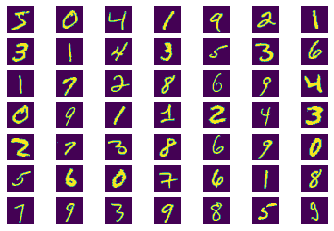

(60000, 784)

In [4]:
(X_train, y_train,X_test, y_test) = load_data()
X_train.shape


We will use Adam optimizer as it is computationally efficient and has very little memory requirement. Adam is a combination of Adagrad and RMSprop.


In [5]:
def adam_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

We create Generator which uses MLP using simple dense layers activated by tanh

In [6]:
def create_generator():
    generator=Sequential()
    generator.add(Dense(units=256, input_dim=100))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=256))
    generator.add(LeakyReLU(0.2))
    
    
    generator.add(Dense(units=784, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return generator

g = create_generator()
g.summary()


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dens

We now create the Discriminator which is also MLP. Discriminator will take the input from real data which is of the size 784 and also the images generated from Generator.

In [7]:
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=1024,input_dim=784))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator
d =create_discriminator()
d.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
___________________________

We now create the GAN where we combine the Generator and Discriminator. When we train the generator we will freeze the Discriminator.

We will input the noised image of shape 100 units to the Generator. The output generated from the Generator will be fed to the Discriminator.

In [8]:
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan
gan = create_gan(d,g)
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 784)               490256    
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1460225   
Total params: 1,950,481
Trainable params: 490,256
Non-trainable params: 1,460,225
_________________________________________________________________


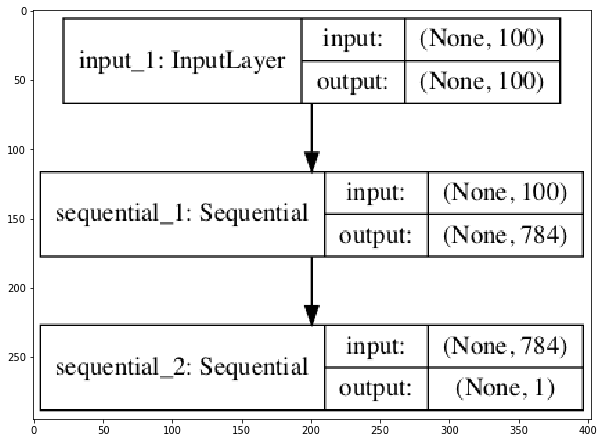

In [19]:
from keras.utils.vis_utils import plot_model
from PIL import Image
plot_model(gan, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
img = Image.open('model_plot.png')

plt.figure(figsize=(10,10))
imgplot = plt.imshow(img)

Before we start training the model, we will write a function plot_generated_images to plot the generated images. This way we can see how the images are generated. We save the generated images to file that we can view later

In [23]:
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('generated/gan_generated_image %d.png' %epoch)

We finally start to train GAN. 

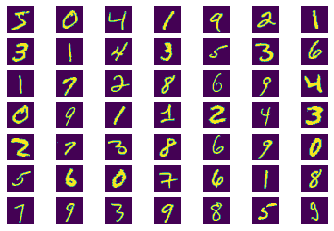



  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 1




  1%|          | 1/128 [00:06<13:46,  6.51s/it]

  2%|▏         | 2/128 [00:06<09:41,  4.61s/it]

  2%|▏         | 3/128 [00:06<06:50,  3.28s/it]

  3%|▎         | 4/128 [00:07<04:51,  2.35s/it]

  4%|▍         | 5/128 [00:07<03:29,  1.70s/it]

  5%|▍         | 6/128 [00:07<02:32,  1.25s/it]

  5%|▌         | 7/128 [00:07<01:51,  1.08it/s]

  6%|▋         | 8/128 [00:07<01:24,  1.42it/s]

  7%|▋         | 9/128 [00:08<01:07,  1.76it/s]

  8%|▊         | 10/128 [00:08<00:53,  2.22it/s]

  9%|▊         | 11/128 [00:08<00:43,  2.66it/s]

  9%|▉         | 12/128 [00:08<00:37,  3.06it/s]

 10%|█         | 13/128 [00:08<00:32,  3.53it/s]

 11%|█         | 14/128 [00:09<00:30,  3.78it/s]

 12%|█▏        | 15/128 [00:09<00:28,  3.98it/s]

 12%|█▎        | 16/128 [00:09<00:25,  4.33it/s]

 13%|█▎        | 17/128 [00:09<00:23,  4.70it/s]

 14%|█▍        | 18/128 [00:09<00:22,  4.90it/s]

 15%|█▍        | 19/128 [00:09<00:21,  5.16it/s]

 16%|█▌        | 20/128 [00:10<00:20,  5.26it/s]

 16%|█▋

Epoch 2




  2%|▏         | 2/128 [00:00<00:21,  5.77it/s]

  2%|▏         | 3/128 [00:00<00:21,  5.90it/s]

  3%|▎         | 4/128 [00:00<00:21,  5.78it/s]

  4%|▍         | 5/128 [00:00<00:20,  5.96it/s]

  5%|▍         | 6/128 [00:01<00:20,  5.95it/s]

  5%|▌         | 7/128 [00:01<00:21,  5.71it/s]

  6%|▋         | 8/128 [00:01<00:21,  5.68it/s]

  7%|▋         | 9/128 [00:01<00:20,  5.76it/s]

  8%|▊         | 10/128 [00:01<00:20,  5.67it/s]

  9%|▊         | 11/128 [00:01<00:20,  5.79it/s]

  9%|▉         | 12/128 [00:02<00:20,  5.59it/s]

 10%|█         | 13/128 [00:02<00:20,  5.67it/s]

 11%|█         | 14/128 [00:02<00:20,  5.66it/s]

 12%|█▏        | 15/128 [00:02<00:19,  5.72it/s]

 12%|█▎        | 16/128 [00:02<00:19,  5.75it/s]

 13%|█▎        | 17/128 [00:02<00:19,  5.80it/s]

 14%|█▍        | 18/128 [00:03<00:18,  5.82it/s]

 15%|█▍        | 19/128 [00:03<00:18,  5.85it/s]

 16%|█▌        | 20/128 [00:03<00:18,  5.81it/s]

 16%|█▋        | 21/128 [00:03<00:18,  5.82it/s]

 17%|█

Epoch 3




  2%|▏         | 2/128 [00:00<00:23,  5.48it/s]

  2%|▏         | 3/128 [00:00<00:22,  5.54it/s]

  3%|▎         | 4/128 [00:00<00:21,  5.74it/s]

  4%|▍         | 5/128 [00:00<00:21,  5.67it/s]

  5%|▍         | 6/128 [00:01<00:20,  5.86it/s]

  5%|▌         | 7/128 [00:01<00:20,  5.91it/s]

  6%|▋         | 8/128 [00:01<00:20,  5.85it/s]

  7%|▋         | 9/128 [00:01<00:20,  5.93it/s]

  8%|▊         | 10/128 [00:01<00:20,  5.88it/s]

  9%|▊         | 11/128 [00:01<00:19,  5.95it/s]

  9%|▉         | 12/128 [00:02<00:19,  5.90it/s]

 10%|█         | 13/128 [00:02<00:19,  6.05it/s]

 11%|█         | 14/128 [00:02<00:19,  5.94it/s]

 12%|█▏        | 15/128 [00:02<00:18,  6.04it/s]

 12%|█▎        | 16/128 [00:02<00:18,  5.94it/s]

 13%|█▎        | 17/128 [00:02<00:22,  4.96it/s]

 14%|█▍        | 18/128 [00:03<00:20,  5.25it/s]

 15%|█▍        | 19/128 [00:03<00:20,  5.27it/s]

 16%|█▌        | 20/128 [00:03<00:19,  5.49it/s]

 16%|█▋        | 21/128 [00:03<00:18,  5.73it/s]

 17%|█

Epoch 4




  2%|▏         | 2/128 [00:00<00:24,  5.21it/s]

  2%|▏         | 3/128 [00:00<00:22,  5.45it/s]

  3%|▎         | 4/128 [00:00<00:22,  5.44it/s]

  4%|▍         | 5/128 [00:00<00:21,  5.60it/s]

  5%|▍         | 6/128 [00:01<00:22,  5.52it/s]

  5%|▌         | 7/128 [00:01<00:21,  5.60it/s]

  6%|▋         | 8/128 [00:01<00:21,  5.52it/s]

  7%|▋         | 9/128 [00:01<00:21,  5.65it/s]

  8%|▊         | 10/128 [00:01<00:21,  5.54it/s]

  9%|▊         | 11/128 [00:01<00:20,  5.73it/s]

  9%|▉         | 12/128 [00:02<00:20,  5.58it/s]

 10%|█         | 13/128 [00:02<00:20,  5.71it/s]

 11%|█         | 14/128 [00:02<00:20,  5.66it/s]

 12%|█▏        | 15/128 [00:02<00:19,  5.80it/s]

 12%|█▎        | 16/128 [00:02<00:18,  5.90it/s]

 13%|█▎        | 17/128 [00:02<00:18,  5.97it/s]

 14%|█▍        | 18/128 [00:03<00:18,  5.95it/s]

 15%|█▍        | 19/128 [00:03<00:19,  5.48it/s]

 16%|█▌        | 20/128 [00:03<00:20,  5.36it/s]

 16%|█▋        | 21/128 [00:03<00:19,  5.59it/s]

 17%|█

Epoch 5




  2%|▏         | 2/128 [00:00<00:23,  5.43it/s]

  2%|▏         | 3/128 [00:00<00:23,  5.41it/s]

  3%|▎         | 4/128 [00:00<00:22,  5.61it/s]

  4%|▍         | 5/128 [00:00<00:22,  5.59it/s]

  5%|▍         | 6/128 [00:01<00:21,  5.65it/s]

  5%|▌         | 7/128 [00:01<00:21,  5.52it/s]

  6%|▋         | 8/128 [00:01<00:21,  5.63it/s]

  7%|▋         | 9/128 [00:01<00:20,  5.67it/s]

  8%|▊         | 10/128 [00:01<00:20,  5.79it/s]

  9%|▊         | 11/128 [00:01<00:20,  5.61it/s]

  9%|▉         | 12/128 [00:02<00:21,  5.42it/s]

 10%|█         | 13/128 [00:02<00:21,  5.43it/s]

 11%|█         | 14/128 [00:02<00:20,  5.65it/s]

 12%|█▏        | 15/128 [00:02<00:19,  5.69it/s]

 12%|█▎        | 16/128 [00:02<00:19,  5.85it/s]

 13%|█▎        | 17/128 [00:03<00:19,  5.78it/s]

 14%|█▍        | 18/128 [00:03<00:18,  5.85it/s]

 15%|█▍        | 19/128 [00:03<00:19,  5.70it/s]

 16%|█▌        | 20/128 [00:03<00:18,  5.87it/s]

 16%|█▋        | 21/128 [00:03<00:18,  5.94it/s]

 17%|█

Epoch 6




  1%|          | 1/128 [00:00<00:24,  5.09it/s]

  2%|▏         | 2/128 [00:00<00:24,  5.12it/s]

  2%|▏         | 3/128 [00:00<00:23,  5.22it/s]

  3%|▎         | 4/128 [00:00<00:23,  5.22it/s]

  4%|▍         | 5/128 [00:00<00:23,  5.23it/s]

  5%|▍         | 6/128 [00:01<00:22,  5.39it/s]

  5%|▌         | 7/128 [00:01<00:21,  5.55it/s]

  6%|▋         | 8/128 [00:01<00:21,  5.54it/s]

  7%|▋         | 9/128 [00:01<00:21,  5.66it/s]

  8%|▊         | 10/128 [00:01<00:20,  5.66it/s]

  9%|▊         | 11/128 [00:01<00:20,  5.83it/s]

  9%|▉         | 12/128 [00:02<00:21,  5.43it/s]

 10%|█         | 13/128 [00:02<00:20,  5.49it/s]

 11%|█         | 14/128 [00:02<00:20,  5.47it/s]

 12%|█▏        | 15/128 [00:02<00:20,  5.60it/s]

 12%|█▎        | 16/128 [00:02<00:20,  5.56it/s]

 13%|█▎        | 17/128 [00:03<00:19,  5.58it/s]

 14%|█▍        | 18/128 [00:03<00:19,  5.52it/s]

 15%|█▍        | 19/128 [00:03<00:19,  5.70it/s]

 16%|█▌        | 20/128 [00:03<00:18,  5.74it/s]

 16%|█▋

Epoch 7




  2%|▏         | 2/128 [00:00<00:24,  5.19it/s]

  2%|▏         | 3/128 [00:00<00:22,  5.44it/s]

  3%|▎         | 4/128 [00:00<00:22,  5.45it/s]

  4%|▍         | 5/128 [00:00<00:21,  5.65it/s]

  5%|▍         | 6/128 [00:01<00:20,  5.87it/s]

  5%|▌         | 7/128 [00:01<00:20,  5.91it/s]

  6%|▋         | 8/128 [00:01<00:20,  5.98it/s]

  7%|▋         | 9/128 [00:01<00:20,  5.78it/s]

  8%|▊         | 10/128 [00:01<00:20,  5.87it/s]

  9%|▊         | 11/128 [00:01<00:19,  5.87it/s]

  9%|▉         | 12/128 [00:02<00:19,  5.89it/s]

 10%|█         | 13/128 [00:02<00:19,  5.88it/s]

 11%|█         | 14/128 [00:02<00:19,  5.94it/s]

 12%|█▏        | 15/128 [00:02<00:19,  5.82it/s]

 12%|█▎        | 16/128 [00:02<00:19,  5.85it/s]

 13%|█▎        | 17/128 [00:02<00:19,  5.83it/s]

 14%|█▍        | 18/128 [00:03<00:18,  5.95it/s]

 15%|█▍        | 19/128 [00:03<00:18,  5.90it/s]

 16%|█▌        | 20/128 [00:03<00:17,  6.03it/s]

 16%|█▋        | 21/128 [00:03<00:17,  5.99it/s]

 17%|█

Epoch 8




  2%|▏         | 2/128 [00:00<00:22,  5.53it/s]

  2%|▏         | 3/128 [00:00<00:22,  5.50it/s]

  3%|▎         | 4/128 [00:00<00:21,  5.74it/s]

  4%|▍         | 5/128 [00:00<00:22,  5.44it/s]

  5%|▍         | 6/128 [00:01<00:21,  5.67it/s]

  5%|▌         | 7/128 [00:01<00:21,  5.63it/s]

  6%|▋         | 8/128 [00:01<00:20,  5.85it/s]

  7%|▋         | 9/128 [00:01<00:19,  5.95it/s]

  8%|▊         | 10/128 [00:01<00:20,  5.87it/s]

  9%|▊         | 11/128 [00:01<00:19,  6.03it/s]

  9%|▉         | 12/128 [00:02<00:19,  6.00it/s]

 10%|█         | 13/128 [00:02<00:18,  6.10it/s]

 11%|█         | 14/128 [00:02<00:18,  6.00it/s]

 12%|█▏        | 15/128 [00:02<00:18,  6.09it/s]

 12%|█▎        | 16/128 [00:02<00:18,  6.10it/s]

 13%|█▎        | 17/128 [00:02<00:17,  6.21it/s]

 14%|█▍        | 18/128 [00:03<00:17,  6.11it/s]

 15%|█▍        | 19/128 [00:03<00:17,  6.25it/s]

 16%|█▌        | 20/128 [00:03<00:17,  6.18it/s]

 16%|█▋        | 21/128 [00:03<00:17,  6.26it/s]

 17%|█

Epoch 9




  2%|▏         | 2/128 [00:00<00:23,  5.28it/s]

  2%|▏         | 3/128 [00:00<00:23,  5.33it/s]

  3%|▎         | 4/128 [00:00<00:22,  5.49it/s]

  4%|▍         | 5/128 [00:00<00:21,  5.61it/s]

  5%|▍         | 6/128 [00:01<00:22,  5.51it/s]

  5%|▌         | 7/128 [00:01<00:21,  5.69it/s]

  6%|▋         | 8/128 [00:01<00:20,  5.75it/s]

  7%|▋         | 9/128 [00:01<00:21,  5.64it/s]

  8%|▊         | 10/128 [00:01<00:20,  5.66it/s]

  9%|▊         | 11/128 [00:01<00:20,  5.71it/s]

  9%|▉         | 12/128 [00:02<00:22,  5.16it/s]

 10%|█         | 13/128 [00:02<00:22,  5.18it/s]

 11%|█         | 14/128 [00:02<00:22,  5.03it/s]

 12%|█▏        | 15/128 [00:02<00:22,  5.11it/s]

 12%|█▎        | 16/128 [00:02<00:22,  5.09it/s]

 13%|█▎        | 17/128 [00:03<00:22,  4.98it/s]

 14%|█▍        | 18/128 [00:03<00:22,  4.96it/s]

 15%|█▍        | 19/128 [00:03<00:23,  4.68it/s]

 16%|█▌        | 20/128 [00:03<00:24,  4.35it/s]

 16%|█▋        | 21/128 [00:04<00:24,  4.39it/s]

 17%|█

Epoch 10




  2%|▏         | 2/128 [00:00<00:22,  5.64it/s]

  2%|▏         | 3/128 [00:00<00:21,  5.83it/s]

  3%|▎         | 4/128 [00:00<00:20,  5.91it/s]

  4%|▍         | 5/128 [00:00<00:20,  5.98it/s]

  5%|▍         | 6/128 [00:01<00:20,  6.01it/s]

  5%|▌         | 7/128 [00:01<00:19,  6.18it/s]

  6%|▋         | 8/128 [00:01<00:19,  6.22it/s]

  7%|▋         | 9/128 [00:01<00:19,  6.15it/s]

  8%|▊         | 10/128 [00:01<00:18,  6.32it/s]

  9%|▊         | 11/128 [00:01<00:19,  6.08it/s]

  9%|▉         | 12/128 [00:01<00:18,  6.22it/s]

 10%|█         | 13/128 [00:02<00:18,  6.16it/s]

 11%|█         | 14/128 [00:02<00:18,  6.16it/s]

 12%|█▏        | 15/128 [00:02<00:18,  6.23it/s]

 12%|█▎        | 16/128 [00:02<00:17,  6.37it/s]

 13%|█▎        | 17/128 [00:02<00:17,  6.23it/s]

 14%|█▍        | 18/128 [00:02<00:17,  6.11it/s]

 15%|█▍        | 19/128 [00:03<00:17,  6.20it/s]

 16%|█▌        | 20/128 [00:03<00:17,  6.10it/s]

 16%|█▋        | 21/128 [00:03<00:17,  6.16it/s]

 17%|█

Epoch 11




  2%|▏         | 2/128 [00:00<00:20,  6.12it/s]

  2%|▏         | 3/128 [00:00<00:20,  6.24it/s]

  3%|▎         | 4/128 [00:00<00:20,  6.15it/s]

  4%|▍         | 5/128 [00:00<00:19,  6.23it/s]

  5%|▍         | 6/128 [00:00<00:20,  6.00it/s]

  5%|▌         | 7/128 [00:01<00:19,  6.10it/s]

  6%|▋         | 8/128 [00:01<00:20,  5.88it/s]

  7%|▋         | 9/128 [00:01<00:19,  6.00it/s]

  8%|▊         | 10/128 [00:01<00:19,  5.98it/s]

  9%|▊         | 11/128 [00:01<00:19,  6.10it/s]

  9%|▉         | 12/128 [00:01<00:19,  6.09it/s]

 10%|█         | 13/128 [00:02<00:18,  6.21it/s]

 11%|█         | 14/128 [00:02<00:18,  6.10it/s]

 12%|█▏        | 15/128 [00:02<00:18,  6.13it/s]

 12%|█▎        | 16/128 [00:02<00:18,  6.19it/s]

 13%|█▎        | 17/128 [00:02<00:18,  6.16it/s]

 14%|█▍        | 18/128 [00:02<00:17,  6.21it/s]

 15%|█▍        | 19/128 [00:03<00:17,  6.18it/s]

 16%|█▌        | 20/128 [00:03<00:17,  6.21it/s]

 16%|█▋        | 21/128 [00:03<00:17,  6.12it/s]

 17%|█

Epoch 12




  2%|▏         | 2/128 [00:00<00:20,  6.09it/s]

  2%|▏         | 3/128 [00:00<00:20,  6.17it/s]

  3%|▎         | 4/128 [00:00<00:20,  5.94it/s]

  4%|▍         | 5/128 [00:00<00:20,  6.04it/s]

  5%|▍         | 6/128 [00:01<00:21,  5.77it/s]

  5%|▌         | 7/128 [00:01<00:21,  5.64it/s]

  6%|▋         | 8/128 [00:01<00:21,  5.68it/s]

  7%|▋         | 9/128 [00:01<00:20,  5.89it/s]

  8%|▊         | 10/128 [00:01<00:19,  5.93it/s]

  9%|▊         | 11/128 [00:01<00:19,  5.97it/s]

  9%|▉         | 12/128 [00:02<00:19,  6.00it/s]

 10%|█         | 13/128 [00:02<00:18,  6.13it/s]

 11%|█         | 14/128 [00:02<00:18,  6.01it/s]

 12%|█▏        | 15/128 [00:02<00:18,  6.14it/s]

 12%|█▎        | 16/128 [00:02<00:19,  5.75it/s]

 13%|█▎        | 17/128 [00:02<00:18,  6.00it/s]

 14%|█▍        | 18/128 [00:03<00:18,  6.08it/s]

 15%|█▍        | 19/128 [00:03<00:18,  5.84it/s]

 16%|█▌        | 20/128 [00:03<00:19,  5.46it/s]

 16%|█▋        | 21/128 [00:03<00:18,  5.76it/s]

 17%|█

Epoch 13




  2%|▏         | 2/128 [00:00<00:23,  5.29it/s]

  2%|▏         | 3/128 [00:00<00:23,  5.31it/s]

  3%|▎         | 4/128 [00:00<00:22,  5.61it/s]

  4%|▍         | 5/128 [00:00<00:21,  5.64it/s]

  5%|▍         | 6/128 [00:01<00:21,  5.80it/s]

  5%|▌         | 7/128 [00:01<00:20,  5.83it/s]

  6%|▋         | 8/128 [00:01<00:20,  5.97it/s]

  7%|▋         | 9/128 [00:01<00:19,  5.98it/s]

  8%|▊         | 10/128 [00:01<00:19,  6.08it/s]

  9%|▊         | 11/128 [00:01<00:19,  5.95it/s]

  9%|▉         | 12/128 [00:02<00:19,  6.02it/s]

 10%|█         | 13/128 [00:02<00:19,  5.88it/s]

 11%|█         | 14/128 [00:02<00:19,  6.00it/s]

 12%|█▏        | 15/128 [00:02<00:18,  6.02it/s]

 12%|█▎        | 16/128 [00:02<00:18,  6.05it/s]

 13%|█▎        | 17/128 [00:02<00:17,  6.26it/s]

 14%|█▍        | 18/128 [00:03<00:17,  6.22it/s]

 15%|█▍        | 19/128 [00:03<00:17,  6.30it/s]

 16%|█▌        | 20/128 [00:03<00:17,  6.24it/s]

 16%|█▋        | 21/128 [00:03<00:16,  6.33it/s]

 17%|█

Epoch 14




  2%|▏         | 2/128 [00:00<00:24,  5.19it/s]

  2%|▏         | 3/128 [00:00<00:24,  5.20it/s]

  3%|▎         | 4/128 [00:00<00:22,  5.48it/s]

  4%|▍         | 5/128 [00:00<00:21,  5.69it/s]

  5%|▍         | 6/128 [00:01<00:21,  5.59it/s]

  5%|▌         | 7/128 [00:01<00:20,  5.81it/s]

  6%|▋         | 8/128 [00:01<00:19,  6.00it/s]

  7%|▋         | 9/128 [00:01<00:20,  5.71it/s]

  8%|▊         | 10/128 [00:01<00:19,  5.93it/s]

  9%|▊         | 11/128 [00:01<00:20,  5.68it/s]

  9%|▉         | 12/128 [00:02<00:19,  5.84it/s]

 10%|█         | 13/128 [00:02<00:19,  5.90it/s]

 11%|█         | 14/128 [00:02<00:19,  5.76it/s]

 12%|█▏        | 15/128 [00:02<00:19,  5.90it/s]

 12%|█▎        | 16/128 [00:02<00:18,  6.02it/s]

 13%|█▎        | 17/128 [00:02<00:18,  5.97it/s]

 14%|█▍        | 18/128 [00:03<00:18,  6.02it/s]

 15%|█▍        | 19/128 [00:03<00:17,  6.18it/s]

 16%|█▌        | 20/128 [00:03<00:17,  6.12it/s]

 16%|█▋        | 21/128 [00:03<00:17,  6.24it/s]

 17%|█

Epoch 15




  2%|▏         | 2/128 [00:00<00:17,  7.09it/s]

  2%|▏         | 3/128 [00:00<00:17,  7.07it/s]

  3%|▎         | 4/128 [00:00<00:17,  7.07it/s]

  4%|▍         | 5/128 [00:00<00:17,  6.84it/s]

  5%|▍         | 6/128 [00:00<00:17,  6.98it/s]

  5%|▌         | 7/128 [00:01<00:17,  6.97it/s]

  6%|▋         | 8/128 [00:01<00:17,  7.01it/s]

  7%|▋         | 9/128 [00:01<00:17,  7.00it/s]

  8%|▊         | 10/128 [00:01<00:17,  6.86it/s]

  9%|▊         | 11/128 [00:01<00:16,  6.95it/s]

  9%|▉         | 12/128 [00:01<00:16,  6.89it/s]

 10%|█         | 13/128 [00:01<00:16,  7.01it/s]

 11%|█         | 14/128 [00:02<00:16,  6.73it/s]

 12%|█▏        | 15/128 [00:02<00:16,  6.85it/s]

 12%|█▎        | 16/128 [00:02<00:16,  6.93it/s]

 13%|█▎        | 17/128 [00:02<00:16,  6.69it/s]

 14%|█▍        | 18/128 [00:02<00:16,  6.82it/s]

 15%|█▍        | 19/128 [00:02<00:15,  6.88it/s]

 16%|█▌        | 20/128 [00:02<00:15,  6.95it/s]

 16%|█▋        | 21/128 [00:03<00:15,  7.03it/s]

 17%|█

Epoch 16




  2%|▏         | 2/128 [00:00<00:19,  6.55it/s]

  2%|▏         | 3/128 [00:00<00:18,  6.68it/s]

  3%|▎         | 4/128 [00:00<00:18,  6.86it/s]

  4%|▍         | 5/128 [00:00<00:17,  6.95it/s]

  5%|▍         | 6/128 [00:00<00:18,  6.78it/s]

  5%|▌         | 7/128 [00:01<00:17,  6.88it/s]

  6%|▋         | 8/128 [00:01<00:17,  6.77it/s]

  7%|▋         | 9/128 [00:01<00:17,  6.89it/s]

  8%|▊         | 10/128 [00:01<00:16,  6.98it/s]

  9%|▊         | 11/128 [00:01<00:17,  6.76it/s]

  9%|▉         | 12/128 [00:01<00:17,  6.82it/s]

 10%|█         | 13/128 [00:01<00:17,  6.56it/s]

 11%|█         | 14/128 [00:02<00:16,  6.71it/s]

 12%|█▏        | 15/128 [00:02<00:16,  6.76it/s]

 12%|█▎        | 16/128 [00:02<00:16,  6.92it/s]

 13%|█▎        | 17/128 [00:02<00:15,  7.02it/s]

 14%|█▍        | 18/128 [00:02<00:15,  6.88it/s]

 15%|█▍        | 19/128 [00:02<00:15,  6.99it/s]

 16%|█▌        | 20/128 [00:02<00:15,  6.98it/s]

 16%|█▋        | 21/128 [00:03<00:15,  7.02it/s]

 17%|█

Epoch 17




  2%|▏         | 2/128 [00:00<00:17,  7.20it/s]

  2%|▏         | 3/128 [00:00<00:17,  7.18it/s]

  3%|▎         | 4/128 [00:00<00:17,  7.18it/s]

  4%|▍         | 5/128 [00:00<00:17,  6.92it/s]

  5%|▍         | 6/128 [00:00<00:17,  7.01it/s]

  5%|▌         | 7/128 [00:00<00:17,  6.99it/s]

  6%|▋         | 8/128 [00:01<00:17,  7.00it/s]

  7%|▋         | 9/128 [00:01<00:16,  7.05it/s]

  8%|▊         | 10/128 [00:01<00:17,  6.84it/s]

  9%|▊         | 11/128 [00:01<00:16,  6.95it/s]

  9%|▉         | 12/128 [00:01<00:16,  6.86it/s]

 10%|█         | 13/128 [00:01<00:16,  6.95it/s]

 11%|█         | 14/128 [00:02<00:16,  6.72it/s]

 12%|█▏        | 15/128 [00:02<00:16,  6.85it/s]

 12%|█▎        | 16/128 [00:02<00:16,  6.96it/s]

 13%|█▎        | 17/128 [00:02<00:16,  6.81it/s]

 14%|█▍        | 18/128 [00:02<00:15,  6.96it/s]

 15%|█▍        | 19/128 [00:02<00:15,  6.88it/s]

 16%|█▌        | 20/128 [00:02<00:15,  7.00it/s]

 16%|█▋        | 21/128 [00:03<00:15,  7.04it/s]

 17%|█

Epoch 18




  2%|▏         | 2/128 [00:00<00:18,  6.94it/s]

  2%|▏         | 3/128 [00:00<00:17,  7.03it/s]

  3%|▎         | 4/128 [00:00<00:18,  6.88it/s]

  4%|▍         | 5/128 [00:00<00:17,  6.96it/s]

  5%|▍         | 6/128 [00:00<00:17,  6.92it/s]

  5%|▌         | 7/128 [00:01<00:17,  6.99it/s]

  6%|▋         | 8/128 [00:01<00:16,  7.07it/s]

  7%|▋         | 9/128 [00:01<00:17,  6.86it/s]

  8%|▊         | 10/128 [00:01<00:16,  6.98it/s]

  9%|▊         | 11/128 [00:01<00:17,  6.85it/s]

  9%|▉         | 12/128 [00:01<00:16,  6.88it/s]

 10%|█         | 13/128 [00:01<00:17,  6.71it/s]

 11%|█         | 14/128 [00:02<00:16,  6.87it/s]

 12%|█▏        | 15/128 [00:02<00:16,  6.94it/s]

 12%|█▎        | 16/128 [00:02<00:16,  6.81it/s]

 13%|█▎        | 17/128 [00:02<00:16,  6.71it/s]

 14%|█▍        | 18/128 [00:02<00:16,  6.69it/s]

 15%|█▍        | 19/128 [00:02<00:15,  6.85it/s]

 16%|█▌        | 20/128 [00:02<00:15,  6.94it/s]

 16%|█▋        | 21/128 [00:03<00:15,  6.78it/s]

 17%|█

Epoch 19




  2%|▏         | 2/128 [00:00<00:18,  6.76it/s]

  2%|▏         | 3/128 [00:00<00:18,  6.89it/s]

  3%|▎         | 4/128 [00:00<00:17,  6.99it/s]

  4%|▍         | 5/128 [00:00<00:18,  6.81it/s]

  5%|▍         | 6/128 [00:00<00:17,  6.95it/s]

  5%|▌         | 7/128 [00:01<00:17,  6.88it/s]

  6%|▋         | 8/128 [00:01<00:17,  6.90it/s]

  7%|▋         | 9/128 [00:01<00:17,  6.98it/s]

  8%|▊         | 10/128 [00:01<00:17,  6.89it/s]

  9%|▊         | 11/128 [00:01<00:16,  6.96it/s]

  9%|▉         | 12/128 [00:01<00:17,  6.51it/s]

 10%|█         | 13/128 [00:02<00:21,  5.36it/s]

 11%|█         | 14/128 [00:02<00:20,  5.66it/s]

 12%|█▏        | 15/128 [00:02<00:18,  6.02it/s]

 12%|█▎        | 16/128 [00:02<00:23,  4.71it/s]

 13%|█▎        | 17/128 [00:02<00:23,  4.75it/s]

 14%|█▍        | 18/128 [00:03<00:21,  5.13it/s]

 15%|█▍        | 19/128 [00:03<00:19,  5.54it/s]

 16%|█▌        | 20/128 [00:03<00:18,  5.81it/s]

 16%|█▋        | 21/128 [00:03<00:18,  5.78it/s]

 17%|█

Epoch 20




  2%|▏         | 2/128 [00:00<00:23,  5.37it/s]

  2%|▏         | 3/128 [00:00<00:23,  5.38it/s]

  3%|▎         | 4/128 [00:00<00:23,  5.37it/s]

  4%|▍         | 5/128 [00:00<00:22,  5.42it/s]

  5%|▍         | 6/128 [00:01<00:22,  5.52it/s]

  5%|▌         | 7/128 [00:01<00:22,  5.42it/s]

  6%|▋         | 8/128 [00:01<00:21,  5.57it/s]

  7%|▋         | 9/128 [00:01<00:24,  4.83it/s]

  8%|▊         | 10/128 [00:01<00:23,  5.01it/s]

  9%|▊         | 11/128 [00:02<00:23,  5.05it/s]

  9%|▉         | 12/128 [00:02<00:21,  5.31it/s]

 10%|█         | 13/128 [00:02<00:20,  5.56it/s]

 11%|█         | 14/128 [00:02<00:19,  5.83it/s]

 12%|█▏        | 15/128 [00:02<00:18,  6.02it/s]

 12%|█▎        | 16/128 [00:02<00:18,  6.07it/s]

 13%|█▎        | 17/128 [00:03<00:18,  6.09it/s]

 14%|█▍        | 18/128 [00:03<00:18,  5.92it/s]

 15%|█▍        | 19/128 [00:03<00:18,  6.04it/s]

 16%|█▌        | 20/128 [00:03<00:18,  5.97it/s]

 16%|█▋        | 21/128 [00:03<00:17,  5.95it/s]

 17%|█

Epoch 21




  2%|▏         | 2/128 [00:00<00:21,  5.82it/s]

  2%|▏         | 3/128 [00:00<00:22,  5.48it/s]

  3%|▎         | 4/128 [00:00<00:22,  5.58it/s]

  4%|▍         | 5/128 [00:00<00:22,  5.52it/s]

  5%|▍         | 6/128 [00:01<00:22,  5.50it/s]

  5%|▌         | 7/128 [00:01<00:22,  5.38it/s]

  6%|▋         | 8/128 [00:01<00:22,  5.37it/s]

  7%|▋         | 9/128 [00:01<00:21,  5.61it/s]

  8%|▊         | 10/128 [00:01<00:20,  5.88it/s]

  9%|▊         | 11/128 [00:01<00:20,  5.81it/s]

  9%|▉         | 12/128 [00:02<00:19,  5.95it/s]

 10%|█         | 13/128 [00:02<00:18,  6.10it/s]

 11%|█         | 14/128 [00:02<00:18,  6.10it/s]

 12%|█▏        | 15/128 [00:02<00:18,  6.18it/s]

 12%|█▎        | 16/128 [00:02<00:18,  6.16it/s]

 13%|█▎        | 17/128 [00:02<00:17,  6.23it/s]

 14%|█▍        | 18/128 [00:03<00:18,  5.96it/s]

 15%|█▍        | 19/128 [00:03<00:17,  6.10it/s]

 16%|█▌        | 20/128 [00:03<00:18,  5.98it/s]

 16%|█▋        | 21/128 [00:03<00:17,  6.16it/s]

 17%|█

Epoch 22




  2%|▏         | 2/128 [00:00<00:19,  6.55it/s]

  2%|▏         | 3/128 [00:00<00:20,  6.01it/s]

  3%|▎         | 4/128 [00:00<00:22,  5.56it/s]

  4%|▍         | 5/128 [00:00<00:22,  5.53it/s]

  5%|▍         | 6/128 [00:01<00:22,  5.42it/s]

  5%|▌         | 7/128 [00:01<00:22,  5.32it/s]

  6%|▋         | 8/128 [00:01<00:22,  5.28it/s]

  7%|▋         | 9/128 [00:01<00:21,  5.52it/s]

  8%|▊         | 10/128 [00:01<00:20,  5.65it/s]

  9%|▊         | 11/128 [00:02<00:23,  4.89it/s]

  9%|▉         | 12/128 [00:02<00:23,  5.03it/s]

 10%|█         | 13/128 [00:02<00:22,  5.20it/s]

 11%|█         | 14/128 [00:02<00:21,  5.39it/s]

 12%|█▏        | 15/128 [00:02<00:20,  5.43it/s]

 12%|█▎        | 16/128 [00:03<00:22,  4.93it/s]

 13%|█▎        | 17/128 [00:03<00:22,  4.88it/s]

 14%|█▍        | 18/128 [00:03<00:21,  5.11it/s]

 15%|█▍        | 19/128 [00:03<00:20,  5.21it/s]

 16%|█▌        | 20/128 [00:03<00:22,  4.71it/s]

 16%|█▋        | 21/128 [00:04<00:21,  4.89it/s]

 17%|█

Epoch 23




  2%|▏         | 2/128 [00:00<00:18,  6.95it/s]

  2%|▏         | 3/128 [00:00<00:17,  6.95it/s]

  3%|▎         | 4/128 [00:00<00:19,  6.47it/s]

  4%|▍         | 5/128 [00:00<00:22,  5.56it/s]

  5%|▍         | 6/128 [00:01<00:22,  5.52it/s]

  5%|▌         | 7/128 [00:01<00:20,  5.90it/s]

  6%|▋         | 8/128 [00:01<00:19,  6.06it/s]

  7%|▋         | 9/128 [00:01<00:18,  6.32it/s]

  8%|▊         | 10/128 [00:01<00:18,  6.43it/s]

  9%|▊         | 11/128 [00:01<00:17,  6.56it/s]

  9%|▉         | 12/128 [00:01<00:17,  6.64it/s]

 10%|█         | 13/128 [00:02<00:17,  6.58it/s]

 11%|█         | 14/128 [00:02<00:17,  6.69it/s]

 12%|█▏        | 15/128 [00:02<00:16,  6.67it/s]

 12%|█▎        | 16/128 [00:02<00:18,  5.97it/s]

 13%|█▎        | 17/128 [00:02<00:22,  4.95it/s]

 14%|█▍        | 18/128 [00:03<00:22,  4.93it/s]

 15%|█▍        | 19/128 [00:03<00:25,  4.24it/s]

 16%|█▌        | 20/128 [00:03<00:26,  4.04it/s]

 16%|█▋        | 21/128 [00:03<00:23,  4.48it/s]

 17%|█

Epoch 24




  2%|▏         | 2/128 [00:00<00:20,  6.12it/s]

  2%|▏         | 3/128 [00:00<00:20,  6.04it/s]

  3%|▎         | 4/128 [00:00<00:20,  6.17it/s]

  4%|▍         | 5/128 [00:00<00:20,  6.13it/s]

  5%|▍         | 6/128 [00:00<00:19,  6.26it/s]

  5%|▌         | 7/128 [00:01<00:19,  6.27it/s]

  6%|▋         | 8/128 [00:01<00:18,  6.40it/s]

  7%|▋         | 9/128 [00:01<00:18,  6.30it/s]

  8%|▊         | 10/128 [00:01<00:18,  6.33it/s]

  9%|▊         | 11/128 [00:01<00:18,  6.36it/s]

  9%|▉         | 12/128 [00:01<00:18,  6.39it/s]

 10%|█         | 13/128 [00:02<00:17,  6.42it/s]

 11%|█         | 14/128 [00:02<00:17,  6.35it/s]

 12%|█▏        | 15/128 [00:02<00:17,  6.38it/s]

 12%|█▎        | 16/128 [00:02<00:18,  6.22it/s]

 13%|█▎        | 17/128 [00:02<00:17,  6.26it/s]

 14%|█▍        | 18/128 [00:02<00:17,  6.25it/s]

 15%|█▍        | 19/128 [00:03<00:17,  6.35it/s]

 16%|█▌        | 20/128 [00:03<00:17,  6.17it/s]

 16%|█▋        | 21/128 [00:03<00:16,  6.30it/s]

 17%|█

Epoch 25




  2%|▏         | 2/128 [00:00<00:21,  5.99it/s]

  2%|▏         | 3/128 [00:00<00:20,  6.16it/s]

  3%|▎         | 4/128 [00:00<00:20,  6.14it/s]

  4%|▍         | 5/128 [00:00<00:19,  6.26it/s]

  5%|▍         | 6/128 [00:00<00:19,  6.16it/s]

  5%|▌         | 7/128 [00:01<00:19,  6.22it/s]

  6%|▋         | 8/128 [00:01<00:19,  6.31it/s]

  7%|▋         | 9/128 [00:01<00:18,  6.33it/s]

  8%|▊         | 10/128 [00:01<00:18,  6.30it/s]

  9%|▊         | 11/128 [00:01<00:18,  6.27it/s]

  9%|▉         | 12/128 [00:01<00:18,  6.40it/s]

 10%|█         | 13/128 [00:02<00:18,  6.20it/s]

 11%|█         | 14/128 [00:02<00:18,  6.32it/s]

 12%|█▏        | 15/128 [00:02<00:18,  6.27it/s]

 12%|█▎        | 16/128 [00:02<00:17,  6.29it/s]

 13%|█▎        | 17/128 [00:02<00:18,  6.07it/s]

 14%|█▍        | 18/128 [00:02<00:17,  6.22it/s]

 15%|█▍        | 19/128 [00:03<00:17,  6.31it/s]

 16%|█▌        | 20/128 [00:03<00:17,  6.32it/s]

 16%|█▋        | 21/128 [00:03<00:16,  6.34it/s]

 17%|█

Epoch 26




  1%|          | 1/128 [00:00<00:50,  2.50it/s]

  2%|▏         | 2/128 [00:00<00:46,  2.72it/s]

  2%|▏         | 3/128 [00:00<00:39,  3.14it/s]

  3%|▎         | 4/128 [00:01<00:33,  3.72it/s]

  4%|▍         | 5/128 [00:01<00:29,  4.14it/s]

  5%|▍         | 6/128 [00:01<00:26,  4.66it/s]

  5%|▌         | 7/128 [00:01<00:24,  5.03it/s]

  6%|▋         | 8/128 [00:01<00:23,  5.21it/s]

  7%|▋         | 9/128 [00:01<00:21,  5.45it/s]

  8%|▊         | 10/128 [00:02<00:21,  5.37it/s]

  9%|▊         | 11/128 [00:02<00:22,  5.16it/s]

  9%|▉         | 12/128 [00:02<00:21,  5.32it/s]

 10%|█         | 13/128 [00:02<00:21,  5.37it/s]

 11%|█         | 14/128 [00:02<00:21,  5.33it/s]

 12%|█▏        | 15/128 [00:03<00:22,  5.00it/s]

 12%|█▎        | 16/128 [00:03<00:21,  5.18it/s]

 13%|█▎        | 17/128 [00:03<00:21,  5.20it/s]

 14%|█▍        | 18/128 [00:03<00:20,  5.30it/s]

 15%|█▍        | 19/128 [00:03<00:19,  5.48it/s]

 16%|█▌        | 20/128 [00:03<00:20,  5.35it/s]

 16%|█▋

Epoch 27




  2%|▏         | 2/128 [00:00<00:21,  5.88it/s]

  2%|▏         | 3/128 [00:00<00:20,  5.96it/s]

  3%|▎         | 4/128 [00:00<00:20,  6.17it/s]

  4%|▍         | 5/128 [00:00<00:20,  6.03it/s]

  5%|▍         | 6/128 [00:00<00:19,  6.16it/s]

  5%|▌         | 7/128 [00:01<00:19,  6.24it/s]

  6%|▋         | 8/128 [00:01<00:19,  6.20it/s]

  7%|▋         | 9/128 [00:01<00:19,  6.14it/s]

  8%|▊         | 10/128 [00:01<00:18,  6.24it/s]

  9%|▊         | 11/128 [00:01<00:18,  6.34it/s]

  9%|▉         | 12/128 [00:01<00:18,  6.31it/s]

 10%|█         | 13/128 [00:02<00:17,  6.40it/s]

 11%|█         | 14/128 [00:02<00:18,  6.29it/s]

 12%|█▏        | 15/128 [00:02<00:17,  6.37it/s]

 12%|█▎        | 16/128 [00:02<00:17,  6.31it/s]

 13%|█▎        | 17/128 [00:02<00:17,  6.39it/s]

 14%|█▍        | 18/128 [00:02<00:17,  6.30it/s]

 15%|█▍        | 19/128 [00:03<00:16,  6.42it/s]

 16%|█▌        | 20/128 [00:03<00:16,  6.49it/s]

 16%|█▋        | 21/128 [00:03<00:16,  6.36it/s]

 17%|█

Epoch 28




  2%|▏         | 2/128 [00:00<00:22,  5.50it/s]

  2%|▏         | 3/128 [00:00<00:21,  5.69it/s]

  3%|▎         | 4/128 [00:00<00:20,  5.92it/s]

  4%|▍         | 5/128 [00:00<00:20,  5.95it/s]

  5%|▍         | 6/128 [00:00<00:19,  6.12it/s]

  5%|▌         | 7/128 [00:01<00:19,  6.14it/s]

  6%|▋         | 8/128 [00:01<00:19,  6.27it/s]

  7%|▋         | 9/128 [00:01<00:19,  6.09it/s]

  8%|▊         | 10/128 [00:01<00:18,  6.23it/s]

  9%|▊         | 11/128 [00:01<00:18,  6.34it/s]

  9%|▉         | 12/128 [00:01<00:18,  6.25it/s]

 10%|█         | 13/128 [00:02<00:17,  6.41it/s]

 11%|█         | 14/128 [00:02<00:18,  6.28it/s]

 12%|█▏        | 15/128 [00:02<00:17,  6.37it/s]

 12%|█▎        | 16/128 [00:02<00:17,  6.37it/s]

 13%|█▎        | 17/128 [00:02<00:17,  6.44it/s]

 14%|█▍        | 18/128 [00:02<00:17,  6.28it/s]

 15%|█▍        | 19/128 [00:03<00:17,  6.32it/s]

 16%|█▌        | 20/128 [00:03<00:16,  6.38it/s]

 16%|█▋        | 21/128 [00:03<00:16,  6.31it/s]

 17%|█

Epoch 29




  2%|▏         | 2/128 [00:00<00:20,  6.28it/s]

  2%|▏         | 3/128 [00:00<00:19,  6.40it/s]

  3%|▎         | 4/128 [00:00<00:19,  6.31it/s]

  4%|▍         | 5/128 [00:00<00:19,  6.42it/s]

  5%|▍         | 6/128 [00:00<00:18,  6.45it/s]

  5%|▌         | 7/128 [00:01<00:19,  6.35it/s]

  6%|▋         | 8/128 [00:01<00:18,  6.42it/s]

  7%|▋         | 9/128 [00:01<00:19,  6.26it/s]

  8%|▊         | 10/128 [00:01<00:18,  6.22it/s]

  9%|▊         | 11/128 [00:01<00:19,  5.95it/s]

  9%|▉         | 12/128 [00:01<00:19,  5.99it/s]

 10%|█         | 13/128 [00:02<00:19,  5.80it/s]

 11%|█         | 14/128 [00:02<00:19,  5.99it/s]

 12%|█▏        | 15/128 [00:02<00:18,  6.05it/s]

 12%|█▎        | 16/128 [00:02<00:18,  6.19it/s]

 13%|█▎        | 17/128 [00:02<00:18,  6.11it/s]

 14%|█▍        | 18/128 [00:02<00:17,  6.22it/s]

 15%|█▍        | 19/128 [00:03<00:17,  6.30it/s]

 16%|█▌        | 20/128 [00:03<00:17,  6.14it/s]

 16%|█▋        | 21/128 [00:03<00:17,  6.14it/s]

 17%|█

Epoch 30




  2%|▏         | 2/128 [00:00<00:22,  5.55it/s]

  2%|▏         | 3/128 [00:00<00:21,  5.74it/s]

  3%|▎         | 4/128 [00:00<00:20,  5.99it/s]

  4%|▍         | 5/128 [00:00<00:20,  6.13it/s]

  5%|▍         | 6/128 [00:00<00:19,  6.16it/s]

  5%|▌         | 7/128 [00:01<00:19,  6.28it/s]

  6%|▋         | 8/128 [00:01<00:19,  6.26it/s]

  7%|▋         | 9/128 [00:01<00:18,  6.38it/s]

  8%|▊         | 10/128 [00:01<00:18,  6.28it/s]

  9%|▊         | 11/128 [00:01<00:18,  6.40it/s]

  9%|▉         | 12/128 [00:01<00:18,  6.36it/s]

 10%|█         | 13/128 [00:02<00:17,  6.44it/s]

 11%|█         | 14/128 [00:02<00:17,  6.48it/s]

 12%|█▏        | 15/128 [00:02<00:17,  6.37it/s]

 12%|█▎        | 16/128 [00:02<00:17,  6.44it/s]

 13%|█▎        | 17/128 [00:02<00:17,  6.19it/s]

 14%|█▍        | 18/128 [00:02<00:17,  6.24it/s]

 15%|█▍        | 19/128 [00:03<00:18,  5.95it/s]

 16%|█▌        | 20/128 [00:03<00:17,  6.04it/s]

 16%|█▋        | 21/128 [00:03<00:17,  6.04it/s]

 17%|█

Epoch 31




  2%|▏         | 2/128 [00:00<00:21,  5.84it/s]

  2%|▏         | 3/128 [00:00<00:20,  6.07it/s]

  3%|▎         | 4/128 [00:00<00:20,  6.08it/s]

  4%|▍         | 5/128 [00:00<00:19,  6.23it/s]

  5%|▍         | 6/128 [00:00<00:19,  6.35it/s]

  5%|▌         | 7/128 [00:01<00:19,  6.25it/s]

  6%|▋         | 8/128 [00:01<00:18,  6.40it/s]

  7%|▋         | 9/128 [00:01<00:18,  6.33it/s]

  8%|▊         | 10/128 [00:01<00:18,  6.42it/s]

  9%|▊         | 11/128 [00:01<00:18,  6.30it/s]

  9%|▉         | 12/128 [00:01<00:18,  6.30it/s]

 10%|█         | 13/128 [00:02<00:18,  6.29it/s]

 11%|█         | 14/128 [00:02<00:17,  6.37it/s]

 12%|█▏        | 15/128 [00:02<00:17,  6.44it/s]

 12%|█▎        | 16/128 [00:02<00:17,  6.34it/s]

 13%|█▎        | 17/128 [00:02<00:17,  6.41it/s]

 14%|█▍        | 18/128 [00:02<00:17,  6.31it/s]

 15%|█▍        | 19/128 [00:03<00:17,  6.38it/s]

 16%|█▌        | 20/128 [00:03<00:17,  6.15it/s]

 16%|█▋        | 21/128 [00:03<00:16,  6.30it/s]

 17%|█

Epoch 32




  2%|▏         | 2/128 [00:00<00:22,  5.62it/s]

  2%|▏         | 3/128 [00:00<00:21,  5.90it/s]

  3%|▎         | 4/128 [00:00<00:20,  5.94it/s]

  4%|▍         | 5/128 [00:00<00:20,  6.10it/s]

  5%|▍         | 6/128 [00:00<00:19,  6.11it/s]

  5%|▌         | 7/128 [00:01<00:19,  6.24it/s]

  6%|▋         | 8/128 [00:01<00:19,  6.18it/s]

  7%|▋         | 9/128 [00:01<00:18,  6.29it/s]

  8%|▊         | 10/128 [00:01<00:18,  6.28it/s]

  9%|▊         | 11/128 [00:01<00:18,  6.42it/s]

  9%|▉         | 12/128 [00:01<00:17,  6.58it/s]

 10%|█         | 13/128 [00:02<00:17,  6.40it/s]

 11%|█         | 14/128 [00:02<00:17,  6.40it/s]

 12%|█▏        | 15/128 [00:02<00:18,  6.27it/s]

 12%|█▎        | 16/128 [00:02<00:17,  6.39it/s]

 13%|█▎        | 17/128 [00:02<00:17,  6.44it/s]

 14%|█▍        | 18/128 [00:02<00:16,  6.51it/s]

 15%|█▍        | 19/128 [00:03<00:17,  6.31it/s]

 16%|█▌        | 20/128 [00:03<00:16,  6.44it/s]

 16%|█▋        | 21/128 [00:03<00:16,  6.43it/s]

 17%|█

Epoch 33




  2%|▏         | 2/128 [00:00<00:26,  4.77it/s]

  2%|▏         | 3/128 [00:00<00:28,  4.41it/s]

  3%|▎         | 4/128 [00:00<00:29,  4.25it/s]

  4%|▍         | 5/128 [00:01<00:25,  4.79it/s]

  5%|▍         | 6/128 [00:01<00:23,  5.12it/s]

  5%|▌         | 7/128 [00:01<00:21,  5.51it/s]

  6%|▋         | 8/128 [00:01<00:21,  5.64it/s]

  7%|▋         | 9/128 [00:01<00:20,  5.91it/s]

  8%|▊         | 10/128 [00:01<00:19,  6.14it/s]

  9%|▊         | 11/128 [00:02<00:19,  6.05it/s]

  9%|▉         | 12/128 [00:02<00:18,  6.18it/s]

 10%|█         | 13/128 [00:02<00:19,  6.02it/s]

 11%|█         | 14/128 [00:02<00:18,  6.22it/s]

 12%|█▏        | 15/128 [00:02<00:19,  5.94it/s]

 12%|█▎        | 16/128 [00:02<00:18,  5.91it/s]

 13%|█▎        | 17/128 [00:03<00:18,  5.90it/s]

 14%|█▍        | 18/128 [00:03<00:18,  6.04it/s]

 15%|█▍        | 19/128 [00:03<00:17,  6.11it/s]

 16%|█▌        | 20/128 [00:03<00:18,  5.86it/s]

 16%|█▋        | 21/128 [00:03<00:17,  5.96it/s]

 17%|█

Epoch 34




  2%|▏         | 2/128 [00:00<00:22,  5.70it/s]

  2%|▏         | 3/128 [00:00<00:21,  5.91it/s]

  3%|▎         | 4/128 [00:00<00:20,  6.09it/s]

  4%|▍         | 5/128 [00:00<00:20,  6.14it/s]

  5%|▍         | 6/128 [00:00<00:19,  6.14it/s]

  5%|▌         | 7/128 [00:01<00:19,  6.11it/s]

  6%|▋         | 8/128 [00:01<00:19,  6.23it/s]

  7%|▋         | 9/128 [00:01<00:19,  6.09it/s]

  8%|▊         | 10/128 [00:01<00:18,  6.26it/s]

  9%|▊         | 11/128 [00:01<00:18,  6.17it/s]

  9%|▉         | 12/128 [00:01<00:18,  6.23it/s]

 10%|█         | 13/128 [00:02<00:18,  6.11it/s]

 11%|█         | 14/128 [00:02<00:18,  6.09it/s]

 12%|█▏        | 15/128 [00:02<00:18,  6.02it/s]

 12%|█▎        | 16/128 [00:02<00:18,  6.19it/s]

 13%|█▎        | 17/128 [00:02<00:17,  6.29it/s]

 14%|█▍        | 18/128 [00:02<00:17,  6.31it/s]

 15%|█▍        | 19/128 [00:03<00:17,  6.31it/s]

 16%|█▌        | 20/128 [00:03<00:17,  6.15it/s]

 16%|█▋        | 21/128 [00:03<00:17,  6.23it/s]

 17%|█

Epoch 35




  2%|▏         | 2/128 [00:00<00:21,  5.82it/s]

  2%|▏         | 3/128 [00:00<00:21,  5.78it/s]

  3%|▎         | 4/128 [00:00<00:20,  6.01it/s]

  4%|▍         | 5/128 [00:00<00:20,  6.11it/s]

  5%|▍         | 6/128 [00:00<00:19,  6.13it/s]

  5%|▌         | 7/128 [00:01<00:19,  6.16it/s]

  6%|▋         | 8/128 [00:01<00:18,  6.32it/s]

  7%|▋         | 9/128 [00:01<00:18,  6.30it/s]

  8%|▊         | 10/128 [00:01<00:18,  6.24it/s]

  9%|▊         | 11/128 [00:01<00:19,  6.09it/s]

  9%|▉         | 12/128 [00:01<00:18,  6.24it/s]

 10%|█         | 13/128 [00:02<00:18,  6.34it/s]

 11%|█         | 14/128 [00:02<00:18,  6.23it/s]

 12%|█▏        | 15/128 [00:02<00:18,  6.23it/s]

 12%|█▎        | 16/128 [00:02<00:18,  6.12it/s]

 13%|█▎        | 17/128 [00:02<00:18,  6.16it/s]

 14%|█▍        | 18/128 [00:02<00:17,  6.17it/s]

 15%|█▍        | 19/128 [00:03<00:17,  6.21it/s]

 16%|█▌        | 20/128 [00:03<00:17,  6.20it/s]

 16%|█▋        | 21/128 [00:03<00:16,  6.33it/s]

 17%|█

Epoch 36




  2%|▏         | 2/128 [00:00<00:20,  6.01it/s]

  2%|▏         | 3/128 [00:00<00:20,  6.05it/s]

  3%|▎         | 4/128 [00:00<00:20,  5.97it/s]

  4%|▍         | 5/128 [00:00<00:20,  6.10it/s]

  5%|▍         | 6/128 [00:00<00:19,  6.12it/s]

  5%|▌         | 7/128 [00:01<00:19,  6.28it/s]

  6%|▋         | 8/128 [00:01<00:19,  6.15it/s]

  7%|▋         | 9/128 [00:01<00:19,  6.23it/s]

  8%|▊         | 10/128 [00:01<00:18,  6.27it/s]

  9%|▊         | 11/128 [00:01<00:18,  6.30it/s]

  9%|▉         | 12/128 [00:01<00:18,  6.42it/s]

 10%|█         | 13/128 [00:02<00:18,  6.39it/s]

 11%|█         | 14/128 [00:02<00:17,  6.41it/s]

 12%|█▏        | 15/128 [00:02<00:17,  6.28it/s]

 12%|█▎        | 16/128 [00:02<00:17,  6.33it/s]

 13%|█▎        | 17/128 [00:02<00:17,  6.31it/s]

 14%|█▍        | 18/128 [00:02<00:18,  6.08it/s]

 15%|█▍        | 19/128 [00:03<00:18,  5.75it/s]

 16%|█▌        | 20/128 [00:03<00:18,  5.88it/s]

 16%|█▋        | 21/128 [00:03<00:17,  5.95it/s]

 17%|█

Epoch 37




  2%|▏         | 2/128 [00:00<00:19,  6.50it/s]

  2%|▏         | 3/128 [00:00<00:19,  6.54it/s]

  3%|▎         | 4/128 [00:00<00:18,  6.58it/s]

  4%|▍         | 5/128 [00:00<00:18,  6.70it/s]

  5%|▍         | 6/128 [00:00<00:19,  6.33it/s]

  5%|▌         | 7/128 [00:01<00:19,  6.24it/s]

  6%|▋         | 8/128 [00:01<00:19,  6.29it/s]

  7%|▋         | 9/128 [00:01<00:18,  6.31it/s]

  8%|▊         | 10/128 [00:01<00:18,  6.49it/s]

  9%|▊         | 11/128 [00:01<00:18,  6.47it/s]

  9%|▉         | 12/128 [00:01<00:17,  6.50it/s]

 10%|█         | 13/128 [00:02<00:17,  6.45it/s]

 11%|█         | 14/128 [00:02<00:17,  6.63it/s]

 12%|█▏        | 15/128 [00:02<00:16,  6.73it/s]

 12%|█▎        | 16/128 [00:02<00:17,  6.49it/s]

 13%|█▎        | 17/128 [00:02<00:16,  6.54it/s]

 14%|█▍        | 18/128 [00:02<00:17,  6.39it/s]

 15%|█▍        | 19/128 [00:02<00:16,  6.57it/s]

 16%|█▌        | 20/128 [00:03<00:16,  6.67it/s]

 16%|█▋        | 21/128 [00:03<00:15,  6.74it/s]

 17%|█

Epoch 38




  2%|▏         | 2/128 [00:00<00:18,  6.75it/s]

  2%|▏         | 3/128 [00:00<00:18,  6.73it/s]

  3%|▎         | 4/128 [00:00<00:18,  6.74it/s]

  4%|▍         | 5/128 [00:00<00:19,  6.41it/s]

  5%|▍         | 6/128 [00:00<00:18,  6.55it/s]

  5%|▌         | 7/128 [00:01<00:18,  6.71it/s]

  6%|▋         | 8/128 [00:01<00:18,  6.57it/s]

  7%|▋         | 9/128 [00:01<00:17,  6.64it/s]

  8%|▊         | 10/128 [00:01<00:18,  6.55it/s]

  9%|▊         | 11/128 [00:01<00:18,  6.49it/s]

  9%|▉         | 12/128 [00:01<00:18,  6.40it/s]

 10%|█         | 13/128 [00:01<00:17,  6.59it/s]

 11%|█         | 14/128 [00:02<00:16,  6.74it/s]

 12%|█▏        | 15/128 [00:02<00:17,  6.63it/s]

 12%|█▎        | 16/128 [00:02<00:16,  6.76it/s]

 13%|█▎        | 17/128 [00:02<00:16,  6.78it/s]

 14%|█▍        | 18/128 [00:02<00:16,  6.84it/s]

 15%|█▍        | 19/128 [00:02<00:15,  6.88it/s]

 16%|█▌        | 20/128 [00:03<00:16,  6.65it/s]

 16%|█▋        | 21/128 [00:03<00:15,  6.77it/s]

 17%|█

Epoch 39




  2%|▏         | 2/128 [00:00<00:19,  6.31it/s]

  2%|▏         | 3/128 [00:00<00:19,  6.42it/s]

  3%|▎         | 4/128 [00:00<00:18,  6.57it/s]

  4%|▍         | 5/128 [00:00<00:18,  6.70it/s]

  5%|▍         | 6/128 [00:00<00:18,  6.60it/s]

  5%|▌         | 7/128 [00:01<00:18,  6.71it/s]

  6%|▋         | 8/128 [00:01<00:18,  6.66it/s]

  7%|▋         | 9/128 [00:01<00:17,  6.77it/s]

  8%|▊         | 10/128 [00:01<00:17,  6.66it/s]

  9%|▊         | 11/128 [00:01<00:17,  6.80it/s]

  9%|▉         | 12/128 [00:01<00:16,  6.88it/s]

 10%|█         | 13/128 [00:01<00:17,  6.68it/s]

 11%|█         | 14/128 [00:02<00:16,  6.82it/s]

 12%|█▏        | 15/128 [00:02<00:16,  6.76it/s]

 12%|█▎        | 16/128 [00:02<00:16,  6.83it/s]

 13%|█▎        | 17/128 [00:02<00:16,  6.93it/s]

 14%|█▍        | 18/128 [00:02<00:16,  6.66it/s]

 15%|█▍        | 19/128 [00:02<00:16,  6.67it/s]

 16%|█▌        | 20/128 [00:02<00:16,  6.59it/s]

 16%|█▋        | 21/128 [00:03<00:15,  6.74it/s]

 17%|█

Epoch 40




  2%|▏         | 2/128 [00:00<00:19,  6.53it/s]

  2%|▏         | 3/128 [00:00<00:18,  6.64it/s]

  3%|▎         | 4/128 [00:00<00:18,  6.64it/s]

  4%|▍         | 5/128 [00:00<00:18,  6.77it/s]

  5%|▍         | 6/128 [00:00<00:17,  6.82it/s]

  5%|▌         | 7/128 [00:01<00:17,  6.91it/s]

  6%|▋         | 8/128 [00:01<00:17,  6.93it/s]

  7%|▋         | 9/128 [00:01<00:17,  6.72it/s]

  8%|▊         | 10/128 [00:01<00:17,  6.68it/s]

  9%|▊         | 11/128 [00:01<00:17,  6.51it/s]

  9%|▉         | 12/128 [00:01<00:17,  6.65it/s]

 10%|█         | 13/128 [00:01<00:17,  6.61it/s]

 11%|█         | 14/128 [00:02<00:16,  6.78it/s]

 12%|█▏        | 15/128 [00:02<00:16,  6.82it/s]

 12%|█▎        | 16/128 [00:02<00:17,  6.37it/s]

 13%|█▎        | 17/128 [00:02<00:17,  6.48it/s]

 14%|█▍        | 18/128 [00:02<00:17,  6.31it/s]

 15%|█▍        | 19/128 [00:02<00:16,  6.46it/s]

 16%|█▌        | 20/128 [00:03<00:16,  6.53it/s]

 16%|█▋        | 21/128 [00:03<00:16,  6.69it/s]

 17%|█

Epoch 41




  2%|▏         | 2/128 [00:00<00:18,  6.72it/s]

  2%|▏         | 3/128 [00:00<00:18,  6.73it/s]

  3%|▎         | 4/128 [00:00<00:19,  6.48it/s]

  4%|▍         | 5/128 [00:00<00:18,  6.55it/s]

  5%|▍         | 6/128 [00:00<00:18,  6.65it/s]

  5%|▌         | 7/128 [00:01<00:19,  6.21it/s]

  6%|▋         | 8/128 [00:01<00:18,  6.35it/s]

  7%|▋         | 9/128 [00:01<00:18,  6.31it/s]

  8%|▊         | 10/128 [00:01<00:18,  6.55it/s]

  9%|▊         | 11/128 [00:01<00:17,  6.59it/s]

  9%|▉         | 12/128 [00:01<00:17,  6.74it/s]

 10%|█         | 13/128 [00:01<00:16,  6.82it/s]

 11%|█         | 14/128 [00:02<00:17,  6.64it/s]

 12%|█▏        | 15/128 [00:02<00:16,  6.71it/s]

 12%|█▎        | 16/128 [00:02<00:17,  6.58it/s]

 13%|█▎        | 17/128 [00:02<00:16,  6.70it/s]

 14%|█▍        | 18/128 [00:02<00:16,  6.64it/s]

 15%|█▍        | 19/128 [00:02<00:17,  6.31it/s]

 16%|█▌        | 20/128 [00:03<00:17,  6.25it/s]

 16%|█▋        | 21/128 [00:03<00:16,  6.39it/s]

 17%|█

Epoch 42




  2%|▏         | 2/128 [00:00<00:18,  6.63it/s]

  2%|▏         | 3/128 [00:00<00:18,  6.76it/s]

  3%|▎         | 4/128 [00:00<00:18,  6.64it/s]

  4%|▍         | 5/128 [00:00<00:18,  6.71it/s]

  5%|▍         | 6/128 [00:00<00:18,  6.66it/s]

  5%|▌         | 7/128 [00:01<00:18,  6.70it/s]

  6%|▋         | 8/128 [00:01<00:18,  6.49it/s]

  7%|▋         | 9/128 [00:01<00:17,  6.70it/s]

  8%|▊         | 10/128 [00:01<00:17,  6.81it/s]

  9%|▊         | 11/128 [00:01<00:17,  6.69it/s]

  9%|▉         | 12/128 [00:01<00:16,  6.83it/s]

 10%|█         | 13/128 [00:01<00:16,  6.81it/s]

 11%|█         | 14/128 [00:02<00:16,  6.86it/s]

 12%|█▏        | 15/128 [00:02<00:16,  6.91it/s]

 12%|█▎        | 16/128 [00:02<00:17,  6.50it/s]

 13%|█▎        | 17/128 [00:02<00:17,  6.30it/s]

 14%|█▍        | 18/128 [00:02<00:17,  6.35it/s]

 15%|█▍        | 19/128 [00:02<00:16,  6.53it/s]

 16%|█▌        | 20/128 [00:03<00:16,  6.50it/s]

 16%|█▋        | 21/128 [00:03<00:16,  6.63it/s]

 17%|█

Epoch 43




  2%|▏         | 2/128 [00:00<00:22,  5.56it/s]

  2%|▏         | 3/128 [00:00<00:22,  5.64it/s]

  3%|▎         | 4/128 [00:00<00:21,  5.77it/s]

  4%|▍         | 5/128 [00:00<00:21,  5.69it/s]

  5%|▍         | 6/128 [00:01<00:20,  5.91it/s]

  5%|▌         | 7/128 [00:01<00:22,  5.33it/s]

  6%|▋         | 8/128 [00:01<00:21,  5.69it/s]

  7%|▋         | 9/128 [00:01<00:20,  5.87it/s]

  8%|▊         | 10/128 [00:01<00:19,  6.10it/s]

  9%|▊         | 11/128 [00:01<00:20,  5.78it/s]

  9%|▉         | 12/128 [00:02<00:19,  6.03it/s]

 10%|█         | 13/128 [00:02<00:18,  6.16it/s]

 11%|█         | 14/128 [00:02<00:18,  6.01it/s]

 12%|█▏        | 15/128 [00:02<00:18,  6.08it/s]

 12%|█▎        | 16/128 [00:02<00:19,  5.74it/s]

 13%|█▎        | 17/128 [00:02<00:20,  5.35it/s]

 14%|█▍        | 18/128 [00:03<00:18,  5.79it/s]

 15%|█▍        | 19/128 [00:03<00:18,  5.99it/s]

 16%|█▌        | 20/128 [00:03<00:18,  5.76it/s]

 16%|█▋        | 21/128 [00:03<00:17,  6.08it/s]

 17%|█

Epoch 44




  2%|▏         | 2/128 [00:00<00:18,  6.84it/s]

  2%|▏         | 3/128 [00:00<00:18,  6.86it/s]

  3%|▎         | 4/128 [00:00<00:18,  6.66it/s]

  4%|▍         | 5/128 [00:00<00:18,  6.64it/s]

  5%|▍         | 6/128 [00:00<00:19,  6.22it/s]

  5%|▌         | 7/128 [00:01<00:19,  6.26it/s]

  6%|▋         | 8/128 [00:01<00:19,  6.28it/s]

  7%|▋         | 9/128 [00:01<00:18,  6.47it/s]

  8%|▊         | 10/128 [00:01<00:18,  6.48it/s]

  9%|▊         | 11/128 [00:01<00:17,  6.64it/s]

  9%|▉         | 12/128 [00:01<00:17,  6.71it/s]

 10%|█         | 13/128 [00:01<00:17,  6.70it/s]

 11%|█         | 14/128 [00:02<00:16,  6.80it/s]

 12%|█▏        | 15/128 [00:02<00:16,  6.80it/s]

 12%|█▎        | 16/128 [00:02<00:16,  6.83it/s]

 13%|█▎        | 17/128 [00:02<00:16,  6.81it/s]

 14%|█▍        | 18/128 [00:02<00:16,  6.63it/s]

 15%|█▍        | 19/128 [00:02<00:16,  6.73it/s]

 16%|█▌        | 20/128 [00:03<00:16,  6.58it/s]

 16%|█▋        | 21/128 [00:03<00:15,  6.74it/s]

 17%|█

Epoch 45




  2%|▏         | 2/128 [00:00<00:19,  6.46it/s]

  2%|▏         | 3/128 [00:00<00:19,  6.51it/s]

  3%|▎         | 4/128 [00:00<00:18,  6.59it/s]

  4%|▍         | 5/128 [00:00<00:18,  6.71it/s]

  5%|▍         | 6/128 [00:00<00:18,  6.55it/s]

  5%|▌         | 7/128 [00:01<00:17,  6.72it/s]

  6%|▋         | 8/128 [00:01<00:18,  6.66it/s]

  7%|▋         | 9/128 [00:01<00:17,  6.77it/s]

  8%|▊         | 10/128 [00:01<00:17,  6.61it/s]

  9%|▊         | 11/128 [00:01<00:17,  6.79it/s]

  9%|▉         | 12/128 [00:01<00:16,  6.89it/s]

 10%|█         | 13/128 [00:01<00:17,  6.69it/s]

 11%|█         | 14/128 [00:02<00:16,  6.79it/s]

 12%|█▏        | 15/128 [00:02<00:16,  6.74it/s]

 12%|█▎        | 16/128 [00:02<00:16,  6.83it/s]

 13%|█▎        | 17/128 [00:02<00:16,  6.81it/s]

 14%|█▍        | 18/128 [00:02<00:16,  6.72it/s]

 15%|█▍        | 19/128 [00:02<00:16,  6.81it/s]

 16%|█▌        | 20/128 [00:02<00:16,  6.67it/s]

 16%|█▋        | 21/128 [00:03<00:15,  6.82it/s]

 17%|█

Epoch 46




  2%|▏         | 2/128 [00:00<00:18,  6.86it/s]

  2%|▏         | 3/128 [00:00<00:18,  6.91it/s]

  3%|▎         | 4/128 [00:00<00:18,  6.82it/s]

  4%|▍         | 5/128 [00:00<00:17,  6.87it/s]

  5%|▍         | 6/128 [00:00<00:18,  6.59it/s]

  5%|▌         | 7/128 [00:01<00:18,  6.69it/s]

  6%|▋         | 8/128 [00:01<00:17,  6.76it/s]

  7%|▋         | 9/128 [00:01<00:17,  6.66it/s]

  8%|▊         | 10/128 [00:01<00:17,  6.77it/s]

  9%|▊         | 11/128 [00:01<00:17,  6.75it/s]

  9%|▉         | 12/128 [00:01<00:16,  6.90it/s]

 10%|█         | 13/128 [00:01<00:16,  6.96it/s]

 11%|█         | 14/128 [00:02<00:17,  6.69it/s]

 12%|█▏        | 15/128 [00:02<00:16,  6.80it/s]

 12%|█▎        | 16/128 [00:02<00:16,  6.69it/s]

 13%|█▎        | 17/128 [00:02<00:16,  6.76it/s]

 14%|█▍        | 18/128 [00:02<00:16,  6.68it/s]

 15%|█▍        | 19/128 [00:02<00:16,  6.80it/s]

 16%|█▌        | 20/128 [00:02<00:15,  6.87it/s]

 16%|█▋        | 21/128 [00:03<00:15,  6.77it/s]

 17%|█

Epoch 47




  2%|▏         | 2/128 [00:00<00:19,  6.48it/s]

  2%|▏         | 3/128 [00:00<00:18,  6.64it/s]

  3%|▎         | 4/128 [00:00<00:18,  6.64it/s]

  4%|▍         | 5/128 [00:00<00:18,  6.57it/s]

  5%|▍         | 6/128 [00:00<00:18,  6.67it/s]

  5%|▌         | 7/128 [00:01<00:18,  6.68it/s]

  6%|▋         | 8/128 [00:01<00:17,  6.74it/s]

  7%|▋         | 9/128 [00:01<00:17,  6.76it/s]

  8%|▊         | 10/128 [00:01<00:17,  6.79it/s]

  9%|▊         | 11/128 [00:01<00:16,  6.90it/s]

  9%|▉         | 12/128 [00:01<00:17,  6.76it/s]

 10%|█         | 13/128 [00:01<00:16,  6.85it/s]

 11%|█         | 14/128 [00:02<00:17,  6.68it/s]

 12%|█▏        | 15/128 [00:02<00:16,  6.79it/s]

 12%|█▎        | 16/128 [00:02<00:18,  6.02it/s]

 13%|█▎        | 17/128 [00:02<00:18,  6.14it/s]

 14%|█▍        | 18/128 [00:02<00:19,  5.59it/s]

 15%|█▍        | 19/128 [00:02<00:18,  5.96it/s]

 16%|█▌        | 20/128 [00:03<00:19,  5.61it/s]

 16%|█▋        | 21/128 [00:03<00:18,  5.72it/s]

 17%|█

Epoch 48




  2%|▏         | 2/128 [00:00<00:21,  5.87it/s]

  2%|▏         | 3/128 [00:00<00:21,  5.74it/s]

  3%|▎         | 4/128 [00:00<00:20,  6.06it/s]

  4%|▍         | 5/128 [00:00<00:19,  6.23it/s]

  5%|▍         | 6/128 [00:00<00:19,  6.41it/s]

  5%|▌         | 7/128 [00:01<00:18,  6.60it/s]

  6%|▋         | 8/128 [00:01<00:18,  6.46it/s]

  7%|▋         | 9/128 [00:01<00:19,  6.12it/s]

  8%|▊         | 10/128 [00:01<00:19,  6.09it/s]

  9%|▊         | 11/128 [00:01<00:18,  6.36it/s]

  9%|▉         | 12/128 [00:01<00:18,  6.30it/s]

 10%|█         | 13/128 [00:02<00:17,  6.49it/s]

 11%|█         | 14/128 [00:02<00:17,  6.49it/s]

 12%|█▏        | 15/128 [00:02<00:16,  6.67it/s]

 12%|█▎        | 16/128 [00:02<00:16,  6.70it/s]

 13%|█▎        | 17/128 [00:02<00:17,  6.39it/s]

 14%|█▍        | 18/128 [00:02<00:17,  6.31it/s]

 15%|█▍        | 19/128 [00:03<00:17,  6.32it/s]

 16%|█▌        | 20/128 [00:03<00:16,  6.50it/s]

 16%|█▋        | 21/128 [00:03<00:16,  6.58it/s]

 17%|█

Epoch 49




  2%|▏         | 2/128 [00:00<00:17,  7.10it/s]

  2%|▏         | 3/128 [00:00<00:18,  6.93it/s]

  3%|▎         | 4/128 [00:00<00:17,  6.98it/s]

  4%|▍         | 5/128 [00:00<00:18,  6.81it/s]

  5%|▍         | 6/128 [00:00<00:17,  6.83it/s]

  5%|▌         | 7/128 [00:01<00:17,  6.93it/s]

  6%|▋         | 8/128 [00:01<00:17,  6.75it/s]

  7%|▋         | 9/128 [00:01<00:17,  6.75it/s]

  8%|▊         | 10/128 [00:01<00:17,  6.65it/s]

  9%|▊         | 11/128 [00:01<00:17,  6.76it/s]

  9%|▉         | 12/128 [00:01<00:17,  6.76it/s]

 10%|█         | 13/128 [00:01<00:16,  6.90it/s]

 11%|█         | 14/128 [00:02<00:16,  6.85it/s]

 12%|█▏        | 15/128 [00:02<00:16,  6.67it/s]

 12%|█▎        | 16/128 [00:02<00:16,  6.67it/s]

 13%|█▎        | 17/128 [00:02<00:16,  6.61it/s]

 14%|█▍        | 18/128 [00:02<00:16,  6.76it/s]

 15%|█▍        | 19/128 [00:02<00:16,  6.57it/s]

 16%|█▌        | 20/128 [00:02<00:16,  6.70it/s]

 16%|█▋        | 21/128 [00:03<00:15,  6.83it/s]

 17%|█

Epoch 50




  1%|          | 1/128 [00:00<00:30,  4.13it/s]

  2%|▏         | 2/128 [00:00<00:28,  4.35it/s]

  2%|▏         | 3/128 [00:00<00:28,  4.46it/s]

  3%|▎         | 4/128 [00:00<00:25,  4.81it/s]

  4%|▍         | 5/128 [00:01<00:26,  4.70it/s]

  5%|▍         | 6/128 [00:01<00:28,  4.29it/s]

  5%|▌         | 7/128 [00:01<00:26,  4.49it/s]

  6%|▋         | 8/128 [00:01<00:24,  4.85it/s]

  7%|▋         | 9/128 [00:01<00:22,  5.35it/s]

  8%|▊         | 10/128 [00:01<00:20,  5.64it/s]

  9%|▊         | 11/128 [00:02<00:20,  5.83it/s]

  9%|▉         | 12/128 [00:02<00:19,  6.02it/s]

 10%|█         | 13/128 [00:02<00:19,  5.75it/s]

 11%|█         | 14/128 [00:02<00:28,  4.05it/s]

 12%|█▏        | 15/128 [00:03<00:32,  3.48it/s]

 12%|█▎        | 16/128 [00:03<00:36,  3.05it/s]

 13%|█▎        | 17/128 [00:04<00:42,  2.60it/s]

 14%|█▍        | 18/128 [00:04<00:44,  2.49it/s]

 15%|█▍        | 19/128 [00:04<00:39,  2.75it/s]

 16%|█▌        | 20/128 [00:05<00:44,  2.43it/s]

 16%|█▋

Epoch 51




  1%|          | 1/128 [00:00<00:34,  3.69it/s]

  2%|▏         | 2/128 [00:00<00:29,  4.24it/s]

  2%|▏         | 3/128 [00:00<00:26,  4.65it/s]

  3%|▎         | 4/128 [00:00<00:25,  4.84it/s]

  4%|▍         | 5/128 [00:01<00:29,  4.23it/s]

  5%|▍         | 6/128 [00:01<00:27,  4.38it/s]

  5%|▌         | 7/128 [00:01<00:25,  4.70it/s]

  6%|▋         | 8/128 [00:01<00:28,  4.24it/s]

  7%|▋         | 9/128 [00:01<00:26,  4.42it/s]

  8%|▊         | 10/128 [00:02<00:29,  3.94it/s]

  9%|▊         | 11/128 [00:02<00:26,  4.42it/s]

  9%|▉         | 12/128 [00:02<00:23,  4.89it/s]

 10%|█         | 13/128 [00:02<00:21,  5.23it/s]

 11%|█         | 14/128 [00:02<00:20,  5.43it/s]

 12%|█▏        | 15/128 [00:03<00:20,  5.49it/s]

 12%|█▎        | 16/128 [00:03<00:20,  5.53it/s]

 13%|█▎        | 17/128 [00:03<00:19,  5.78it/s]

 14%|█▍        | 18/128 [00:03<00:18,  6.00it/s]

 15%|█▍        | 19/128 [00:03<00:19,  5.73it/s]

 16%|█▌        | 20/128 [00:03<00:18,  5.78it/s]

 16%|█▋

Epoch 52




  2%|▏         | 2/128 [00:00<00:23,  5.37it/s]

  2%|▏         | 3/128 [00:00<00:24,  5.16it/s]

  3%|▎         | 4/128 [00:00<00:24,  5.11it/s]

  4%|▍         | 5/128 [00:01<00:25,  4.81it/s]

  5%|▍         | 6/128 [00:01<00:23,  5.22it/s]

  5%|▌         | 7/128 [00:01<00:22,  5.28it/s]

  6%|▋         | 8/128 [00:01<00:21,  5.67it/s]

  7%|▋         | 9/128 [00:01<00:20,  5.86it/s]

  8%|▊         | 10/128 [00:01<00:19,  6.02it/s]

  9%|▊         | 11/128 [00:01<00:18,  6.25it/s]

  9%|▉         | 12/128 [00:02<00:17,  6.47it/s]

 10%|█         | 13/128 [00:02<00:17,  6.58it/s]

 11%|█         | 14/128 [00:02<00:18,  6.26it/s]

 12%|█▏        | 15/128 [00:02<00:17,  6.43it/s]

 12%|█▎        | 16/128 [00:02<00:17,  6.39it/s]

 13%|█▎        | 17/128 [00:02<00:16,  6.60it/s]

 14%|█▍        | 18/128 [00:03<00:16,  6.60it/s]

 15%|█▍        | 19/128 [00:03<00:16,  6.74it/s]

 16%|█▌        | 20/128 [00:03<00:15,  6.85it/s]

 16%|█▋        | 21/128 [00:03<00:16,  6.40it/s]

 17%|█

Epoch 53




  2%|▏         | 2/128 [00:00<00:22,  5.65it/s]

  2%|▏         | 3/128 [00:00<00:28,  4.39it/s]

  3%|▎         | 4/128 [00:00<00:27,  4.57it/s]

  4%|▍         | 5/128 [00:01<00:24,  4.92it/s]

  5%|▍         | 6/128 [00:01<00:23,  5.20it/s]

  5%|▌         | 7/128 [00:01<00:22,  5.48it/s]

  6%|▋         | 8/128 [00:01<00:22,  5.43it/s]

  7%|▋         | 9/128 [00:01<00:21,  5.46it/s]

  8%|▊         | 10/128 [00:01<00:21,  5.58it/s]

  9%|▊         | 11/128 [00:02<00:20,  5.77it/s]

  9%|▉         | 12/128 [00:02<00:19,  5.88it/s]

 10%|█         | 13/128 [00:02<00:18,  6.08it/s]

 11%|█         | 14/128 [00:02<00:19,  5.71it/s]

 12%|█▏        | 15/128 [00:02<00:19,  5.80it/s]

 12%|█▎        | 16/128 [00:02<00:19,  5.75it/s]

 13%|█▎        | 17/128 [00:03<00:19,  5.72it/s]

 14%|█▍        | 18/128 [00:03<00:19,  5.70it/s]

 15%|█▍        | 19/128 [00:03<00:18,  5.79it/s]

 16%|█▌        | 20/128 [00:03<00:18,  5.71it/s]

 16%|█▋        | 21/128 [00:03<00:18,  5.87it/s]

 17%|█

Epoch 54




  2%|▏         | 2/128 [00:00<00:17,  7.05it/s]

  2%|▏         | 3/128 [00:00<00:17,  7.04it/s]

  3%|▎         | 4/128 [00:00<00:18,  6.78it/s]

  4%|▍         | 5/128 [00:00<00:18,  6.83it/s]

  5%|▍         | 6/128 [00:00<00:18,  6.48it/s]

  5%|▌         | 7/128 [00:01<00:18,  6.67it/s]

  6%|▋         | 8/128 [00:01<00:17,  6.73it/s]

  7%|▋         | 9/128 [00:01<00:18,  6.40it/s]

  8%|▊         | 10/128 [00:01<00:19,  6.15it/s]

  9%|▊         | 11/128 [00:01<00:19,  6.08it/s]

  9%|▉         | 12/128 [00:01<00:19,  5.99it/s]

 10%|█         | 13/128 [00:02<00:19,  6.02it/s]

 11%|█         | 14/128 [00:02<00:19,  5.79it/s]

 12%|█▏        | 15/128 [00:02<00:22,  5.09it/s]

 12%|█▎        | 16/128 [00:02<00:23,  4.82it/s]

 13%|█▎        | 17/128 [00:02<00:23,  4.70it/s]

 14%|█▍        | 18/128 [00:03<00:21,  5.01it/s]

 15%|█▍        | 19/128 [00:03<00:21,  5.14it/s]

 16%|█▌        | 20/128 [00:03<00:19,  5.45it/s]

 16%|█▋        | 21/128 [00:03<00:19,  5.55it/s]

 17%|█

Epoch 55




  1%|          | 1/128 [00:00<00:26,  4.73it/s]

  2%|▏         | 2/128 [00:00<00:26,  4.76it/s]

  2%|▏         | 3/128 [00:00<00:27,  4.57it/s]

  3%|▎         | 4/128 [00:00<00:26,  4.66it/s]

  4%|▍         | 5/128 [00:01<00:25,  4.83it/s]

  5%|▍         | 6/128 [00:01<00:24,  5.06it/s]

  5%|▌         | 7/128 [00:01<00:25,  4.68it/s]

  6%|▋         | 8/128 [00:01<00:24,  4.81it/s]

  7%|▋         | 9/128 [00:01<00:24,  4.93it/s]

  8%|▊         | 10/128 [00:02<00:23,  4.92it/s]

  9%|▊         | 11/128 [00:02<00:27,  4.32it/s]

  9%|▉         | 12/128 [00:02<00:31,  3.65it/s]

 10%|█         | 13/128 [00:02<00:30,  3.71it/s]

 11%|█         | 14/128 [00:03<00:27,  4.18it/s]

 12%|█▏        | 15/128 [00:03<00:23,  4.76it/s]

 12%|█▎        | 16/128 [00:03<00:22,  5.01it/s]

 13%|█▎        | 17/128 [00:03<00:20,  5.32it/s]

 14%|█▍        | 18/128 [00:03<00:20,  5.33it/s]

 15%|█▍        | 19/128 [00:03<00:19,  5.53it/s]

 16%|█▌        | 20/128 [00:04<00:18,  5.69it/s]

 16%|█▋

Epoch 56




  2%|▏         | 2/128 [00:00<00:20,  6.07it/s]

  2%|▏         | 3/128 [00:00<00:20,  6.00it/s]

  3%|▎         | 4/128 [00:00<00:20,  6.06it/s]

  4%|▍         | 5/128 [00:00<00:19,  6.20it/s]

  5%|▍         | 6/128 [00:00<00:19,  6.25it/s]

  5%|▌         | 7/128 [00:01<00:18,  6.48it/s]

  6%|▋         | 8/128 [00:01<00:19,  6.26it/s]

  7%|▋         | 9/128 [00:01<00:18,  6.29it/s]

  8%|▊         | 10/128 [00:01<00:18,  6.42it/s]

  9%|▊         | 11/128 [00:01<00:17,  6.59it/s]

  9%|▉         | 12/128 [00:01<00:17,  6.58it/s]

 10%|█         | 13/128 [00:02<00:18,  6.29it/s]

 11%|█         | 14/128 [00:02<00:18,  6.13it/s]

 12%|█▏        | 15/128 [00:02<00:18,  6.09it/s]

 12%|█▎        | 16/128 [00:02<00:17,  6.24it/s]

 13%|█▎        | 17/128 [00:02<00:18,  5.91it/s]

 14%|█▍        | 18/128 [00:02<00:18,  6.07it/s]

 15%|█▍        | 19/128 [00:03<00:18,  5.84it/s]

 16%|█▌        | 20/128 [00:03<00:17,  6.18it/s]

 16%|█▋        | 21/128 [00:03<00:17,  6.29it/s]

 17%|█

Epoch 57




  1%|          | 1/128 [00:00<00:32,  3.93it/s]

  2%|▏         | 2/128 [00:00<00:29,  4.25it/s]

  2%|▏         | 3/128 [00:00<00:27,  4.59it/s]

  3%|▎         | 4/128 [00:00<00:24,  4.97it/s]

  4%|▍         | 5/128 [00:00<00:22,  5.39it/s]

  5%|▍         | 6/128 [00:01<00:25,  4.85it/s]

  5%|▌         | 7/128 [00:01<00:25,  4.68it/s]

  6%|▋         | 8/128 [00:01<00:26,  4.51it/s]

  7%|▋         | 9/128 [00:01<00:27,  4.34it/s]

  8%|▊         | 10/128 [00:02<00:25,  4.56it/s]

  9%|▊         | 11/128 [00:02<00:24,  4.82it/s]

  9%|▉         | 12/128 [00:02<00:23,  5.00it/s]

 10%|█         | 13/128 [00:02<00:21,  5.35it/s]

 11%|█         | 14/128 [00:02<00:21,  5.28it/s]

 12%|█▏        | 15/128 [00:03<00:25,  4.44it/s]

 12%|█▎        | 16/128 [00:03<00:23,  4.71it/s]

 13%|█▎        | 17/128 [00:03<00:21,  5.15it/s]

 14%|█▍        | 18/128 [00:03<00:20,  5.29it/s]

 15%|█▍        | 19/128 [00:03<00:22,  4.84it/s]

 16%|█▌        | 20/128 [00:04<00:22,  4.73it/s]

 16%|█▋

Epoch 58




  1%|          | 1/128 [00:00<00:27,  4.69it/s]

  2%|▏         | 2/128 [00:00<00:24,  5.07it/s]

  2%|▏         | 3/128 [00:00<00:22,  5.48it/s]

  3%|▎         | 4/128 [00:00<00:21,  5.67it/s]

  4%|▍         | 5/128 [00:00<00:22,  5.53it/s]

  5%|▍         | 6/128 [00:01<00:21,  5.55it/s]

  5%|▌         | 7/128 [00:01<00:20,  5.88it/s]

  6%|▋         | 8/128 [00:01<00:19,  6.05it/s]

  7%|▋         | 9/128 [00:01<00:20,  5.81it/s]

  8%|▊         | 10/128 [00:01<00:20,  5.62it/s]

  9%|▊         | 11/128 [00:01<00:21,  5.32it/s]

  9%|▉         | 12/128 [00:02<00:22,  5.23it/s]

 10%|█         | 13/128 [00:02<00:21,  5.35it/s]

 11%|█         | 14/128 [00:02<00:21,  5.35it/s]

 12%|█▏        | 15/128 [00:02<00:21,  5.19it/s]

 12%|█▎        | 16/128 [00:02<00:20,  5.46it/s]

 13%|█▎        | 17/128 [00:03<00:19,  5.83it/s]

 14%|█▍        | 18/128 [00:03<00:19,  5.71it/s]

 15%|█▍        | 19/128 [00:03<00:19,  5.66it/s]

 16%|█▌        | 20/128 [00:03<00:18,  5.70it/s]

 16%|█▋

Epoch 59




  2%|▏         | 2/128 [00:00<00:21,  5.93it/s]

  2%|▏         | 3/128 [00:00<00:22,  5.65it/s]

  3%|▎         | 4/128 [00:00<00:21,  5.78it/s]

  4%|▍         | 5/128 [00:00<00:21,  5.72it/s]

  5%|▍         | 6/128 [00:01<00:22,  5.39it/s]

  5%|▌         | 7/128 [00:01<00:22,  5.32it/s]

  6%|▋         | 8/128 [00:01<00:22,  5.41it/s]

  7%|▋         | 9/128 [00:01<00:22,  5.22it/s]

  8%|▊         | 10/128 [00:01<00:22,  5.24it/s]

  9%|▊         | 11/128 [00:02<00:21,  5.44it/s]

  9%|▉         | 12/128 [00:02<00:21,  5.43it/s]

 10%|█         | 13/128 [00:02<00:20,  5.63it/s]

 11%|█         | 14/128 [00:02<00:19,  5.78it/s]

 12%|█▏        | 15/128 [00:02<00:19,  5.85it/s]

 12%|█▎        | 16/128 [00:02<00:18,  6.14it/s]

 13%|█▎        | 17/128 [00:02<00:17,  6.18it/s]

 14%|█▍        | 18/128 [00:03<00:17,  6.21it/s]

 15%|█▍        | 19/128 [00:03<00:18,  5.99it/s]

 16%|█▌        | 20/128 [00:03<00:17,  6.13it/s]

 16%|█▋        | 21/128 [00:03<00:17,  5.99it/s]

 17%|█

Epoch 60




  2%|▏         | 2/128 [00:00<00:20,  6.27it/s]

  2%|▏         | 3/128 [00:00<00:19,  6.39it/s]

  3%|▎         | 4/128 [00:00<00:19,  6.37it/s]

  4%|▍         | 5/128 [00:00<00:19,  6.26it/s]

  5%|▍         | 6/128 [00:00<00:19,  6.23it/s]

  5%|▌         | 7/128 [00:01<00:19,  6.11it/s]

  6%|▋         | 8/128 [00:01<00:18,  6.32it/s]

  7%|▋         | 9/128 [00:01<00:19,  6.14it/s]

  8%|▊         | 10/128 [00:01<00:19,  5.92it/s]

  9%|▊         | 11/128 [00:01<00:20,  5.70it/s]

  9%|▉         | 12/128 [00:02<00:20,  5.69it/s]

 10%|█         | 13/128 [00:02<00:20,  5.66it/s]

 11%|█         | 14/128 [00:02<00:23,  4.88it/s]

 12%|█▏        | 15/128 [00:02<00:25,  4.50it/s]

 12%|█▎        | 16/128 [00:02<00:26,  4.24it/s]

 13%|█▎        | 17/128 [00:03<00:24,  4.60it/s]

 14%|█▍        | 18/128 [00:03<00:22,  4.99it/s]

 15%|█▍        | 19/128 [00:03<00:20,  5.34it/s]

 16%|█▌        | 20/128 [00:03<00:20,  5.23it/s]

 16%|█▋        | 21/128 [00:03<00:21,  5.05it/s]

 17%|█

Epoch 61




  2%|▏         | 2/128 [00:00<00:20,  6.16it/s]

  2%|▏         | 3/128 [00:00<00:20,  6.14it/s]

  3%|▎         | 4/128 [00:00<00:21,  5.84it/s]

  4%|▍         | 5/128 [00:00<00:21,  5.78it/s]

  5%|▍         | 6/128 [00:01<00:21,  5.70it/s]

  5%|▌         | 7/128 [00:01<00:20,  5.79it/s]

  6%|▋         | 8/128 [00:01<00:20,  5.88it/s]

  7%|▋         | 9/128 [00:01<00:21,  5.51it/s]

  8%|▊         | 10/128 [00:01<00:20,  5.76it/s]

  9%|▊         | 11/128 [00:01<00:21,  5.47it/s]

  9%|▉         | 12/128 [00:02<00:20,  5.68it/s]

 10%|█         | 13/128 [00:02<00:20,  5.68it/s]

 11%|█         | 14/128 [00:02<00:19,  5.85it/s]

 12%|█▏        | 15/128 [00:02<00:19,  5.75it/s]

 12%|█▎        | 16/128 [00:02<00:18,  5.96it/s]

 13%|█▎        | 17/128 [00:02<00:18,  5.90it/s]

 14%|█▍        | 18/128 [00:03<00:18,  6.03it/s]

 15%|█▍        | 19/128 [00:03<00:17,  6.06it/s]

 16%|█▌        | 20/128 [00:03<00:17,  6.25it/s]

 16%|█▋        | 21/128 [00:03<00:16,  6.37it/s]

 17%|█

Epoch 62




  2%|▏         | 2/128 [00:00<00:21,  6.00it/s]

  2%|▏         | 3/128 [00:00<00:20,  6.11it/s]

  3%|▎         | 4/128 [00:00<00:20,  6.19it/s]

  4%|▍         | 5/128 [00:00<00:20,  6.00it/s]

  5%|▍         | 6/128 [00:01<00:21,  5.66it/s]

  5%|▌         | 7/128 [00:01<00:20,  5.83it/s]

  6%|▋         | 8/128 [00:01<00:19,  6.10it/s]

  7%|▋         | 9/128 [00:01<00:20,  5.92it/s]

  8%|▊         | 10/128 [00:01<00:20,  5.65it/s]

  9%|▊         | 11/128 [00:01<00:20,  5.58it/s]

  9%|▉         | 12/128 [00:02<00:20,  5.53it/s]

 10%|█         | 13/128 [00:02<00:20,  5.56it/s]

 11%|█         | 14/128 [00:02<00:21,  5.41it/s]

 12%|█▏        | 15/128 [00:02<00:19,  5.67it/s]

 12%|█▎        | 16/128 [00:02<00:18,  5.91it/s]

 13%|█▎        | 17/128 [00:02<00:19,  5.66it/s]

 14%|█▍        | 18/128 [00:03<00:19,  5.77it/s]

 15%|█▍        | 19/128 [00:03<00:18,  5.87it/s]

 16%|█▌        | 20/128 [00:03<00:18,  5.95it/s]

 16%|█▋        | 21/128 [00:03<00:17,  6.04it/s]

 17%|█

Epoch 63




  2%|▏         | 2/128 [00:00<00:21,  5.92it/s]

  2%|▏         | 3/128 [00:00<00:20,  6.21it/s]

  3%|▎         | 4/128 [00:00<00:19,  6.23it/s]

  4%|▍         | 5/128 [00:00<00:20,  5.92it/s]

  5%|▍         | 6/128 [00:01<00:21,  5.60it/s]

  5%|▌         | 7/128 [00:01<00:20,  5.92it/s]

  6%|▋         | 8/128 [00:01<00:20,  5.99it/s]

  7%|▋         | 9/128 [00:01<00:19,  6.25it/s]

  8%|▊         | 10/128 [00:01<00:19,  6.20it/s]

  9%|▊         | 11/128 [00:01<00:18,  6.20it/s]

  9%|▉         | 12/128 [00:01<00:18,  6.37it/s]

 10%|█         | 13/128 [00:02<00:19,  6.00it/s]

 11%|█         | 14/128 [00:02<00:20,  5.61it/s]

 12%|█▏        | 15/128 [00:02<00:20,  5.58it/s]

 12%|█▎        | 16/128 [00:02<00:20,  5.59it/s]

 13%|█▎        | 17/128 [00:02<00:19,  5.76it/s]

 14%|█▍        | 18/128 [00:03<00:20,  5.25it/s]

 15%|█▍        | 19/128 [00:03<00:19,  5.61it/s]

 16%|█▌        | 20/128 [00:03<00:18,  5.78it/s]

 16%|█▋        | 21/128 [00:03<00:18,  5.77it/s]

 17%|█

Epoch 64




  2%|▏         | 2/128 [00:00<00:23,  5.36it/s]

  2%|▏         | 3/128 [00:00<00:22,  5.54it/s]

  3%|▎         | 4/128 [00:00<00:21,  5.82it/s]

  4%|▍         | 5/128 [00:00<00:21,  5.77it/s]

  5%|▍         | 6/128 [00:01<00:24,  4.89it/s]

  5%|▌         | 7/128 [00:01<00:27,  4.41it/s]

  6%|▋         | 8/128 [00:01<00:28,  4.27it/s]

  7%|▋         | 9/128 [00:01<00:24,  4.76it/s]

  8%|▊         | 10/128 [00:02<00:23,  4.96it/s]

  9%|▊         | 11/128 [00:02<00:21,  5.40it/s]

  9%|▉         | 12/128 [00:02<00:20,  5.59it/s]

 10%|█         | 13/128 [00:02<00:20,  5.69it/s]

 11%|█         | 14/128 [00:02<00:19,  5.95it/s]

 12%|█▏        | 15/128 [00:02<00:19,  5.77it/s]

 12%|█▎        | 16/128 [00:02<00:18,  5.93it/s]

 13%|█▎        | 17/128 [00:03<00:17,  6.17it/s]

 14%|█▍        | 18/128 [00:03<00:17,  6.27it/s]

 15%|█▍        | 19/128 [00:03<00:17,  6.18it/s]

 16%|█▌        | 20/128 [00:03<00:17,  6.32it/s]

 16%|█▋        | 21/128 [00:03<00:17,  6.25it/s]

 17%|█

Epoch 65




  1%|          | 1/128 [00:00<00:37,  3.37it/s]

  2%|▏         | 2/128 [00:00<00:32,  3.83it/s]

  2%|▏         | 3/128 [00:00<00:28,  4.39it/s]

  3%|▎         | 4/128 [00:00<00:25,  4.87it/s]

  4%|▍         | 5/128 [00:00<00:25,  4.89it/s]

  5%|▍         | 6/128 [00:01<00:24,  4.92it/s]

  5%|▌         | 7/128 [00:01<00:22,  5.33it/s]

  6%|▋         | 8/128 [00:01<00:20,  5.72it/s]

  7%|▋         | 9/128 [00:01<00:20,  5.76it/s]

  8%|▊         | 10/128 [00:01<00:21,  5.43it/s]

  9%|▊         | 11/128 [00:02<00:22,  5.14it/s]

  9%|▉         | 12/128 [00:02<00:21,  5.33it/s]

 10%|█         | 13/128 [00:02<00:20,  5.64it/s]

 11%|█         | 14/128 [00:02<00:19,  5.94it/s]

 12%|█▏        | 15/128 [00:02<00:21,  5.20it/s]

 12%|█▎        | 16/128 [00:02<00:21,  5.25it/s]

 13%|█▎        | 17/128 [00:03<00:20,  5.30it/s]

 14%|█▍        | 18/128 [00:03<00:21,  5.23it/s]

 15%|█▍        | 19/128 [00:03<00:19,  5.59it/s]

 16%|█▌        | 20/128 [00:03<00:18,  5.79it/s]

 16%|█▋

Epoch 66




  1%|          | 1/128 [00:00<00:26,  4.82it/s]

  2%|▏         | 2/128 [00:00<00:25,  4.96it/s]

  2%|▏         | 3/128 [00:00<00:23,  5.38it/s]

  3%|▎         | 4/128 [00:00<00:22,  5.63it/s]

  4%|▍         | 5/128 [00:00<00:21,  5.73it/s]

  5%|▍         | 6/128 [00:01<00:21,  5.78it/s]

  5%|▌         | 7/128 [00:01<00:21,  5.65it/s]

  6%|▋         | 8/128 [00:01<00:21,  5.46it/s]

  7%|▋         | 9/128 [00:01<00:21,  5.47it/s]

  8%|▊         | 10/128 [00:01<00:21,  5.42it/s]

  9%|▊         | 11/128 [00:01<00:21,  5.40it/s]

  9%|▉         | 12/128 [00:02<00:21,  5.41it/s]

 10%|█         | 13/128 [00:02<00:21,  5.33it/s]

 11%|█         | 14/128 [00:02<00:20,  5.46it/s]

 12%|█▏        | 15/128 [00:02<00:20,  5.43it/s]

 12%|█▎        | 16/128 [00:02<00:19,  5.80it/s]

 13%|█▎        | 17/128 [00:03<00:18,  6.07it/s]

 14%|█▍        | 18/128 [00:03<00:18,  5.99it/s]

 15%|█▍        | 19/128 [00:03<00:18,  6.04it/s]

 16%|█▌        | 20/128 [00:03<00:17,  6.05it/s]

 16%|█▋

Epoch 67




  2%|▏         | 2/128 [00:00<00:20,  6.15it/s]

  2%|▏         | 3/128 [00:00<00:19,  6.37it/s]

  3%|▎         | 4/128 [00:00<00:19,  6.44it/s]

  4%|▍         | 5/128 [00:00<00:19,  6.22it/s]

  5%|▍         | 6/128 [00:00<00:21,  5.73it/s]

  5%|▌         | 7/128 [00:01<00:21,  5.55it/s]

  6%|▋         | 8/128 [00:01<00:21,  5.56it/s]

  7%|▋         | 9/128 [00:01<00:21,  5.42it/s]

  8%|▊         | 10/128 [00:01<00:21,  5.43it/s]

  9%|▊         | 11/128 [00:01<00:21,  5.51it/s]

  9%|▉         | 12/128 [00:02<00:20,  5.67it/s]

 10%|█         | 13/128 [00:02<00:19,  5.99it/s]

 11%|█         | 14/128 [00:02<00:18,  6.13it/s]

 12%|█▏        | 15/128 [00:02<00:18,  6.07it/s]

 12%|█▎        | 16/128 [00:02<00:18,  6.21it/s]

 13%|█▎        | 17/128 [00:02<00:18,  6.14it/s]

 14%|█▍        | 18/128 [00:03<00:17,  6.20it/s]

 15%|█▍        | 19/128 [00:03<00:17,  6.08it/s]

 16%|█▌        | 20/128 [00:03<00:17,  6.16it/s]

 16%|█▋        | 21/128 [00:03<00:17,  6.11it/s]

 17%|█

Epoch 68




  1%|          | 1/128 [00:00<00:33,  3.78it/s]

  2%|▏         | 2/128 [00:00<00:33,  3.82it/s]

  2%|▏         | 3/128 [00:00<00:34,  3.63it/s]

  3%|▎         | 4/128 [00:01<00:32,  3.80it/s]

  4%|▍         | 5/128 [00:01<00:31,  3.94it/s]

  5%|▍         | 6/128 [00:01<00:31,  3.84it/s]

  5%|▌         | 7/128 [00:01<00:28,  4.18it/s]

  6%|▋         | 8/128 [00:01<00:26,  4.54it/s]

  7%|▋         | 9/128 [00:02<00:23,  4.99it/s]

  8%|▊         | 10/128 [00:02<00:22,  5.29it/s]

  9%|▊         | 11/128 [00:02<00:21,  5.36it/s]

  9%|▉         | 12/128 [00:02<00:22,  5.18it/s]

 10%|█         | 13/128 [00:02<00:21,  5.32it/s]

 11%|█         | 14/128 [00:03<00:21,  5.25it/s]

 12%|█▏        | 15/128 [00:03<00:20,  5.54it/s]

 12%|█▎        | 16/128 [00:03<00:19,  5.64it/s]

 13%|█▎        | 17/128 [00:03<00:19,  5.61it/s]

 14%|█▍        | 18/128 [00:03<00:19,  5.56it/s]

 15%|█▍        | 19/128 [00:03<00:18,  5.75it/s]

 16%|█▌        | 20/128 [00:04<00:18,  5.90it/s]

 16%|█▋

Epoch 69




  2%|▏         | 2/128 [00:00<00:20,  6.03it/s]

  2%|▏         | 3/128 [00:00<00:20,  6.13it/s]

  3%|▎         | 4/128 [00:00<00:20,  6.16it/s]

  4%|▍         | 5/128 [00:00<00:19,  6.33it/s]

  5%|▍         | 6/128 [00:00<00:19,  6.40it/s]

  5%|▌         | 7/128 [00:01<00:18,  6.48it/s]

  6%|▋         | 8/128 [00:01<00:19,  6.30it/s]

  7%|▋         | 9/128 [00:01<00:18,  6.51it/s]

  8%|▊         | 10/128 [00:01<00:18,  6.55it/s]

  9%|▊         | 11/128 [00:01<00:18,  6.33it/s]

  9%|▉         | 12/128 [00:01<00:17,  6.51it/s]

 10%|█         | 13/128 [00:02<00:18,  6.36it/s]

 11%|█         | 14/128 [00:02<00:17,  6.49it/s]

 12%|█▏        | 15/128 [00:02<00:17,  6.48it/s]

 12%|█▎        | 16/128 [00:02<00:17,  6.58it/s]

 13%|█▎        | 17/128 [00:02<00:16,  6.60it/s]

 14%|█▍        | 18/128 [00:02<00:17,  6.46it/s]

 15%|█▍        | 19/128 [00:02<00:16,  6.54it/s]

 16%|█▌        | 20/128 [00:03<00:16,  6.42it/s]

 16%|█▋        | 21/128 [00:03<00:16,  6.45it/s]

 17%|█

Epoch 70




  2%|▏         | 2/128 [00:00<00:21,  5.75it/s]

  2%|▏         | 3/128 [00:00<00:21,  5.85it/s]

  3%|▎         | 4/128 [00:00<00:21,  5.88it/s]

  4%|▍         | 5/128 [00:00<00:20,  6.09it/s]

  5%|▍         | 6/128 [00:01<00:25,  4.70it/s]

  5%|▌         | 7/128 [00:01<00:28,  4.25it/s]

  6%|▋         | 8/128 [00:01<00:27,  4.42it/s]

  7%|▋         | 9/128 [00:01<00:26,  4.42it/s]

  8%|▊         | 10/128 [00:02<00:24,  4.73it/s]

  9%|▊         | 11/128 [00:02<00:22,  5.11it/s]

  9%|▉         | 12/128 [00:02<00:24,  4.82it/s]

 10%|█         | 13/128 [00:02<00:22,  5.07it/s]

 11%|█         | 14/128 [00:02<00:23,  4.95it/s]

 12%|█▏        | 15/128 [00:03<00:21,  5.14it/s]

 12%|█▎        | 16/128 [00:03<00:21,  5.32it/s]

 13%|█▎        | 17/128 [00:03<00:21,  5.07it/s]

 14%|█▍        | 18/128 [00:03<00:21,  5.19it/s]

 15%|█▍        | 19/128 [00:03<00:22,  4.89it/s]

 16%|█▌        | 20/128 [00:04<00:22,  4.86it/s]

 16%|█▋        | 21/128 [00:04<00:23,  4.52it/s]

 17%|█

Epoch 71




  2%|▏         | 2/128 [00:00<00:19,  6.52it/s]

  2%|▏         | 3/128 [00:00<00:20,  6.20it/s]

  3%|▎         | 4/128 [00:00<00:20,  6.09it/s]

  4%|▍         | 5/128 [00:00<00:19,  6.29it/s]

  5%|▍         | 6/128 [00:00<00:19,  6.11it/s]

  5%|▌         | 7/128 [00:01<00:21,  5.50it/s]

  6%|▋         | 8/128 [00:01<00:21,  5.60it/s]

  7%|▋         | 9/128 [00:01<00:20,  5.91it/s]

  8%|▊         | 10/128 [00:01<00:19,  5.94it/s]

  9%|▊         | 11/128 [00:01<00:18,  6.20it/s]

  9%|▉         | 12/128 [00:02<00:21,  5.48it/s]

 10%|█         | 13/128 [00:02<00:20,  5.60it/s]

 11%|█         | 14/128 [00:02<00:20,  5.58it/s]

 12%|█▏        | 15/128 [00:02<00:19,  5.83it/s]

 12%|█▎        | 16/128 [00:02<00:19,  5.69it/s]

 13%|█▎        | 17/128 [00:02<00:18,  5.89it/s]

 14%|█▍        | 18/128 [00:03<00:18,  6.04it/s]

 15%|█▍        | 19/128 [00:03<00:18,  5.86it/s]

 16%|█▌        | 20/128 [00:03<00:19,  5.44it/s]

 16%|█▋        | 21/128 [00:03<00:18,  5.78it/s]

 17%|█

Epoch 72




  2%|▏         | 2/128 [00:00<00:22,  5.54it/s]

  2%|▏         | 3/128 [00:00<00:21,  5.85it/s]

  3%|▎         | 4/128 [00:00<00:21,  5.88it/s]

  4%|▍         | 5/128 [00:00<00:23,  5.23it/s]

  5%|▍         | 6/128 [00:01<00:23,  5.23it/s]

  5%|▌         | 7/128 [00:01<00:22,  5.50it/s]

  6%|▋         | 8/128 [00:01<00:26,  4.58it/s]

  7%|▋         | 9/128 [00:01<00:28,  4.15it/s]

  8%|▊         | 10/128 [00:02<00:29,  4.06it/s]

  9%|▊         | 11/128 [00:02<00:28,  4.06it/s]

  9%|▉         | 12/128 [00:02<00:28,  4.10it/s]

 10%|█         | 13/128 [00:02<00:27,  4.20it/s]

 11%|█         | 14/128 [00:03<00:25,  4.43it/s]

 12%|█▏        | 15/128 [00:03<00:23,  4.73it/s]

 12%|█▎        | 16/128 [00:03<00:22,  4.93it/s]

 13%|█▎        | 17/128 [00:03<00:25,  4.38it/s]

 14%|█▍        | 18/128 [00:03<00:24,  4.57it/s]

 15%|█▍        | 19/128 [00:04<00:21,  5.08it/s]

 16%|█▌        | 20/128 [00:04<00:21,  5.11it/s]

 16%|█▋        | 21/128 [00:04<00:20,  5.34it/s]

 17%|█

Epoch 73




  1%|          | 1/128 [00:00<00:37,  3.35it/s]

  2%|▏         | 2/128 [00:00<00:32,  3.86it/s]

  2%|▏         | 3/128 [00:00<00:31,  4.03it/s]

  3%|▎         | 4/128 [00:00<00:28,  4.35it/s]

  4%|▍         | 5/128 [00:01<00:29,  4.14it/s]

  5%|▍         | 6/128 [00:01<00:29,  4.17it/s]

  5%|▌         | 7/128 [00:01<00:29,  4.06it/s]

  6%|▋         | 8/128 [00:01<00:28,  4.21it/s]

  7%|▋         | 9/128 [00:02<00:25,  4.72it/s]

  8%|▊         | 10/128 [00:02<00:23,  5.09it/s]

  9%|▊         | 11/128 [00:02<00:21,  5.52it/s]

  9%|▉         | 12/128 [00:02<00:20,  5.74it/s]

 10%|█         | 13/128 [00:02<00:19,  6.02it/s]

 11%|█         | 14/128 [00:02<00:18,  6.10it/s]

 12%|█▏        | 15/128 [00:02<00:18,  6.22it/s]

 12%|█▎        | 16/128 [00:03<00:17,  6.22it/s]

 13%|█▎        | 17/128 [00:03<00:17,  6.20it/s]

 14%|█▍        | 18/128 [00:03<00:17,  6.38it/s]

 15%|█▍        | 19/128 [00:03<00:17,  6.36it/s]

 16%|█▌        | 20/128 [00:03<00:16,  6.51it/s]

 16%|█▋

Epoch 74




  2%|▏         | 2/128 [00:00<00:24,  5.18it/s]

  2%|▏         | 3/128 [00:00<00:23,  5.38it/s]

  3%|▎         | 4/128 [00:00<00:22,  5.39it/s]

  4%|▍         | 5/128 [00:00<00:22,  5.52it/s]

  5%|▍         | 6/128 [00:01<00:21,  5.60it/s]

  5%|▌         | 7/128 [00:01<00:21,  5.75it/s]

  6%|▋         | 8/128 [00:01<00:20,  5.72it/s]

  7%|▋         | 9/128 [00:01<00:20,  5.85it/s]

  8%|▊         | 10/128 [00:01<00:19,  5.93it/s]

  9%|▊         | 11/128 [00:01<00:19,  6.10it/s]

  9%|▉         | 12/128 [00:02<00:19,  6.00it/s]

 10%|█         | 13/128 [00:02<00:18,  6.16it/s]

 11%|█         | 14/128 [00:02<00:18,  6.23it/s]

 12%|█▏        | 15/128 [00:02<00:18,  6.03it/s]

 12%|█▎        | 16/128 [00:02<00:19,  5.78it/s]

 13%|█▎        | 17/128 [00:02<00:19,  5.60it/s]

 14%|█▍        | 18/128 [00:03<00:20,  5.44it/s]

 15%|█▍        | 19/128 [00:03<00:19,  5.50it/s]

 16%|█▌        | 20/128 [00:03<00:19,  5.54it/s]

 16%|█▋        | 21/128 [00:03<00:18,  5.85it/s]

 17%|█

Epoch 75




  2%|▏         | 2/128 [00:00<00:19,  6.48it/s]

  2%|▏         | 3/128 [00:00<00:19,  6.51it/s]

  3%|▎         | 4/128 [00:00<00:19,  6.48it/s]

  4%|▍         | 5/128 [00:00<00:18,  6.61it/s]

  5%|▍         | 6/128 [00:01<00:23,  5.19it/s]

  5%|▌         | 7/128 [00:01<00:25,  4.69it/s]

  6%|▋         | 8/128 [00:01<00:26,  4.54it/s]

  7%|▋         | 9/128 [00:01<00:27,  4.35it/s]

  8%|▊         | 10/128 [00:02<00:27,  4.26it/s]

  9%|▊         | 11/128 [00:02<00:24,  4.73it/s]

  9%|▉         | 12/128 [00:02<00:23,  5.04it/s]

 10%|█         | 13/128 [00:02<00:20,  5.49it/s]

 11%|█         | 14/128 [00:02<00:20,  5.68it/s]

 12%|█▏        | 15/128 [00:02<00:18,  6.00it/s]

 12%|█▎        | 16/128 [00:02<00:18,  6.11it/s]

 13%|█▎        | 17/128 [00:03<00:17,  6.30it/s]

 14%|█▍        | 18/128 [00:03<00:17,  6.45it/s]

 15%|█▍        | 19/128 [00:03<00:17,  6.28it/s]

 16%|█▌        | 20/128 [00:03<00:17,  6.18it/s]

 16%|█▋        | 21/128 [00:03<00:17,  6.16it/s]

 17%|█

Epoch 76




  2%|▏         | 2/128 [00:00<00:21,  5.76it/s]

  2%|▏         | 3/128 [00:00<00:21,  5.93it/s]

  3%|▎         | 4/128 [00:00<00:20,  5.95it/s]

  4%|▍         | 5/128 [00:00<00:19,  6.22it/s]

  5%|▍         | 6/128 [00:00<00:19,  6.37it/s]

  5%|▌         | 7/128 [00:01<00:18,  6.54it/s]

  6%|▋         | 8/128 [00:01<00:18,  6.63it/s]

  7%|▋         | 9/128 [00:01<00:18,  6.57it/s]

  8%|▊         | 10/128 [00:01<00:17,  6.72it/s]

  9%|▊         | 11/128 [00:01<00:17,  6.72it/s]

  9%|▉         | 12/128 [00:01<00:17,  6.81it/s]

 10%|█         | 13/128 [00:02<00:17,  6.40it/s]

 11%|█         | 14/128 [00:02<00:18,  6.17it/s]

 12%|█▏        | 15/128 [00:02<00:18,  6.07it/s]

 12%|█▎        | 16/128 [00:02<00:18,  6.13it/s]

 13%|█▎        | 17/128 [00:02<00:19,  5.83it/s]

 14%|█▍        | 18/128 [00:02<00:18,  6.03it/s]

 15%|█▍        | 19/128 [00:03<00:17,  6.27it/s]

 16%|█▌        | 20/128 [00:03<00:17,  6.21it/s]

 16%|█▋        | 21/128 [00:03<00:16,  6.37it/s]

 17%|█

Epoch 77




  2%|▏         | 2/128 [00:00<00:22,  5.67it/s]

  2%|▏         | 3/128 [00:00<00:21,  5.77it/s]

  3%|▎         | 4/128 [00:00<00:26,  4.67it/s]

  4%|▍         | 5/128 [00:01<00:25,  4.90it/s]

  5%|▍         | 6/128 [00:01<00:26,  4.65it/s]

  5%|▌         | 7/128 [00:01<00:24,  4.88it/s]

  6%|▋         | 8/128 [00:01<00:22,  5.27it/s]

  7%|▋         | 9/128 [00:01<00:21,  5.41it/s]

  8%|▊         | 10/128 [00:01<00:22,  5.28it/s]

  9%|▊         | 11/128 [00:02<00:22,  5.13it/s]

  9%|▉         | 12/128 [00:02<00:21,  5.47it/s]

 10%|█         | 13/128 [00:02<00:20,  5.68it/s]

 11%|█         | 14/128 [00:02<00:19,  5.87it/s]

 12%|█▏        | 15/128 [00:02<00:19,  5.80it/s]

 12%|█▎        | 16/128 [00:02<00:18,  5.97it/s]

 13%|█▎        | 17/128 [00:03<00:17,  6.21it/s]

 14%|█▍        | 18/128 [00:03<00:17,  6.17it/s]

 15%|█▍        | 19/128 [00:03<00:17,  6.26it/s]

 16%|█▌        | 20/128 [00:03<00:17,  6.12it/s]

 16%|█▋        | 21/128 [00:03<00:16,  6.35it/s]

 17%|█

Epoch 78




  2%|▏         | 2/128 [00:00<00:17,  7.01it/s]

  2%|▏         | 3/128 [00:00<00:17,  7.02it/s]

  3%|▎         | 4/128 [00:00<00:17,  6.95it/s]

  4%|▍         | 5/128 [00:00<00:17,  7.03it/s]

  5%|▍         | 6/128 [00:00<00:17,  7.00it/s]

  5%|▌         | 7/128 [00:01<00:17,  6.87it/s]

  6%|▋         | 8/128 [00:01<00:17,  6.97it/s]

  7%|▋         | 9/128 [00:01<00:17,  6.89it/s]

  8%|▊         | 10/128 [00:01<00:16,  6.98it/s]

  9%|▊         | 11/128 [00:01<00:17,  6.64it/s]

  9%|▉         | 12/128 [00:01<00:17,  6.80it/s]

 10%|█         | 13/128 [00:01<00:16,  6.87it/s]

 11%|█         | 14/128 [00:02<00:16,  6.76it/s]

 12%|█▏        | 15/128 [00:02<00:16,  6.90it/s]

 12%|█▎        | 16/128 [00:02<00:16,  6.89it/s]

 13%|█▎        | 17/128 [00:02<00:15,  6.98it/s]

 14%|█▍        | 18/128 [00:02<00:15,  7.07it/s]

 15%|█▍        | 19/128 [00:02<00:15,  6.92it/s]

 16%|█▌        | 20/128 [00:02<00:16,  6.75it/s]

 16%|█▋        | 21/128 [00:03<00:16,  6.67it/s]

 17%|█

Epoch 79




  1%|          | 1/128 [00:00<00:28,  4.47it/s]

  2%|▏         | 2/128 [00:00<00:25,  4.85it/s]

  2%|▏         | 3/128 [00:00<00:25,  4.98it/s]

  3%|▎         | 4/128 [00:00<00:24,  5.08it/s]

  4%|▍         | 5/128 [00:00<00:23,  5.23it/s]

  5%|▍         | 6/128 [00:01<00:23,  5.25it/s]

  5%|▌         | 7/128 [00:01<00:22,  5.38it/s]

  6%|▋         | 8/128 [00:01<00:22,  5.28it/s]

  7%|▋         | 9/128 [00:01<00:22,  5.36it/s]

  8%|▊         | 10/128 [00:01<00:22,  5.21it/s]

  9%|▊         | 11/128 [00:02<00:22,  5.30it/s]

  9%|▉         | 12/128 [00:02<00:21,  5.33it/s]

 10%|█         | 13/128 [00:02<00:21,  5.37it/s]

 11%|█         | 14/128 [00:02<00:21,  5.29it/s]

 12%|█▏        | 15/128 [00:02<00:21,  5.27it/s]

 12%|█▎        | 16/128 [00:03<00:21,  5.30it/s]

 13%|█▎        | 17/128 [00:03<00:21,  5.23it/s]

 14%|█▍        | 18/128 [00:03<00:20,  5.34it/s]

 15%|█▍        | 19/128 [00:03<00:20,  5.36it/s]

 16%|█▌        | 20/128 [00:03<00:19,  5.47it/s]

 16%|█▋

Epoch 80




  1%|          | 1/128 [00:00<00:34,  3.67it/s]

  2%|▏         | 2/128 [00:00<00:33,  3.73it/s]

  2%|▏         | 3/128 [00:00<00:34,  3.60it/s]

  3%|▎         | 4/128 [00:01<00:32,  3.77it/s]

  4%|▍         | 5/128 [00:01<00:31,  3.96it/s]

  5%|▍         | 6/128 [00:01<00:27,  4.51it/s]

  5%|▌         | 7/128 [00:01<00:24,  4.92it/s]

  6%|▋         | 8/128 [00:01<00:25,  4.71it/s]

  7%|▋         | 9/128 [00:02<00:24,  4.92it/s]

  8%|▊         | 10/128 [00:02<00:23,  5.07it/s]

  9%|▊         | 11/128 [00:02<00:22,  5.09it/s]

  9%|▉         | 12/128 [00:02<00:22,  5.10it/s]

 10%|█         | 13/128 [00:02<00:23,  4.96it/s]

 11%|█         | 14/128 [00:02<00:21,  5.33it/s]

 12%|█▏        | 15/128 [00:03<00:20,  5.43it/s]

 12%|█▎        | 16/128 [00:03<00:21,  5.31it/s]

 13%|█▎        | 17/128 [00:03<00:27,  4.02it/s]

 14%|█▍        | 18/128 [00:04<00:28,  3.87it/s]

 15%|█▍        | 19/128 [00:04<00:28,  3.80it/s]

 16%|█▌        | 20/128 [00:04<00:29,  3.71it/s]

 16%|█▋

Epoch 81


  1%|          | 1/128 [00:00<00:23,  5.50it/s]

  2%|▏         | 2/128 [00:00<00:23,  5.40it/s]

  2%|▏         | 3/128 [00:00<00:22,  5.53it/s]

  3%|▎         | 4/128 [00:00<00:22,  5.54it/s]

  4%|▍         | 5/128 [00:00<00:21,  5.78it/s]

  5%|▍         | 6/128 [00:01<00:20,  5.88it/s]

  5%|▌         | 7/128 [00:01<00:23,  5.15it/s]

  6%|▋         | 8/128 [00:01<00:22,  5.25it/s]

  7%|▋         | 9/128 [00:01<00:22,  5.31it/s]

  8%|▊         | 10/128 [00:01<00:20,  5.64it/s]

  9%|▊         | 11/128 [00:01<00:20,  5.70it/s]

  9%|▉         | 12/128 [00:02<00:20,  5.64it/s]

 10%|█         | 13/128 [00:02<00:20,  5.54it/s]

 11%|█         | 14/128 [00:02<00:19,  5.77it/s]

 12%|█▏        | 15/128 [00:02<00:19,  5.66it/s]

 12%|█▎        | 16/128 [00:02<00:19,  5.89it/s]

 13%|█▎        | 17/128 [00:03<00:18,  6.01it/s]

 14%|█▍        | 18/128 [00:03<00:18,  5.96it/s]

 15%|█▍        | 19/128 [00:03<00:18,  6.01it/s]

 16%|█▌        | 20/128 [00:03<00:17,  6.03it/s]

 16%|█▋  

Epoch 82




  2%|▏         | 2/128 [00:00<00:20,  6.17it/s]

  2%|▏         | 3/128 [00:00<00:20,  6.02it/s]

  3%|▎         | 4/128 [00:00<00:21,  5.66it/s]

  4%|▍         | 5/128 [00:00<00:20,  5.91it/s]

  5%|▍         | 6/128 [00:01<00:20,  5.81it/s]

  5%|▌         | 7/128 [00:01<00:32,  3.72it/s]

  6%|▋         | 8/128 [00:01<00:34,  3.45it/s]

  7%|▋         | 9/128 [00:02<00:29,  3.99it/s]

  8%|▊         | 10/128 [00:02<00:26,  4.47it/s]

  9%|▊         | 11/128 [00:02<00:23,  4.98it/s]

  9%|▉         | 12/128 [00:02<00:24,  4.70it/s]

 10%|█         | 13/128 [00:02<00:28,  4.02it/s]

 11%|█         | 14/128 [00:03<00:28,  4.05it/s]

 12%|█▏        | 15/128 [00:03<00:26,  4.31it/s]

 12%|█▎        | 16/128 [00:03<00:26,  4.26it/s]

 13%|█▎        | 17/128 [00:03<00:26,  4.22it/s]

 14%|█▍        | 18/128 [00:04<00:25,  4.33it/s]

 15%|█▍        | 19/128 [00:04<00:23,  4.59it/s]

 16%|█▌        | 20/128 [00:04<00:22,  4.76it/s]

 16%|█▋        | 21/128 [00:04<00:24,  4.45it/s]

 17%|█

Epoch 83




  2%|▏         | 2/128 [00:00<00:21,  5.89it/s]

  2%|▏         | 3/128 [00:00<00:24,  5.06it/s]

  3%|▎         | 4/128 [00:00<00:25,  4.89it/s]

  4%|▍         | 5/128 [00:01<00:26,  4.61it/s]

  5%|▍         | 6/128 [00:01<00:27,  4.43it/s]

  5%|▌         | 7/128 [00:01<00:28,  4.24it/s]

  6%|▋         | 8/128 [00:01<00:29,  4.13it/s]

  7%|▋         | 9/128 [00:02<00:29,  4.03it/s]

  8%|▊         | 10/128 [00:02<00:30,  3.87it/s]

  9%|▊         | 11/128 [00:02<00:30,  3.81it/s]

  9%|▉         | 12/128 [00:02<00:29,  3.93it/s]

 10%|█         | 13/128 [00:03<00:26,  4.26it/s]

 11%|█         | 14/128 [00:03<00:25,  4.39it/s]

 12%|█▏        | 15/128 [00:03<00:24,  4.65it/s]

 12%|█▎        | 16/128 [00:03<00:22,  4.92it/s]

 13%|█▎        | 17/128 [00:03<00:20,  5.30it/s]

 14%|█▍        | 18/128 [00:03<00:19,  5.52it/s]

 15%|█▍        | 19/128 [00:04<00:18,  5.80it/s]

 16%|█▌        | 20/128 [00:04<00:18,  5.73it/s]

 16%|█▋        | 21/128 [00:04<00:18,  5.88it/s]

 17%|█

Epoch 84




  2%|▏         | 2/128 [00:00<00:20,  6.24it/s]

  2%|▏         | 3/128 [00:00<00:19,  6.42it/s]

  3%|▎         | 4/128 [00:00<00:19,  6.42it/s]

  4%|▍         | 5/128 [00:00<00:18,  6.53it/s]

  5%|▍         | 6/128 [00:00<00:18,  6.47it/s]

  5%|▌         | 7/128 [00:01<00:18,  6.56it/s]

  6%|▋         | 8/128 [00:01<00:18,  6.36it/s]

  7%|▋         | 9/128 [00:01<00:18,  6.53it/s]

  8%|▊         | 10/128 [00:01<00:17,  6.64it/s]

  9%|▊         | 11/128 [00:01<00:17,  6.50it/s]

  9%|▉         | 12/128 [00:01<00:17,  6.62it/s]

 10%|█         | 13/128 [00:01<00:17,  6.57it/s]

 11%|█         | 14/128 [00:02<00:17,  6.70it/s]

 12%|█▏        | 15/128 [00:02<00:17,  6.56it/s]

 12%|█▎        | 16/128 [00:02<00:16,  6.65it/s]

 13%|█▎        | 17/128 [00:02<00:16,  6.75it/s]

 14%|█▍        | 18/128 [00:02<00:16,  6.55it/s]

 15%|█▍        | 19/128 [00:02<00:16,  6.61it/s]

 16%|█▌        | 20/128 [00:03<00:16,  6.63it/s]

 16%|█▋        | 21/128 [00:03<00:16,  6.67it/s]

 17%|█

Epoch 85




  2%|▏         | 2/128 [00:00<00:18,  6.89it/s]

  2%|▏         | 3/128 [00:00<00:18,  6.91it/s]

  3%|▎         | 4/128 [00:00<00:18,  6.83it/s]

  4%|▍         | 5/128 [00:00<00:18,  6.83it/s]

  5%|▍         | 6/128 [00:00<00:17,  6.88it/s]

  5%|▌         | 7/128 [00:01<00:17,  6.75it/s]

  6%|▋         | 8/128 [00:01<00:17,  6.76it/s]

  7%|▋         | 9/128 [00:01<00:17,  6.64it/s]

  8%|▊         | 10/128 [00:01<00:17,  6.68it/s]

  9%|▊         | 11/128 [00:01<00:17,  6.61it/s]

  9%|▉         | 12/128 [00:01<00:17,  6.78it/s]

 10%|█         | 13/128 [00:01<00:17,  6.70it/s]

 11%|█         | 14/128 [00:02<00:17,  6.53it/s]

 12%|█▏        | 15/128 [00:02<00:17,  6.64it/s]

 12%|█▎        | 16/128 [00:02<00:16,  6.59it/s]

 13%|█▎        | 17/128 [00:02<00:16,  6.65it/s]

 14%|█▍        | 18/128 [00:02<00:16,  6.49it/s]

 15%|█▍        | 19/128 [00:02<00:16,  6.63it/s]

 16%|█▌        | 20/128 [00:03<00:16,  6.48it/s]

 16%|█▋        | 21/128 [00:03<00:18,  5.94it/s]

 17%|█

Epoch 86




  2%|▏         | 2/128 [00:00<00:22,  5.71it/s]

  2%|▏         | 3/128 [00:00<00:21,  5.70it/s]

  3%|▎         | 4/128 [00:00<00:21,  5.71it/s]

  4%|▍         | 5/128 [00:00<00:21,  5.68it/s]

  5%|▍         | 6/128 [00:01<00:21,  5.67it/s]

  5%|▌         | 7/128 [00:01<00:22,  5.32it/s]

  6%|▋         | 8/128 [00:01<00:26,  4.53it/s]

  7%|▋         | 9/128 [00:01<00:26,  4.57it/s]

  8%|▊         | 10/128 [00:01<00:24,  4.72it/s]

  9%|▊         | 11/128 [00:02<00:24,  4.75it/s]

  9%|▉         | 12/128 [00:02<00:30,  3.84it/s]

 10%|█         | 13/128 [00:02<00:32,  3.59it/s]

 11%|█         | 14/128 [00:03<00:32,  3.56it/s]

 12%|█▏        | 15/128 [00:03<00:33,  3.40it/s]

 12%|█▎        | 16/128 [00:03<00:31,  3.55it/s]

 13%|█▎        | 17/128 [00:03<00:29,  3.79it/s]

 14%|█▍        | 18/128 [00:04<00:28,  3.85it/s]

 15%|█▍        | 19/128 [00:04<00:26,  4.05it/s]

 16%|█▌        | 20/128 [00:04<00:28,  3.79it/s]

 16%|█▋        | 21/128 [00:05<00:29,  3.66it/s]

 17%|█

Epoch 87




  2%|▏         | 2/128 [00:00<00:21,  5.91it/s]

  2%|▏         | 3/128 [00:00<00:21,  5.88it/s]

  3%|▎         | 4/128 [00:00<00:21,  5.71it/s]

  4%|▍         | 5/128 [00:00<00:21,  5.69it/s]

  5%|▍         | 6/128 [00:01<00:21,  5.67it/s]

  5%|▌         | 7/128 [00:01<00:20,  5.78it/s]

  6%|▋         | 8/128 [00:01<00:21,  5.68it/s]

  7%|▋         | 9/128 [00:01<00:20,  5.77it/s]

  8%|▊         | 10/128 [00:01<00:20,  5.70it/s]

  9%|▊         | 11/128 [00:01<00:20,  5.70it/s]

  9%|▉         | 12/128 [00:02<00:20,  5.55it/s]

 10%|█         | 13/128 [00:02<00:20,  5.65it/s]

 11%|█         | 14/128 [00:02<00:20,  5.64it/s]

 12%|█▏        | 15/128 [00:02<00:20,  5.64it/s]

 12%|█▎        | 16/128 [00:02<00:20,  5.59it/s]

 13%|█▎        | 17/128 [00:03<00:19,  5.67it/s]

 14%|█▍        | 18/128 [00:03<00:19,  5.63it/s]

 15%|█▍        | 19/128 [00:03<00:18,  5.74it/s]

 16%|█▌        | 20/128 [00:03<00:19,  5.66it/s]

 16%|█▋        | 21/128 [00:03<00:18,  5.77it/s]

 17%|█

Epoch 88




  1%|          | 1/128 [00:00<00:34,  3.72it/s]

  2%|▏         | 2/128 [00:00<00:34,  3.67it/s]

  2%|▏         | 3/128 [00:00<00:35,  3.48it/s]

  3%|▎         | 4/128 [00:01<00:38,  3.20it/s]

  4%|▍         | 5/128 [00:01<00:37,  3.28it/s]

  5%|▍         | 6/128 [00:01<00:38,  3.18it/s]

  5%|▌         | 7/128 [00:02<00:35,  3.39it/s]

  6%|▋         | 8/128 [00:02<00:32,  3.67it/s]

  7%|▋         | 9/128 [00:02<00:32,  3.69it/s]

  8%|▊         | 10/128 [00:02<00:29,  3.94it/s]

  9%|▊         | 11/128 [00:03<00:27,  4.30it/s]

  9%|▉         | 12/128 [00:03<00:26,  4.43it/s]

 10%|█         | 13/128 [00:03<00:24,  4.72it/s]

 11%|█         | 14/128 [00:03<00:23,  4.77it/s]

 12%|█▏        | 15/128 [00:03<00:22,  4.94it/s]

 12%|█▎        | 16/128 [00:03<00:22,  4.95it/s]

 13%|█▎        | 17/128 [00:04<00:22,  4.97it/s]

 14%|█▍        | 18/128 [00:04<00:21,  5.19it/s]

 15%|█▍        | 19/128 [00:04<00:22,  4.85it/s]

 16%|█▌        | 20/128 [00:04<00:21,  5.01it/s]

 16%|█▋

Epoch 89




  1%|          | 1/128 [00:00<00:28,  4.40it/s]

  2%|▏         | 2/128 [00:00<00:26,  4.70it/s]

  2%|▏         | 3/128 [00:00<00:26,  4.77it/s]

  3%|▎         | 4/128 [00:00<00:25,  4.92it/s]

  4%|▍         | 5/128 [00:00<00:23,  5.15it/s]

  5%|▍         | 6/128 [00:01<00:23,  5.28it/s]

  5%|▌         | 7/128 [00:01<00:22,  5.29it/s]

  6%|▋         | 8/128 [00:01<00:22,  5.37it/s]

  7%|▋         | 9/128 [00:01<00:22,  5.34it/s]

  8%|▊         | 10/128 [00:01<00:21,  5.47it/s]

  9%|▊         | 11/128 [00:02<00:21,  5.43it/s]

  9%|▉         | 12/128 [00:02<00:21,  5.44it/s]

 10%|█         | 13/128 [00:02<00:21,  5.42it/s]

 11%|█         | 14/128 [00:02<00:20,  5.46it/s]

 12%|█▏        | 15/128 [00:02<00:21,  5.32it/s]

 12%|█▎        | 16/128 [00:02<00:20,  5.43it/s]

 13%|█▎        | 17/128 [00:03<00:20,  5.42it/s]

 14%|█▍        | 18/128 [00:03<00:23,  4.66it/s]

 15%|█▍        | 19/128 [00:03<00:24,  4.47it/s]

 16%|█▌        | 20/128 [00:03<00:22,  4.71it/s]

 16%|█▋

Epoch 90




  1%|          | 1/128 [00:00<00:30,  4.10it/s]

  2%|▏         | 2/128 [00:00<00:27,  4.53it/s]

  2%|▏         | 3/128 [00:00<00:26,  4.76it/s]

  3%|▎         | 4/128 [00:00<00:30,  4.07it/s]

  4%|▍         | 5/128 [00:01<00:31,  3.85it/s]

  5%|▍         | 6/128 [00:01<00:34,  3.55it/s]

  5%|▌         | 7/128 [00:01<00:35,  3.45it/s]

  6%|▋         | 8/128 [00:02<00:33,  3.58it/s]

  7%|▋         | 9/128 [00:02<00:33,  3.53it/s]

  8%|▊         | 10/128 [00:02<00:32,  3.65it/s]

  9%|▊         | 11/128 [00:02<00:30,  3.82it/s]

  9%|▉         | 12/128 [00:03<00:27,  4.23it/s]

 10%|█         | 13/128 [00:03<00:24,  4.64it/s]

 11%|█         | 14/128 [00:03<00:23,  4.85it/s]

 12%|█▏        | 15/128 [00:03<00:22,  5.13it/s]

 12%|█▎        | 16/128 [00:03<00:21,  5.18it/s]

 13%|█▎        | 17/128 [00:03<00:20,  5.35it/s]

 14%|█▍        | 18/128 [00:04<00:20,  5.37it/s]

 15%|█▍        | 19/128 [00:04<00:19,  5.55it/s]

 16%|█▌        | 20/128 [00:04<00:19,  5.59it/s]

 16%|█▋

Epoch 91




  2%|▏         | 2/128 [00:00<00:23,  5.33it/s]

  2%|▏         | 3/128 [00:00<00:22,  5.50it/s]

  3%|▎         | 4/128 [00:00<00:22,  5.46it/s]

  4%|▍         | 5/128 [00:00<00:21,  5.65it/s]

  5%|▍         | 6/128 [00:01<00:21,  5.58it/s]

  5%|▌         | 7/128 [00:01<00:21,  5.74it/s]

  6%|▋         | 8/128 [00:01<00:20,  5.86it/s]

  7%|▋         | 9/128 [00:01<00:20,  5.69it/s]

  8%|▊         | 10/128 [00:01<00:20,  5.84it/s]

  9%|▊         | 11/128 [00:01<00:19,  5.86it/s]

  9%|▉         | 12/128 [00:02<00:20,  5.71it/s]

 10%|█         | 13/128 [00:02<00:24,  4.61it/s]

 11%|█         | 14/128 [00:02<00:24,  4.67it/s]

 12%|█▏        | 15/128 [00:02<00:24,  4.61it/s]

 12%|█▎        | 16/128 [00:03<00:23,  4.69it/s]

 13%|█▎        | 17/128 [00:03<00:22,  4.83it/s]

 14%|█▍        | 18/128 [00:03<00:22,  4.84it/s]

 15%|█▍        | 19/128 [00:03<00:23,  4.71it/s]

 16%|█▌        | 20/128 [00:03<00:22,  4.82it/s]

 16%|█▋        | 21/128 [00:04<00:24,  4.31it/s]

 17%|█

Epoch 92




  2%|▏         | 2/128 [00:00<00:20,  6.25it/s]

  2%|▏         | 3/128 [00:00<00:19,  6.26it/s]

  3%|▎         | 4/128 [00:00<00:21,  5.81it/s]

  4%|▍         | 5/128 [00:00<00:20,  6.10it/s]

  5%|▍         | 6/128 [00:01<00:19,  6.19it/s]

  5%|▌         | 7/128 [00:01<00:18,  6.44it/s]

  6%|▋         | 8/128 [00:01<00:18,  6.40it/s]

  7%|▋         | 9/128 [00:01<00:18,  6.57it/s]

  8%|▊         | 10/128 [00:01<00:17,  6.70it/s]

  9%|▊         | 11/128 [00:01<00:19,  5.99it/s]

  9%|▉         | 12/128 [00:01<00:18,  6.29it/s]

 10%|█         | 13/128 [00:02<00:18,  6.33it/s]

 11%|█         | 14/128 [00:02<00:17,  6.54it/s]

 12%|█▏        | 15/128 [00:02<00:17,  6.62it/s]

 12%|█▎        | 16/128 [00:02<00:16,  6.70it/s]

 13%|█▎        | 17/128 [00:02<00:20,  5.39it/s]

 14%|█▍        | 18/128 [00:02<00:20,  5.46it/s]

 15%|█▍        | 19/128 [00:03<00:19,  5.57it/s]

 16%|█▌        | 20/128 [00:03<00:18,  5.86it/s]

 16%|█▋        | 21/128 [00:03<00:17,  6.08it/s]

 17%|█

Epoch 93




  1%|          | 1/128 [00:00<00:25,  4.96it/s]

  2%|▏         | 2/128 [00:00<00:24,  5.12it/s]

  2%|▏         | 3/128 [00:00<00:23,  5.22it/s]

  3%|▎         | 4/128 [00:00<00:24,  5.03it/s]

  4%|▍         | 5/128 [00:00<00:24,  5.00it/s]

  5%|▍         | 6/128 [00:01<00:23,  5.15it/s]

  5%|▌         | 7/128 [00:01<00:23,  5.24it/s]

  6%|▋         | 8/128 [00:01<00:22,  5.45it/s]

  7%|▋         | 9/128 [00:01<00:23,  5.14it/s]

  8%|▊         | 10/128 [00:01<00:22,  5.20it/s]

  9%|▊         | 11/128 [00:02<00:22,  5.18it/s]

  9%|▉         | 12/128 [00:02<00:22,  5.14it/s]

 10%|█         | 13/128 [00:02<00:21,  5.46it/s]

 11%|█         | 14/128 [00:02<00:24,  4.63it/s]

 12%|█▏        | 15/128 [00:02<00:23,  4.72it/s]

 12%|█▎        | 16/128 [00:03<00:23,  4.79it/s]

 13%|█▎        | 17/128 [00:03<00:23,  4.78it/s]

 14%|█▍        | 18/128 [00:03<00:21,  5.08it/s]

 15%|█▍        | 19/128 [00:03<00:21,  5.12it/s]

 16%|█▌        | 20/128 [00:03<00:20,  5.34it/s]

 16%|█▋

Epoch 94




  2%|▏         | 2/128 [00:00<00:18,  6.99it/s]

  2%|▏         | 3/128 [00:00<00:17,  6.94it/s]

  3%|▎         | 4/128 [00:00<00:18,  6.83it/s]

  4%|▍         | 5/128 [00:00<00:18,  6.72it/s]

  5%|▍         | 6/128 [00:00<00:18,  6.63it/s]

  5%|▌         | 7/128 [00:01<00:17,  6.80it/s]

  6%|▋         | 8/128 [00:01<00:17,  6.67it/s]

  7%|▋         | 9/128 [00:01<00:17,  6.79it/s]

  8%|▊         | 10/128 [00:01<00:17,  6.76it/s]

  9%|▊         | 11/128 [00:01<00:16,  6.89it/s]

  9%|▉         | 12/128 [00:01<00:16,  6.98it/s]

 10%|█         | 13/128 [00:01<00:16,  6.86it/s]

 11%|█         | 14/128 [00:02<00:17,  6.52it/s]

 12%|█▏        | 15/128 [00:02<00:17,  6.43it/s]

 12%|█▎        | 16/128 [00:02<00:17,  6.45it/s]

 13%|█▎        | 17/128 [00:02<00:17,  6.45it/s]

 14%|█▍        | 18/128 [00:02<00:18,  5.80it/s]

 15%|█▍        | 19/128 [00:02<00:18,  5.97it/s]

 16%|█▌        | 20/128 [00:03<00:21,  5.12it/s]

 16%|█▋        | 21/128 [00:03<00:19,  5.41it/s]

 17%|█

Epoch 95




  2%|▏         | 2/128 [00:00<00:18,  6.96it/s]

  2%|▏         | 3/128 [00:00<00:17,  7.04it/s]

  3%|▎         | 4/128 [00:00<00:18,  6.83it/s]

  4%|▍         | 5/128 [00:00<00:17,  6.92it/s]

  5%|▍         | 6/128 [00:00<00:17,  7.01it/s]

  5%|▌         | 7/128 [00:01<00:17,  6.86it/s]

  6%|▋         | 8/128 [00:01<00:17,  6.87it/s]

  7%|▋         | 9/128 [00:01<00:17,  6.87it/s]

  8%|▊         | 10/128 [00:01<00:16,  6.99it/s]

  9%|▊         | 11/128 [00:01<00:16,  7.07it/s]

  9%|▉         | 12/128 [00:01<00:17,  6.82it/s]

 10%|█         | 13/128 [00:01<00:16,  6.92it/s]

 11%|█         | 14/128 [00:02<00:16,  6.85it/s]

 12%|█▏        | 15/128 [00:02<00:16,  6.94it/s]

 12%|█▎        | 16/128 [00:02<00:15,  7.02it/s]

 13%|█▎        | 17/128 [00:02<00:16,  6.82it/s]

 14%|█▍        | 18/128 [00:02<00:15,  6.95it/s]

 15%|█▍        | 19/128 [00:02<00:15,  6.85it/s]

 16%|█▌        | 20/128 [00:02<00:15,  6.96it/s]

 16%|█▋        | 21/128 [00:03<00:15,  6.78it/s]

 17%|█

Epoch 96




  2%|▏         | 2/128 [00:00<00:22,  5.72it/s]

  2%|▏         | 3/128 [00:00<00:21,  5.77it/s]

  3%|▎         | 4/128 [00:00<00:22,  5.62it/s]

  4%|▍         | 5/128 [00:00<00:21,  5.68it/s]

  5%|▍         | 6/128 [00:01<00:22,  5.52it/s]

  5%|▌         | 7/128 [00:01<00:21,  5.57it/s]

  6%|▋         | 8/128 [00:01<00:22,  5.32it/s]

  7%|▋         | 9/128 [00:01<00:24,  4.77it/s]

  8%|▊         | 10/128 [00:01<00:23,  5.06it/s]

  9%|▊         | 11/128 [00:02<00:22,  5.28it/s]

  9%|▉         | 12/128 [00:02<00:21,  5.49it/s]

 10%|█         | 13/128 [00:02<00:21,  5.24it/s]

 11%|█         | 14/128 [00:02<00:21,  5.39it/s]

 12%|█▏        | 15/128 [00:02<00:20,  5.52it/s]

 12%|█▎        | 16/128 [00:02<00:19,  5.68it/s]

 13%|█▎        | 17/128 [00:03<00:19,  5.72it/s]

 14%|█▍        | 18/128 [00:03<00:18,  5.87it/s]

 15%|█▍        | 19/128 [00:03<00:18,  5.77it/s]

 16%|█▌        | 20/128 [00:03<00:18,  5.86it/s]

 16%|█▋        | 21/128 [00:03<00:18,  5.72it/s]

 17%|█

Epoch 97




  1%|          | 1/128 [00:00<00:27,  4.56it/s]

  2%|▏         | 2/128 [00:00<00:25,  4.93it/s]

  2%|▏         | 3/128 [00:00<00:23,  5.23it/s]

  3%|▎         | 4/128 [00:00<00:22,  5.46it/s]

  4%|▍         | 5/128 [00:00<00:22,  5.58it/s]

  5%|▍         | 6/128 [00:01<00:21,  5.74it/s]

  5%|▌         | 7/128 [00:01<00:21,  5.65it/s]

  6%|▋         | 8/128 [00:01<00:20,  5.78it/s]

  7%|▋         | 9/128 [00:01<00:20,  5.67it/s]

  8%|▊         | 10/128 [00:01<00:20,  5.78it/s]

  9%|▊         | 11/128 [00:01<00:20,  5.63it/s]

  9%|▉         | 12/128 [00:02<00:20,  5.75it/s]

 10%|█         | 13/128 [00:02<00:21,  5.42it/s]

 11%|█         | 14/128 [00:02<00:20,  5.44it/s]

 12%|█▏        | 15/128 [00:02<00:20,  5.49it/s]

 12%|█▎        | 16/128 [00:02<00:19,  5.64it/s]

 13%|█▎        | 17/128 [00:03<00:19,  5.69it/s]

 14%|█▍        | 18/128 [00:03<00:19,  5.78it/s]

 15%|█▍        | 19/128 [00:03<00:19,  5.69it/s]

 16%|█▌        | 20/128 [00:03<00:18,  5.81it/s]

 16%|█▋

Epoch 98




  2%|▏         | 2/128 [00:00<00:19,  6.44it/s]

  2%|▏         | 3/128 [00:00<00:19,  6.51it/s]

  3%|▎         | 4/128 [00:00<00:19,  6.30it/s]

  4%|▍         | 5/128 [00:00<00:19,  6.40it/s]

  5%|▍         | 6/128 [00:00<00:20,  5.93it/s]

  5%|▌         | 7/128 [00:01<00:20,  5.77it/s]

  6%|▋         | 8/128 [00:01<00:22,  5.38it/s]

  7%|▋         | 9/128 [00:01<00:24,  4.84it/s]

  8%|▊         | 10/128 [00:01<00:25,  4.55it/s]

  9%|▊         | 11/128 [00:02<00:26,  4.37it/s]

  9%|▉         | 12/128 [00:02<00:25,  4.50it/s]

 10%|█         | 13/128 [00:02<00:25,  4.49it/s]

 11%|█         | 14/128 [00:02<00:24,  4.74it/s]

 12%|█▏        | 15/128 [00:02<00:23,  4.75it/s]

 12%|█▎        | 16/128 [00:03<00:24,  4.51it/s]

 13%|█▎        | 17/128 [00:03<00:23,  4.67it/s]

 14%|█▍        | 18/128 [00:03<00:22,  4.81it/s]

 15%|█▍        | 19/128 [00:03<00:23,  4.69it/s]

 16%|█▌        | 20/128 [00:04<00:22,  4.89it/s]

 16%|█▋        | 21/128 [00:04<00:20,  5.25it/s]

 17%|█

Epoch 99




  2%|▏         | 2/128 [00:00<00:18,  6.86it/s]

  2%|▏         | 3/128 [00:00<00:18,  6.92it/s]

  3%|▎         | 4/128 [00:00<00:18,  6.55it/s]

  4%|▍         | 5/128 [00:00<00:18,  6.53it/s]

  5%|▍         | 6/128 [00:00<00:18,  6.68it/s]

  5%|▌         | 7/128 [00:01<00:18,  6.49it/s]

  6%|▋         | 8/128 [00:01<00:18,  6.65it/s]

  7%|▋         | 9/128 [00:01<00:18,  6.45it/s]

  8%|▊         | 10/128 [00:01<00:18,  6.55it/s]

  9%|▊         | 11/128 [00:01<00:17,  6.58it/s]

  9%|▉         | 12/128 [00:01<00:17,  6.59it/s]

 10%|█         | 13/128 [00:01<00:17,  6.58it/s]

 11%|█         | 14/128 [00:02<00:17,  6.52it/s]

 12%|█▏        | 15/128 [00:02<00:17,  6.59it/s]

 12%|█▎        | 16/128 [00:02<00:17,  6.46it/s]

 13%|█▎        | 17/128 [00:02<00:17,  6.44it/s]

 14%|█▍        | 18/128 [00:02<00:17,  6.42it/s]

 15%|█▍        | 19/128 [00:02<00:16,  6.51it/s]

 16%|█▌        | 20/128 [00:03<00:16,  6.36it/s]

 16%|█▋        | 21/128 [00:03<00:16,  6.56it/s]

 17%|█

Epoch 100




  2%|▏         | 2/128 [00:00<00:18,  6.71it/s]

  2%|▏         | 3/128 [00:00<00:18,  6.83it/s]

  3%|▎         | 4/128 [00:00<00:18,  6.63it/s]

  4%|▍         | 5/128 [00:00<00:18,  6.67it/s]

  5%|▍         | 6/128 [00:00<00:18,  6.66it/s]

  5%|▌         | 7/128 [00:01<00:22,  5.43it/s]

  6%|▋         | 8/128 [00:01<00:24,  4.89it/s]

  7%|▋         | 9/128 [00:01<00:23,  5.12it/s]

  8%|▊         | 10/128 [00:01<00:21,  5.49it/s]

  9%|▊         | 11/128 [00:01<00:20,  5.81it/s]

  9%|▉         | 12/128 [00:02<00:19,  5.96it/s]

 10%|█         | 13/128 [00:02<00:18,  6.18it/s]

 11%|█         | 14/128 [00:02<00:18,  6.22it/s]

 12%|█▏        | 15/128 [00:02<00:17,  6.44it/s]

 12%|█▎        | 16/128 [00:02<00:18,  6.22it/s]

 13%|█▎        | 17/128 [00:02<00:18,  5.99it/s]

 14%|█▍        | 18/128 [00:03<00:19,  5.57it/s]

 15%|█▍        | 19/128 [00:03<00:20,  5.25it/s]

 16%|█▌        | 20/128 [00:03<00:22,  4.88it/s]

 16%|█▋        | 21/128 [00:03<00:23,  4.65it/s]

 17%|█

Epoch 101




  1%|          | 1/128 [00:00<00:36,  3.48it/s]

  2%|▏         | 2/128 [00:00<00:33,  3.77it/s]

  2%|▏         | 3/128 [00:00<00:31,  3.94it/s]

  3%|▎         | 4/128 [00:01<00:32,  3.80it/s]

  4%|▍         | 5/128 [00:01<00:32,  3.80it/s]

  5%|▍         | 6/128 [00:01<00:32,  3.75it/s]

  5%|▌         | 7/128 [00:01<00:32,  3.73it/s]

  6%|▋         | 8/128 [00:02<00:31,  3.76it/s]

  7%|▋         | 9/128 [00:02<00:32,  3.62it/s]

  8%|▊         | 10/128 [00:02<00:32,  3.68it/s]

  9%|▊         | 11/128 [00:02<00:31,  3.74it/s]

  9%|▉         | 12/128 [00:03<00:30,  3.82it/s]

 10%|█         | 13/128 [00:03<00:27,  4.12it/s]

 11%|█         | 14/128 [00:03<00:29,  3.91it/s]

 12%|█▏        | 15/128 [00:03<00:29,  3.79it/s]

 12%|█▎        | 16/128 [00:04<00:29,  3.80it/s]

 13%|█▎        | 17/128 [00:04<00:28,  3.93it/s]

 14%|█▍        | 18/128 [00:04<00:27,  3.94it/s]

 15%|█▍        | 19/128 [00:04<00:26,  4.08it/s]

 16%|█▌        | 20/128 [00:05<00:27,  3.98it/s]

 16%|█▋

Epoch 102




  2%|▏         | 2/128 [00:00<00:20,  6.29it/s]

  2%|▏         | 3/128 [00:00<00:19,  6.25it/s]

  3%|▎         | 4/128 [00:00<00:19,  6.33it/s]

  4%|▍         | 5/128 [00:00<00:18,  6.57it/s]

  5%|▍         | 6/128 [00:00<00:18,  6.58it/s]

  5%|▌         | 7/128 [00:01<00:22,  5.45it/s]

  6%|▋         | 8/128 [00:01<00:24,  4.93it/s]

  7%|▋         | 9/128 [00:01<00:25,  4.73it/s]

  8%|▊         | 10/128 [00:01<00:26,  4.43it/s]

  9%|▊         | 11/128 [00:02<00:23,  4.99it/s]

  9%|▉         | 12/128 [00:02<00:21,  5.41it/s]

 10%|█         | 13/128 [00:02<00:20,  5.73it/s]

 11%|█         | 14/128 [00:02<00:23,  4.88it/s]

 12%|█▏        | 15/128 [00:02<00:26,  4.24it/s]

 12%|█▎        | 16/128 [00:03<00:27,  4.12it/s]

 13%|█▎        | 17/128 [00:03<00:28,  3.92it/s]

 14%|█▍        | 18/128 [00:03<00:27,  3.98it/s]

 15%|█▍        | 19/128 [00:03<00:23,  4.58it/s]

 16%|█▌        | 20/128 [00:04<00:23,  4.62it/s]

 16%|█▋        | 21/128 [00:04<00:21,  5.08it/s]

 17%|█

Epoch 103




  2%|▏         | 2/128 [00:00<00:18,  6.91it/s]

  2%|▏         | 3/128 [00:00<00:18,  6.89it/s]

  3%|▎         | 4/128 [00:00<00:17,  6.98it/s]

  4%|▍         | 5/128 [00:00<00:17,  7.05it/s]

  5%|▍         | 6/128 [00:00<00:17,  6.86it/s]

  5%|▌         | 7/128 [00:01<00:17,  6.97it/s]

  6%|▋         | 8/128 [00:01<00:17,  6.95it/s]

  7%|▋         | 9/128 [00:01<00:16,  7.05it/s]

  8%|▊         | 10/128 [00:01<00:16,  7.14it/s]

  9%|▊         | 11/128 [00:01<00:16,  6.92it/s]

  9%|▉         | 12/128 [00:01<00:16,  7.00it/s]

 10%|█         | 13/128 [00:01<00:16,  6.97it/s]

 11%|█         | 14/128 [00:02<00:16,  6.99it/s]

 12%|█▏        | 15/128 [00:02<00:16,  7.00it/s]

 12%|█▎        | 16/128 [00:02<00:16,  6.87it/s]

 13%|█▎        | 17/128 [00:02<00:15,  7.00it/s]

 14%|█▍        | 18/128 [00:02<00:15,  6.91it/s]

 15%|█▍        | 19/128 [00:02<00:15,  6.87it/s]

 16%|█▌        | 20/128 [00:02<00:16,  6.64it/s]

 16%|█▋        | 21/128 [00:03<00:15,  6.84it/s]

 17%|█

Epoch 104




  2%|▏         | 2/128 [00:00<00:18,  6.97it/s]

  2%|▏         | 3/128 [00:00<00:17,  6.98it/s]

  3%|▎         | 4/128 [00:00<00:17,  7.04it/s]

  4%|▍         | 5/128 [00:00<00:17,  6.90it/s]

  5%|▍         | 6/128 [00:00<00:17,  6.98it/s]

  5%|▌         | 7/128 [00:01<00:17,  6.97it/s]

  6%|▋         | 8/128 [00:01<00:17,  7.05it/s]

  7%|▋         | 9/128 [00:01<00:16,  7.11it/s]

  8%|▊         | 10/128 [00:01<00:17,  6.90it/s]

  9%|▊         | 11/128 [00:01<00:16,  7.03it/s]

  9%|▉         | 12/128 [00:01<00:16,  7.00it/s]

 10%|█         | 13/128 [00:01<00:16,  7.06it/s]

 11%|█         | 14/128 [00:01<00:16,  7.09it/s]

 12%|█▏        | 15/128 [00:02<00:16,  6.93it/s]

 12%|█▎        | 16/128 [00:02<00:15,  7.00it/s]

 13%|█▎        | 17/128 [00:02<00:16,  6.89it/s]

 14%|█▍        | 18/128 [00:02<00:15,  7.00it/s]

 15%|█▍        | 19/128 [00:02<00:15,  6.88it/s]

 16%|█▌        | 20/128 [00:02<00:15,  6.90it/s]

 16%|█▋        | 21/128 [00:03<00:15,  6.99it/s]

 17%|█

Epoch 105




  2%|▏         | 2/128 [00:00<00:18,  6.67it/s]

  2%|▏         | 3/128 [00:00<00:18,  6.72it/s]

  3%|▎         | 4/128 [00:00<00:18,  6.87it/s]

  4%|▍         | 5/128 [00:00<00:17,  6.97it/s]

  5%|▍         | 6/128 [00:00<00:17,  6.80it/s]

  5%|▌         | 7/128 [00:01<00:17,  6.92it/s]

  6%|▋         | 8/128 [00:01<00:17,  6.85it/s]

  7%|▋         | 9/128 [00:01<00:17,  6.99it/s]

  8%|▊         | 10/128 [00:01<00:16,  7.05it/s]

  9%|▊         | 11/128 [00:01<00:17,  6.83it/s]

  9%|▉         | 12/128 [00:01<00:16,  6.93it/s]

 10%|█         | 13/128 [00:01<00:17,  6.66it/s]

 11%|█         | 14/128 [00:02<00:16,  6.86it/s]

 12%|█▏        | 15/128 [00:02<00:16,  6.82it/s]

 12%|█▎        | 16/128 [00:02<00:16,  6.95it/s]

 13%|█▎        | 17/128 [00:02<00:15,  7.02it/s]

 14%|█▍        | 18/128 [00:02<00:16,  6.81it/s]

 15%|█▍        | 19/128 [00:02<00:15,  6.98it/s]

 16%|█▌        | 20/128 [00:02<00:15,  6.98it/s]

 16%|█▋        | 21/128 [00:03<00:15,  7.06it/s]

 17%|█

Epoch 106




  2%|▏         | 2/128 [00:00<00:17,  7.08it/s]

  2%|▏         | 3/128 [00:00<00:17,  6.96it/s]

  3%|▎         | 4/128 [00:00<00:17,  7.05it/s]

  4%|▍         | 5/128 [00:00<00:18,  6.72it/s]

  5%|▍         | 6/128 [00:00<00:17,  6.91it/s]

  5%|▌         | 7/128 [00:01<00:17,  7.00it/s]

  6%|▋         | 8/128 [00:01<00:17,  6.99it/s]

  7%|▋         | 9/128 [00:01<00:16,  7.05it/s]

  8%|▊         | 10/128 [00:01<00:17,  6.90it/s]

  9%|▊         | 11/128 [00:01<00:16,  6.99it/s]

  9%|▉         | 12/128 [00:01<00:16,  7.03it/s]

 10%|█         | 13/128 [00:01<00:16,  6.93it/s]

 11%|█         | 14/128 [00:02<00:16,  7.00it/s]

 12%|█▏        | 15/128 [00:02<00:16,  6.99it/s]

 12%|█▎        | 16/128 [00:02<00:15,  7.07it/s]

 13%|█▎        | 17/128 [00:02<00:15,  7.12it/s]

 14%|█▍        | 18/128 [00:02<00:15,  6.99it/s]

 15%|█▍        | 19/128 [00:02<00:15,  7.06it/s]

 16%|█▌        | 20/128 [00:02<00:15,  6.97it/s]

 16%|█▋        | 21/128 [00:03<00:15,  7.04it/s]

 17%|█

Epoch 107




  2%|▏         | 2/128 [00:00<00:17,  7.05it/s]

  2%|▏         | 3/128 [00:00<00:17,  7.13it/s]

  3%|▎         | 4/128 [00:00<00:18,  6.75it/s]

  4%|▍         | 5/128 [00:00<00:17,  6.89it/s]

  5%|▍         | 6/128 [00:00<00:17,  6.96it/s]

  5%|▌         | 7/128 [00:01<00:17,  6.84it/s]

  6%|▋         | 8/128 [00:01<00:17,  6.98it/s]

  7%|▋         | 9/128 [00:01<00:17,  6.83it/s]

  8%|▊         | 10/128 [00:01<00:17,  6.89it/s]

  9%|▊         | 11/128 [00:01<00:17,  6.86it/s]

  9%|▉         | 12/128 [00:01<00:17,  6.66it/s]

 10%|█         | 13/128 [00:01<00:16,  6.79it/s]

 11%|█         | 14/128 [00:02<00:16,  6.77it/s]

 12%|█▏        | 15/128 [00:02<00:16,  6.86it/s]

 12%|█▎        | 16/128 [00:02<00:16,  6.64it/s]

 13%|█▎        | 17/128 [00:02<00:16,  6.82it/s]

 14%|█▍        | 18/128 [00:02<00:15,  6.92it/s]

 15%|█▍        | 19/128 [00:02<00:15,  6.85it/s]

 16%|█▌        | 20/128 [00:02<00:15,  6.96it/s]

 16%|█▋        | 21/128 [00:03<00:15,  6.85it/s]

 17%|█

Epoch 108




  2%|▏         | 2/128 [00:00<00:18,  6.77it/s]

  2%|▏         | 3/128 [00:00<00:18,  6.72it/s]

  3%|▎         | 4/128 [00:00<00:18,  6.84it/s]

  4%|▍         | 5/128 [00:00<00:17,  6.97it/s]

  5%|▍         | 6/128 [00:00<00:18,  6.73it/s]

  5%|▌         | 7/128 [00:01<00:17,  6.86it/s]

  6%|▋         | 8/128 [00:01<00:17,  6.81it/s]

  7%|▋         | 9/128 [00:01<00:17,  6.93it/s]

  8%|▊         | 10/128 [00:01<00:18,  6.46it/s]

  9%|▊         | 11/128 [00:01<00:17,  6.59it/s]

  9%|▉         | 12/128 [00:01<00:17,  6.75it/s]

 10%|█         | 13/128 [00:01<00:17,  6.66it/s]

 11%|█         | 14/128 [00:02<00:17,  6.68it/s]

 12%|█▏        | 15/128 [00:02<00:17,  6.64it/s]

 12%|█▎        | 16/128 [00:02<00:16,  6.80it/s]

 13%|█▎        | 17/128 [00:02<00:16,  6.67it/s]

 14%|█▍        | 18/128 [00:02<00:16,  6.80it/s]

 15%|█▍        | 19/128 [00:02<00:15,  6.94it/s]

 16%|█▌        | 20/128 [00:02<00:16,  6.67it/s]

 16%|█▋        | 21/128 [00:03<00:15,  6.80it/s]

 17%|█

Epoch 109




  2%|▏         | 2/128 [00:00<00:18,  6.99it/s]

  2%|▏         | 3/128 [00:00<00:17,  7.06it/s]

  3%|▎         | 4/128 [00:00<00:17,  7.10it/s]

  4%|▍         | 5/128 [00:00<00:17,  7.14it/s]

  5%|▍         | 6/128 [00:00<00:17,  7.17it/s]

  5%|▌         | 7/128 [00:00<00:17,  6.98it/s]

  6%|▋         | 8/128 [00:01<00:17,  7.05it/s]

  7%|▋         | 9/128 [00:01<00:16,  7.08it/s]

  8%|▊         | 10/128 [00:01<00:16,  7.11it/s]

  9%|▊         | 11/128 [00:01<00:16,  7.19it/s]

  9%|▉         | 12/128 [00:01<00:16,  7.09it/s]

 10%|█         | 13/128 [00:01<00:16,  7.07it/s]

 11%|█         | 14/128 [00:01<00:16,  7.03it/s]

 12%|█▏        | 15/128 [00:02<00:15,  7.11it/s]

 12%|█▎        | 16/128 [00:02<00:15,  7.18it/s]

 13%|█▎        | 17/128 [00:02<00:15,  7.02it/s]

 14%|█▍        | 18/128 [00:02<00:15,  7.07it/s]

 15%|█▍        | 19/128 [00:02<00:16,  6.64it/s]

 16%|█▌        | 20/128 [00:02<00:15,  6.79it/s]

 16%|█▋        | 21/128 [00:03<00:15,  6.83it/s]

 17%|█

Epoch 110




  2%|▏         | 2/128 [00:00<00:18,  6.82it/s]

  2%|▏         | 3/128 [00:00<00:18,  6.85it/s]

  3%|▎         | 4/128 [00:00<00:17,  6.97it/s]

  4%|▍         | 5/128 [00:00<00:17,  7.07it/s]

  5%|▍         | 6/128 [00:00<00:17,  6.91it/s]

  5%|▌         | 7/128 [00:01<00:17,  7.00it/s]

  6%|▋         | 8/128 [00:01<00:17,  6.97it/s]

  7%|▋         | 9/128 [00:01<00:16,  7.06it/s]

  8%|▊         | 10/128 [00:01<00:16,  7.10it/s]

  9%|▊         | 11/128 [00:01<00:17,  6.79it/s]

  9%|▉         | 12/128 [00:01<00:16,  6.92it/s]

 10%|█         | 13/128 [00:01<00:16,  6.83it/s]

 11%|█         | 14/128 [00:02<00:16,  6.93it/s]

 12%|█▏        | 15/128 [00:02<00:16,  6.84it/s]

 12%|█▎        | 16/128 [00:02<00:16,  6.93it/s]

 13%|█▎        | 17/128 [00:02<00:15,  7.06it/s]

 14%|█▍        | 18/128 [00:02<00:16,  6.82it/s]

 15%|█▍        | 19/128 [00:02<00:15,  6.97it/s]

 16%|█▌        | 20/128 [00:02<00:15,  6.84it/s]

 16%|█▋        | 21/128 [00:03<00:15,  6.94it/s]

 17%|█

Epoch 111




  2%|▏         | 2/128 [00:00<00:18,  6.82it/s]

  2%|▏         | 3/128 [00:00<00:18,  6.80it/s]

  3%|▎         | 4/128 [00:00<00:19,  6.26it/s]

  4%|▍         | 5/128 [00:00<00:19,  6.19it/s]

  5%|▍         | 6/128 [00:00<00:19,  6.27it/s]

  5%|▌         | 7/128 [00:01<00:19,  6.34it/s]

  6%|▋         | 8/128 [00:01<00:18,  6.49it/s]

  7%|▋         | 9/128 [00:01<00:17,  6.69it/s]

  8%|▊         | 10/128 [00:01<00:17,  6.58it/s]

  9%|▊         | 11/128 [00:01<00:17,  6.78it/s]

  9%|▉         | 12/128 [00:01<00:17,  6.69it/s]

 10%|█         | 13/128 [00:01<00:16,  6.86it/s]

 11%|█         | 14/128 [00:02<00:16,  6.94it/s]

 12%|█▏        | 15/128 [00:02<00:16,  6.88it/s]

 12%|█▎        | 16/128 [00:02<00:16,  6.89it/s]

 13%|█▎        | 17/128 [00:02<00:16,  6.77it/s]

 14%|█▍        | 18/128 [00:02<00:16,  6.82it/s]

 15%|█▍        | 19/128 [00:02<00:15,  6.84it/s]

 16%|█▌        | 20/128 [00:03<00:16,  6.68it/s]

 16%|█▋        | 21/128 [00:03<00:15,  6.79it/s]

 17%|█

Epoch 112




  2%|▏         | 2/128 [00:00<00:18,  6.95it/s]

  2%|▏         | 3/128 [00:00<00:17,  7.03it/s]

  3%|▎         | 4/128 [00:00<00:18,  6.80it/s]

  4%|▍         | 5/128 [00:00<00:17,  6.92it/s]

  5%|▍         | 6/128 [00:00<00:17,  6.82it/s]

  5%|▌         | 7/128 [00:01<00:17,  6.93it/s]

  6%|▋         | 8/128 [00:01<00:18,  6.64it/s]

  7%|▋         | 9/128 [00:01<00:17,  6.83it/s]

  8%|▊         | 10/128 [00:01<00:16,  6.95it/s]

  9%|▊         | 11/128 [00:01<00:17,  6.87it/s]

  9%|▉         | 12/128 [00:01<00:16,  6.99it/s]

 10%|█         | 13/128 [00:01<00:16,  6.87it/s]

 11%|█         | 14/128 [00:02<00:16,  6.93it/s]

 12%|█▏        | 15/128 [00:02<00:16,  6.99it/s]

 12%|█▎        | 16/128 [00:02<00:16,  6.82it/s]

 13%|█▎        | 17/128 [00:02<00:16,  6.92it/s]

 14%|█▍        | 18/128 [00:02<00:15,  6.95it/s]

 15%|█▍        | 19/128 [00:02<00:15,  7.01it/s]

 16%|█▌        | 20/128 [00:02<00:15,  6.98it/s]

 16%|█▋        | 21/128 [00:03<00:15,  6.88it/s]

 17%|█

Epoch 113




  2%|▏         | 2/128 [00:00<00:18,  6.93it/s]

  2%|▏         | 3/128 [00:00<00:17,  6.95it/s]

  3%|▎         | 4/128 [00:00<00:18,  6.70it/s]

  4%|▍         | 5/128 [00:00<00:17,  6.87it/s]

  5%|▍         | 6/128 [00:00<00:17,  6.84it/s]

  5%|▌         | 7/128 [00:01<00:17,  6.98it/s]

  6%|▋         | 8/128 [00:01<00:17,  7.06it/s]

  7%|▋         | 9/128 [00:01<00:17,  6.91it/s]

  8%|▊         | 10/128 [00:01<00:16,  7.02it/s]

  9%|▊         | 11/128 [00:01<00:16,  6.98it/s]

  9%|▉         | 12/128 [00:01<00:16,  7.05it/s]

 10%|█         | 13/128 [00:01<00:16,  7.06it/s]

 11%|█         | 14/128 [00:02<00:16,  6.94it/s]

 12%|█▏        | 15/128 [00:02<00:16,  7.02it/s]

 12%|█▎        | 16/128 [00:02<00:16,  6.96it/s]

 13%|█▎        | 17/128 [00:02<00:15,  7.05it/s]

 14%|█▍        | 18/128 [00:02<00:15,  7.11it/s]

 15%|█▍        | 19/128 [00:02<00:15,  6.93it/s]

 16%|█▌        | 20/128 [00:02<00:15,  6.99it/s]

 16%|█▋        | 21/128 [00:03<00:15,  6.98it/s]

 17%|█

Epoch 114




  2%|▏         | 2/128 [00:00<00:18,  6.69it/s]

  2%|▏         | 3/128 [00:00<00:18,  6.89it/s]

  3%|▎         | 4/128 [00:00<00:18,  6.73it/s]

  4%|▍         | 5/128 [00:00<00:17,  6.85it/s]

  5%|▍         | 6/128 [00:00<00:17,  6.81it/s]

  5%|▌         | 7/128 [00:01<00:17,  6.95it/s]

  6%|▋         | 8/128 [00:01<00:17,  6.98it/s]

  7%|▋         | 9/128 [00:01<00:17,  6.87it/s]

  8%|▊         | 10/128 [00:01<00:16,  6.95it/s]

  9%|▊         | 11/128 [00:01<00:17,  6.77it/s]

  9%|▉         | 12/128 [00:01<00:17,  6.81it/s]

 10%|█         | 13/128 [00:01<00:17,  6.72it/s]

 11%|█         | 14/128 [00:02<00:16,  6.83it/s]

 12%|█▏        | 15/128 [00:02<00:16,  6.97it/s]

 12%|█▎        | 16/128 [00:02<00:16,  6.75it/s]

 13%|█▎        | 17/128 [00:02<00:16,  6.86it/s]

 14%|█▍        | 18/128 [00:02<00:16,  6.77it/s]

 15%|█▍        | 19/128 [00:02<00:15,  6.94it/s]

 16%|█▌        | 20/128 [00:02<00:15,  7.03it/s]

 16%|█▋        | 21/128 [00:03<00:15,  6.83it/s]

 17%|█

Epoch 115




  2%|▏         | 2/128 [00:00<00:17,  7.25it/s]

  2%|▏         | 3/128 [00:00<00:17,  6.97it/s]

  3%|▎         | 4/128 [00:00<00:17,  7.04it/s]

  4%|▍         | 5/128 [00:00<00:17,  6.94it/s]

  5%|▍         | 6/128 [00:00<00:17,  7.00it/s]

  5%|▌         | 7/128 [00:01<00:17,  7.05it/s]

  6%|▋         | 8/128 [00:01<00:17,  7.01it/s]

  7%|▋         | 9/128 [00:01<00:16,  7.11it/s]

  8%|▊         | 10/128 [00:01<00:16,  6.96it/s]

  9%|▊         | 11/128 [00:01<00:16,  7.08it/s]

  9%|▉         | 12/128 [00:01<00:16,  7.13it/s]

 10%|█         | 13/128 [00:01<00:16,  6.95it/s]

 11%|█         | 14/128 [00:02<00:16,  6.95it/s]

 12%|█▏        | 15/128 [00:02<00:16,  6.70it/s]

 12%|█▎        | 16/128 [00:02<00:16,  6.87it/s]

 13%|█▎        | 17/128 [00:02<00:16,  6.82it/s]

 14%|█▍        | 18/128 [00:02<00:15,  6.98it/s]

 15%|█▍        | 19/128 [00:02<00:15,  7.04it/s]

 16%|█▌        | 20/128 [00:02<00:15,  6.82it/s]

 16%|█▋        | 21/128 [00:03<00:15,  6.93it/s]

 17%|█

Epoch 116




  2%|▏         | 2/128 [00:00<00:17,  7.05it/s]

  2%|▏         | 3/128 [00:00<00:18,  6.65it/s]

  3%|▎         | 4/128 [00:00<00:19,  6.39it/s]

  4%|▍         | 5/128 [00:00<00:19,  6.38it/s]

  5%|▍         | 6/128 [00:00<00:19,  6.32it/s]

  5%|▌         | 7/128 [00:01<00:18,  6.41it/s]

  6%|▋         | 8/128 [00:01<00:18,  6.57it/s]

  7%|▋         | 9/128 [00:01<00:18,  6.57it/s]

  8%|▊         | 10/128 [00:01<00:17,  6.75it/s]

  9%|▊         | 11/128 [00:01<00:17,  6.70it/s]

  9%|▉         | 12/128 [00:01<00:17,  6.82it/s]

 10%|█         | 13/128 [00:01<00:16,  6.97it/s]

 11%|█         | 14/128 [00:02<00:16,  6.85it/s]

 12%|█▏        | 15/128 [00:02<00:16,  6.97it/s]

 12%|█▎        | 16/128 [00:02<00:16,  6.92it/s]

 13%|█▎        | 17/128 [00:02<00:15,  7.00it/s]

 14%|█▍        | 18/128 [00:02<00:16,  6.86it/s]

 15%|█▍        | 19/128 [00:02<00:16,  6.67it/s]

 16%|█▌        | 20/128 [00:03<00:16,  6.61it/s]

 16%|█▋        | 21/128 [00:03<00:16,  6.57it/s]

 17%|█

Epoch 117




  2%|▏         | 2/128 [00:00<00:18,  6.74it/s]

  2%|▏         | 3/128 [00:00<00:18,  6.78it/s]

  3%|▎         | 4/128 [00:00<00:17,  6.91it/s]

  4%|▍         | 5/128 [00:00<00:17,  6.99it/s]

  5%|▍         | 6/128 [00:00<00:17,  6.88it/s]

  5%|▌         | 7/128 [00:01<00:17,  6.99it/s]

  6%|▋         | 8/128 [00:01<00:17,  6.88it/s]

  7%|▋         | 9/128 [00:01<00:17,  6.84it/s]

  8%|▊         | 10/128 [00:01<00:18,  6.44it/s]

  9%|▊         | 11/128 [00:01<00:17,  6.59it/s]

  9%|▉         | 12/128 [00:01<00:17,  6.61it/s]

 10%|█         | 13/128 [00:01<00:17,  6.49it/s]

 11%|█         | 14/128 [00:02<00:17,  6.67it/s]

 12%|█▏        | 15/128 [00:02<00:17,  6.62it/s]

 12%|█▎        | 16/128 [00:02<00:16,  6.73it/s]

 13%|█▎        | 17/128 [00:02<00:16,  6.60it/s]

 14%|█▍        | 18/128 [00:02<00:16,  6.62it/s]

 15%|█▍        | 19/128 [00:02<00:16,  6.67it/s]

 16%|█▌        | 20/128 [00:02<00:16,  6.60it/s]

 16%|█▋        | 21/128 [00:03<00:15,  6.72it/s]

 17%|█

Epoch 118




  2%|▏         | 2/128 [00:00<00:17,  7.13it/s]

  2%|▏         | 3/128 [00:00<00:17,  7.17it/s]

  3%|▎         | 4/128 [00:00<00:17,  7.15it/s]

  4%|▍         | 5/128 [00:00<00:17,  6.91it/s]

  5%|▍         | 6/128 [00:00<00:17,  7.02it/s]

  5%|▌         | 7/128 [00:01<00:17,  7.01it/s]

  6%|▋         | 8/128 [00:01<00:16,  7.10it/s]

  7%|▋         | 9/128 [00:01<00:16,  7.16it/s]

  8%|▊         | 10/128 [00:01<00:16,  7.03it/s]

  9%|▊         | 11/128 [00:01<00:16,  7.10it/s]

  9%|▉         | 12/128 [00:01<00:16,  7.08it/s]

 10%|█         | 13/128 [00:01<00:16,  7.12it/s]

 11%|█         | 14/128 [00:01<00:15,  7.19it/s]

 12%|█▏        | 15/128 [00:02<00:16,  7.02it/s]

 12%|█▎        | 16/128 [00:02<00:16,  6.72it/s]

 13%|█▎        | 17/128 [00:02<00:17,  6.27it/s]

 14%|█▍        | 18/128 [00:02<00:16,  6.55it/s]

 15%|█▍        | 19/128 [00:02<00:16,  6.62it/s]

 16%|█▌        | 20/128 [00:02<00:15,  6.78it/s]

 16%|█▋        | 21/128 [00:03<00:15,  6.85it/s]

 17%|█

Epoch 119




  1%|          | 1/128 [00:00<00:36,  3.44it/s]

  2%|▏         | 2/128 [00:00<00:34,  3.70it/s]

  2%|▏         | 3/128 [00:00<00:40,  3.07it/s]

  3%|▎         | 4/128 [00:01<00:38,  3.26it/s]

  4%|▍         | 5/128 [00:01<00:40,  3.01it/s]

  5%|▍         | 6/128 [00:01<00:39,  3.11it/s]

  5%|▌         | 7/128 [00:02<00:33,  3.56it/s]

  6%|▋         | 8/128 [00:02<00:30,  3.90it/s]

  7%|▋         | 9/128 [00:02<00:27,  4.28it/s]

  8%|▊         | 10/128 [00:02<00:26,  4.48it/s]

  9%|▊         | 11/128 [00:02<00:24,  4.75it/s]

  9%|▉         | 12/128 [00:03<00:23,  4.85it/s]

 10%|█         | 13/128 [00:03<00:22,  5.03it/s]

 11%|█         | 14/128 [00:03<00:22,  5.14it/s]

 12%|█▏        | 15/128 [00:03<00:20,  5.60it/s]

 12%|█▎        | 16/128 [00:03<00:19,  5.80it/s]

 13%|█▎        | 17/128 [00:03<00:18,  5.97it/s]

 14%|█▍        | 18/128 [00:04<00:17,  6.22it/s]

 15%|█▍        | 19/128 [00:04<00:16,  6.45it/s]

 16%|█▌        | 20/128 [00:04<00:16,  6.62it/s]

 16%|█▋

Epoch 120




  2%|▏         | 2/128 [00:00<00:21,  5.73it/s]

  2%|▏         | 3/128 [00:00<00:22,  5.62it/s]

  3%|▎         | 4/128 [00:00<00:21,  5.75it/s]

  4%|▍         | 5/128 [00:00<00:21,  5.67it/s]

  5%|▍         | 6/128 [00:01<00:21,  5.64it/s]

  5%|▌         | 7/128 [00:01<00:22,  5.50it/s]

  6%|▋         | 8/128 [00:01<00:21,  5.51it/s]

  7%|▋         | 9/128 [00:01<00:21,  5.55it/s]

  8%|▊         | 10/128 [00:01<00:21,  5.59it/s]

  9%|▊         | 11/128 [00:01<00:20,  5.59it/s]

  9%|▉         | 12/128 [00:02<00:20,  5.62it/s]

 10%|█         | 13/128 [00:02<00:20,  5.68it/s]

 11%|█         | 14/128 [00:02<00:19,  5.76it/s]

 12%|█▏        | 15/128 [00:02<00:20,  5.63it/s]

 12%|█▎        | 16/128 [00:02<00:19,  5.70it/s]

 13%|█▎        | 17/128 [00:03<00:19,  5.73it/s]

 14%|█▍        | 18/128 [00:03<00:18,  5.87it/s]

 15%|█▍        | 19/128 [00:03<00:19,  5.73it/s]

 16%|█▌        | 20/128 [00:03<00:18,  5.85it/s]

 16%|█▋        | 21/128 [00:03<00:20,  5.30it/s]

 17%|█

Epoch 121




  2%|▏         | 2/128 [00:00<00:20,  6.01it/s]

  2%|▏         | 3/128 [00:00<00:24,  5.05it/s]

  3%|▎         | 4/128 [00:00<00:23,  5.38it/s]

  4%|▍         | 5/128 [00:00<00:21,  5.71it/s]

  5%|▍         | 6/128 [00:01<00:21,  5.79it/s]

  5%|▌         | 7/128 [00:01<00:20,  5.99it/s]

  6%|▋         | 8/128 [00:01<00:19,  6.09it/s]

  7%|▋         | 9/128 [00:02<00:35,  3.37it/s]

  8%|▊         | 10/128 [00:02<00:30,  3.82it/s]

  9%|▊         | 11/128 [00:02<00:26,  4.36it/s]

  9%|▉         | 12/128 [00:02<00:24,  4.67it/s]

 10%|█         | 13/128 [00:02<00:22,  5.11it/s]

 11%|█         | 14/128 [00:02<00:21,  5.25it/s]

 12%|█▏        | 15/128 [00:03<00:20,  5.50it/s]

 12%|█▎        | 16/128 [00:03<00:19,  5.60it/s]

 13%|█▎        | 17/128 [00:03<00:19,  5.60it/s]

 14%|█▍        | 18/128 [00:03<00:23,  4.62it/s]

 15%|█▍        | 19/128 [00:03<00:25,  4.35it/s]

 16%|█▌        | 20/128 [00:04<00:25,  4.17it/s]

 16%|█▋        | 21/128 [00:04<00:25,  4.16it/s]

 17%|█

Epoch 122




  2%|▏         | 2/128 [00:00<00:19,  6.36it/s]

  2%|▏         | 3/128 [00:00<00:19,  6.41it/s]

  3%|▎         | 4/128 [00:00<00:19,  6.32it/s]

  4%|▍         | 5/128 [00:00<00:19,  6.37it/s]

  5%|▍         | 6/128 [00:00<00:19,  6.40it/s]

  5%|▌         | 7/128 [00:01<00:18,  6.44it/s]

  6%|▋         | 8/128 [00:01<00:25,  4.76it/s]

  7%|▋         | 9/128 [00:01<00:24,  4.77it/s]

  8%|▊         | 10/128 [00:01<00:28,  4.16it/s]

  9%|▊         | 11/128 [00:02<00:25,  4.67it/s]

  9%|▉         | 12/128 [00:02<00:23,  5.03it/s]

 10%|█         | 13/128 [00:02<00:21,  5.43it/s]

 11%|█         | 14/128 [00:02<00:19,  5.78it/s]

 12%|█▏        | 15/128 [00:02<00:19,  5.92it/s]

 12%|█▎        | 16/128 [00:02<00:18,  6.12it/s]

 13%|█▎        | 17/128 [00:03<00:17,  6.21it/s]

 14%|█▍        | 18/128 [00:03<00:23,  4.65it/s]

 15%|█▍        | 19/128 [00:03<00:21,  5.09it/s]

 16%|█▌        | 20/128 [00:03<00:20,  5.30it/s]

 16%|█▋        | 21/128 [00:03<00:19,  5.60it/s]

 17%|█

Epoch 123




  2%|▏         | 2/128 [00:00<00:20,  6.21it/s]

  2%|▏         | 3/128 [00:00<00:20,  6.08it/s]

  3%|▎         | 4/128 [00:00<00:20,  6.19it/s]

  4%|▍         | 5/128 [00:00<00:19,  6.16it/s]

  5%|▍         | 6/128 [00:00<00:19,  6.26it/s]

  5%|▌         | 7/128 [00:01<00:19,  6.27it/s]

  6%|▋         | 8/128 [00:01<00:18,  6.32it/s]

  7%|▋         | 9/128 [00:01<00:19,  6.16it/s]

  8%|▊         | 10/128 [00:01<00:18,  6.29it/s]

  9%|▊         | 11/128 [00:01<00:18,  6.34it/s]

  9%|▉         | 12/128 [00:02<00:22,  5.14it/s]

 10%|█         | 13/128 [00:02<00:21,  5.40it/s]

 11%|█         | 14/128 [00:02<00:19,  5.71it/s]

 12%|█▏        | 15/128 [00:02<00:19,  5.80it/s]

 12%|█▎        | 16/128 [00:02<00:18,  6.05it/s]

 13%|█▎        | 17/128 [00:02<00:17,  6.22it/s]

 14%|█▍        | 18/128 [00:02<00:17,  6.21it/s]

 15%|█▍        | 19/128 [00:03<00:17,  6.36it/s]

 16%|█▌        | 20/128 [00:03<00:17,  6.34it/s]

 16%|█▋        | 21/128 [00:03<00:18,  5.77it/s]

 17%|█

Epoch 124




  1%|          | 1/128 [00:00<00:44,  2.88it/s]

  2%|▏         | 2/128 [00:00<00:37,  3.35it/s]

  2%|▏         | 3/128 [00:00<00:32,  3.87it/s]

  3%|▎         | 4/128 [00:00<00:28,  4.40it/s]

  4%|▍         | 5/128 [00:01<00:25,  4.88it/s]

  5%|▍         | 6/128 [00:01<00:23,  5.17it/s]

  5%|▌         | 7/128 [00:01<00:21,  5.50it/s]

  6%|▋         | 8/128 [00:01<00:21,  5.71it/s]

  7%|▋         | 9/128 [00:01<00:20,  5.93it/s]

  8%|▊         | 10/128 [00:01<00:19,  5.99it/s]

  9%|▊         | 11/128 [00:01<00:19,  6.12it/s]

  9%|▉         | 12/128 [00:02<00:20,  5.67it/s]

 10%|█         | 13/128 [00:02<00:25,  4.59it/s]

 11%|█         | 14/128 [00:02<00:22,  5.03it/s]

 12%|█▏        | 15/128 [00:02<00:21,  5.17it/s]

 12%|█▎        | 16/128 [00:02<00:20,  5.46it/s]

 13%|█▎        | 17/128 [00:03<00:20,  5.52it/s]

 14%|█▍        | 18/128 [00:03<00:19,  5.70it/s]

 15%|█▍        | 19/128 [00:03<00:18,  5.89it/s]

 16%|█▌        | 20/128 [00:03<00:25,  4.16it/s]

 16%|█▋

Epoch 125




  2%|▏         | 2/128 [00:00<00:20,  6.25it/s]

  2%|▏         | 3/128 [00:00<00:20,  6.11it/s]

  3%|▎         | 4/128 [00:00<00:20,  6.15it/s]

  4%|▍         | 5/128 [00:00<00:19,  6.17it/s]

  5%|▍         | 6/128 [00:00<00:20,  6.00it/s]

  5%|▌         | 7/128 [00:01<00:19,  6.09it/s]

  6%|▋         | 8/128 [00:01<00:20,  5.99it/s]

  7%|▋         | 9/128 [00:01<00:19,  6.09it/s]

  8%|▊         | 10/128 [00:01<00:19,  6.06it/s]

  9%|▊         | 11/128 [00:01<00:18,  6.20it/s]

  9%|▉         | 12/128 [00:01<00:18,  6.26it/s]

 10%|█         | 13/128 [00:02<00:18,  6.35it/s]

 11%|█         | 14/128 [00:02<00:18,  6.24it/s]

 12%|█▏        | 15/128 [00:02<00:17,  6.37it/s]

 12%|█▎        | 16/128 [00:02<00:17,  6.43it/s]

 13%|█▎        | 17/128 [00:02<00:17,  6.37it/s]

 14%|█▍        | 18/128 [00:02<00:16,  6.49it/s]

 15%|█▍        | 19/128 [00:03<00:17,  6.26it/s]

 16%|█▌        | 20/128 [00:03<00:16,  6.38it/s]

 16%|█▋        | 21/128 [00:03<00:16,  6.39it/s]

 17%|█

Epoch 126




  2%|▏         | 2/128 [00:00<00:19,  6.35it/s]

  2%|▏         | 3/128 [00:00<00:19,  6.26it/s]

  3%|▎         | 4/128 [00:00<00:19,  6.37it/s]

  4%|▍         | 5/128 [00:00<00:20,  6.03it/s]

  5%|▍         | 6/128 [00:00<00:19,  6.22it/s]

  5%|▌         | 7/128 [00:01<00:19,  6.28it/s]

  6%|▋         | 8/128 [00:01<00:18,  6.38it/s]

  7%|▋         | 9/128 [00:01<00:24,  4.84it/s]

  8%|▊         | 10/128 [00:01<00:22,  5.24it/s]

  9%|▊         | 11/128 [00:01<00:21,  5.40it/s]

  9%|▉         | 12/128 [00:02<00:20,  5.68it/s]

 10%|█         | 13/128 [00:02<00:19,  5.77it/s]

 11%|█         | 14/128 [00:02<00:19,  5.88it/s]

 12%|█▏        | 15/128 [00:02<00:19,  5.83it/s]

 12%|█▎        | 16/128 [00:02<00:18,  5.95it/s]

 13%|█▎        | 17/128 [00:02<00:18,  5.93it/s]

 14%|█▍        | 18/128 [00:03<00:18,  6.04it/s]

 15%|█▍        | 19/128 [00:03<00:18,  5.97it/s]

 16%|█▌        | 20/128 [00:03<00:18,  6.00it/s]

 16%|█▋        | 21/128 [00:03<00:17,  5.96it/s]

 17%|█

Epoch 127




  2%|▏         | 2/128 [00:00<00:20,  6.12it/s]

  2%|▏         | 3/128 [00:00<00:20,  6.12it/s]

  3%|▎         | 4/128 [00:00<00:21,  5.90it/s]

  4%|▍         | 5/128 [00:00<00:20,  5.96it/s]

  5%|▍         | 6/128 [00:01<00:21,  5.73it/s]

  5%|▌         | 7/128 [00:01<00:20,  5.88it/s]

  6%|▋         | 8/128 [00:01<00:19,  6.02it/s]

  7%|▋         | 9/128 [00:01<00:20,  5.90it/s]

  8%|▊         | 10/128 [00:01<00:19,  5.96it/s]

  9%|▊         | 11/128 [00:01<00:20,  5.77it/s]

  9%|▉         | 12/128 [00:02<00:21,  5.47it/s]

 10%|█         | 13/128 [00:02<00:27,  4.14it/s]

 11%|█         | 14/128 [00:02<00:31,  3.61it/s]

 12%|█▏        | 15/128 [00:03<00:30,  3.70it/s]

 12%|█▎        | 16/128 [00:03<00:29,  3.74it/s]

 13%|█▎        | 17/128 [00:03<00:26,  4.16it/s]

 14%|█▍        | 18/128 [00:03<00:23,  4.69it/s]

 15%|█▍        | 19/128 [00:03<00:25,  4.24it/s]

 16%|█▌        | 20/128 [00:04<00:22,  4.72it/s]

 16%|█▋        | 21/128 [00:04<00:21,  5.08it/s]

 17%|█

Epoch 128




  2%|▏         | 2/128 [00:00<00:18,  6.72it/s]

  2%|▏         | 3/128 [00:00<00:18,  6.73it/s]

  3%|▎         | 4/128 [00:00<00:18,  6.63it/s]

  4%|▍         | 5/128 [00:00<00:18,  6.59it/s]

  5%|▍         | 6/128 [00:00<00:20,  5.94it/s]

  5%|▌         | 7/128 [00:01<00:20,  5.93it/s]

  6%|▋         | 8/128 [00:01<00:20,  5.81it/s]

  7%|▋         | 9/128 [00:01<00:27,  4.38it/s]

  8%|▊         | 10/128 [00:01<00:24,  4.90it/s]

  9%|▊         | 11/128 [00:02<00:28,  4.14it/s]

  9%|▉         | 12/128 [00:02<00:34,  3.37it/s]

 10%|█         | 13/128 [00:02<00:35,  3.22it/s]

 11%|█         | 14/128 [00:03<00:30,  3.70it/s]

 12%|█▏        | 15/128 [00:03<00:27,  4.17it/s]

 12%|█▎        | 16/128 [00:03<00:24,  4.52it/s]

 13%|█▎        | 17/128 [00:03<00:22,  4.83it/s]

 14%|█▍        | 18/128 [00:03<00:22,  4.99it/s]

 15%|█▍        | 19/128 [00:03<00:21,  5.10it/s]

 16%|█▌        | 20/128 [00:04<00:20,  5.25it/s]

 16%|█▋        | 21/128 [00:04<00:19,  5.36it/s]

 17%|█

Epoch 129




  1%|          | 1/128 [00:00<00:45,  2.78it/s]

  2%|▏         | 2/128 [00:00<00:38,  3.30it/s]

  2%|▏         | 3/128 [00:00<00:33,  3.77it/s]

  3%|▎         | 4/128 [00:00<00:28,  4.28it/s]

  4%|▍         | 5/128 [00:01<00:26,  4.62it/s]

  5%|▍         | 6/128 [00:01<00:24,  5.04it/s]

  5%|▌         | 7/128 [00:01<00:22,  5.27it/s]

  6%|▋         | 8/128 [00:01<00:21,  5.54it/s]

  7%|▋         | 9/128 [00:01<00:21,  5.55it/s]

  8%|▊         | 10/128 [00:01<00:20,  5.80it/s]

  9%|▊         | 11/128 [00:02<00:19,  5.94it/s]

  9%|▉         | 12/128 [00:02<00:19,  6.09it/s]

 10%|█         | 13/128 [00:02<00:19,  6.02it/s]

 11%|█         | 14/128 [00:02<00:18,  6.14it/s]

 12%|█▏        | 15/128 [00:02<00:18,  6.14it/s]

 12%|█▎        | 16/128 [00:02<00:22,  4.93it/s]

 13%|█▎        | 17/128 [00:03<00:22,  4.97it/s]

 14%|█▍        | 18/128 [00:03<00:20,  5.39it/s]

 15%|█▍        | 19/128 [00:03<00:19,  5.45it/s]

 16%|█▌        | 20/128 [00:03<00:18,  5.76it/s]

 16%|█▋

Epoch 130




  2%|▏         | 2/128 [00:00<00:26,  4.84it/s]

  2%|▏         | 3/128 [00:00<00:24,  5.16it/s]

  3%|▎         | 4/128 [00:00<00:22,  5.58it/s]

  4%|▍         | 5/128 [00:00<00:21,  5.83it/s]

  5%|▍         | 6/128 [00:01<00:19,  6.10it/s]

  5%|▌         | 7/128 [00:01<00:19,  6.29it/s]

  6%|▋         | 8/128 [00:01<00:19,  6.25it/s]

  7%|▋         | 9/128 [00:01<00:24,  4.89it/s]

  8%|▊         | 10/128 [00:01<00:22,  5.16it/s]

  9%|▊         | 11/128 [00:01<00:21,  5.40it/s]

  9%|▉         | 12/128 [00:02<00:20,  5.63it/s]

 10%|█         | 13/128 [00:02<00:19,  5.79it/s]

 11%|█         | 14/128 [00:02<00:19,  5.94it/s]

 12%|█▏        | 15/128 [00:02<00:19,  5.78it/s]

 12%|█▎        | 16/128 [00:02<00:19,  5.87it/s]

 13%|█▎        | 17/128 [00:02<00:18,  5.87it/s]

 14%|█▍        | 18/128 [00:03<00:18,  5.99it/s]

 15%|█▍        | 19/128 [00:03<00:17,  6.13it/s]

 16%|█▌        | 20/128 [00:03<00:17,  6.00it/s]

 16%|█▋        | 21/128 [00:03<00:17,  6.10it/s]

 17%|█

Epoch 131




  2%|▏         | 2/128 [00:00<00:20,  6.12it/s]

  2%|▏         | 3/128 [00:00<00:20,  5.97it/s]

  3%|▎         | 4/128 [00:00<00:20,  6.09it/s]

  4%|▍         | 5/128 [00:00<00:19,  6.22it/s]

  5%|▍         | 6/128 [00:00<00:20,  6.05it/s]

  5%|▌         | 7/128 [00:01<00:19,  6.19it/s]

  6%|▋         | 8/128 [00:01<00:19,  6.10it/s]

  7%|▋         | 9/128 [00:01<00:19,  6.24it/s]

  8%|▊         | 10/128 [00:01<00:18,  6.24it/s]

  9%|▊         | 11/128 [00:01<00:18,  6.32it/s]

  9%|▉         | 12/128 [00:02<00:25,  4.64it/s]

 10%|█         | 13/128 [00:02<00:28,  3.97it/s]

 11%|█         | 14/128 [00:02<00:25,  4.40it/s]

 12%|█▏        | 15/128 [00:02<00:22,  4.94it/s]

 12%|█▎        | 16/128 [00:02<00:20,  5.35it/s]

 13%|█▎        | 17/128 [00:03<00:19,  5.56it/s]

 14%|█▍        | 18/128 [00:03<00:18,  5.84it/s]

 15%|█▍        | 19/128 [00:03<00:18,  5.84it/s]

 16%|█▌        | 20/128 [00:03<00:17,  6.02it/s]

 16%|█▋        | 21/128 [00:03<00:17,  6.05it/s]

 17%|█

Epoch 132




  2%|▏         | 2/128 [00:00<00:25,  4.92it/s]

  2%|▏         | 3/128 [00:00<00:23,  5.27it/s]

  3%|▎         | 4/128 [00:00<00:22,  5.40it/s]

  4%|▍         | 5/128 [00:00<00:21,  5.75it/s]

  5%|▍         | 6/128 [00:01<00:20,  6.00it/s]

  5%|▌         | 7/128 [00:01<00:20,  6.01it/s]

  6%|▋         | 8/128 [00:01<00:19,  6.20it/s]

  7%|▋         | 9/128 [00:01<00:19,  6.09it/s]

  8%|▊         | 10/128 [00:01<00:18,  6.24it/s]

  9%|▊         | 11/128 [00:01<00:18,  6.24it/s]

  9%|▉         | 12/128 [00:02<00:18,  6.36it/s]

 10%|█         | 13/128 [00:02<00:18,  6.20it/s]

 11%|█         | 14/128 [00:02<00:17,  6.39it/s]

 12%|█▏        | 15/128 [00:02<00:17,  6.47it/s]

 12%|█▎        | 16/128 [00:02<00:17,  6.40it/s]

 13%|█▎        | 17/128 [00:02<00:17,  6.51it/s]

 14%|█▍        | 18/128 [00:02<00:17,  6.34it/s]

 15%|█▍        | 19/128 [00:03<00:17,  6.34it/s]

 16%|█▌        | 20/128 [00:03<00:21,  5.06it/s]

 16%|█▋        | 21/128 [00:03<00:21,  5.01it/s]

 17%|█

Epoch 133




  2%|▏         | 2/128 [00:00<00:18,  6.87it/s]

  2%|▏         | 3/128 [00:00<00:18,  6.81it/s]

  3%|▎         | 4/128 [00:00<00:17,  6.97it/s]

  4%|▍         | 5/128 [00:00<00:17,  6.84it/s]

  5%|▍         | 6/128 [00:00<00:17,  6.95it/s]

  5%|▌         | 7/128 [00:00<00:17,  7.07it/s]

  6%|▋         | 8/128 [00:01<00:17,  6.92it/s]

  7%|▋         | 9/128 [00:01<00:16,  7.04it/s]

  8%|▊         | 10/128 [00:01<00:17,  6.76it/s]

  9%|▊         | 11/128 [00:01<00:16,  6.92it/s]

  9%|▉         | 12/128 [00:01<00:16,  7.04it/s]

 10%|█         | 13/128 [00:01<00:16,  6.89it/s]

 11%|█         | 14/128 [00:02<00:16,  7.00it/s]

 12%|█▏        | 15/128 [00:02<00:16,  6.93it/s]

 12%|█▎        | 16/128 [00:02<00:15,  7.12it/s]

 13%|█▎        | 17/128 [00:02<00:15,  7.20it/s]

 14%|█▍        | 18/128 [00:02<00:15,  6.92it/s]

 15%|█▍        | 19/128 [00:02<00:15,  7.06it/s]

 16%|█▌        | 20/128 [00:02<00:15,  6.94it/s]

 16%|█▋        | 21/128 [00:03<00:15,  7.05it/s]

 17%|█

Epoch 134




  2%|▏         | 2/128 [00:00<00:16,  7.44it/s]

  2%|▏         | 3/128 [00:00<00:17,  7.23it/s]

  3%|▎         | 4/128 [00:00<00:17,  7.26it/s]

  4%|▍         | 5/128 [00:00<00:23,  5.32it/s]

  5%|▍         | 6/128 [00:01<00:21,  5.57it/s]

  5%|▌         | 7/128 [00:01<00:20,  6.05it/s]

  6%|▋         | 8/128 [00:28<16:27,  8.23s/it]

  7%|▋         | 9/128 [00:28<11:32,  5.82s/it]

  8%|▊         | 10/128 [00:28<08:07,  4.13s/it]

  9%|▊         | 11/128 [00:28<05:43,  2.94s/it]

  9%|▉         | 12/128 [00:28<04:07,  2.13s/it]

 10%|█         | 13/128 [00:29<02:57,  1.54s/it]

 11%|█         | 14/128 [00:29<02:08,  1.12s/it]

 12%|█▏        | 15/128 [00:29<01:33,  1.20it/s]

 12%|█▎        | 16/128 [00:29<01:09,  1.61it/s]

 13%|█▎        | 17/128 [00:29<00:53,  2.08it/s]

 14%|█▍        | 18/128 [00:29<00:42,  2.61it/s]

 15%|█▍        | 19/128 [00:30<00:33,  3.23it/s]

 16%|█▌        | 20/128 [00:30<00:28,  3.80it/s]

 16%|█▋        | 21/128 [00:30<00:24,  4.45it/s]

 17%|█

Epoch 135




  2%|▏         | 2/128 [00:00<00:19,  6.56it/s]

  2%|▏         | 3/128 [00:00<00:19,  6.54it/s]

  3%|▎         | 4/128 [00:00<00:18,  6.65it/s]

  4%|▍         | 5/128 [00:00<00:18,  6.57it/s]

  5%|▍         | 6/128 [00:00<00:18,  6.71it/s]

  5%|▌         | 7/128 [00:01<00:17,  6.80it/s]

  6%|▋         | 8/128 [00:01<00:17,  6.70it/s]

  7%|▋         | 9/128 [00:01<00:17,  6.75it/s]

  8%|▊         | 10/128 [00:01<00:17,  6.75it/s]

  9%|▊         | 11/128 [00:01<00:17,  6.85it/s]

  9%|▉         | 12/128 [00:01<00:16,  6.89it/s]

 10%|█         | 13/128 [00:01<00:17,  6.67it/s]

 11%|█         | 14/128 [00:02<00:17,  6.69it/s]

 12%|█▏        | 15/128 [00:02<00:17,  6.43it/s]

 12%|█▎        | 16/128 [00:02<00:17,  6.55it/s]

 13%|█▎        | 17/128 [00:02<00:16,  6.59it/s]

 14%|█▍        | 18/128 [00:02<00:16,  6.62it/s]

 15%|█▍        | 19/128 [00:02<00:17,  6.38it/s]

 16%|█▌        | 20/128 [00:03<00:16,  6.57it/s]

 16%|█▋        | 21/128 [00:03<00:16,  6.68it/s]

 17%|█

Epoch 136




  2%|▏         | 2/128 [00:00<00:20,  6.23it/s]

  2%|▏         | 3/128 [00:00<00:19,  6.29it/s]

  3%|▎         | 4/128 [00:00<00:19,  6.33it/s]

  4%|▍         | 5/128 [00:00<00:19,  6.17it/s]

  5%|▍         | 6/128 [00:00<00:19,  6.31it/s]

  5%|▌         | 7/128 [00:01<00:19,  6.20it/s]

  6%|▋         | 8/128 [00:01<00:19,  6.28it/s]

  7%|▋         | 9/128 [00:01<00:19,  6.15it/s]

  8%|▊         | 10/128 [00:01<00:18,  6.25it/s]

  9%|▊         | 11/128 [00:01<00:18,  6.28it/s]

  9%|▉         | 12/128 [00:01<00:19,  6.05it/s]

 10%|█         | 13/128 [00:02<00:19,  6.04it/s]

 11%|█         | 14/128 [29:16<16:39:58, 526.30s/it]

 12%|█▏        | 15/128 [29:16<11:33:58, 368.49s/it]

 12%|█▎        | 16/128 [29:16<8:01:36, 258.01s/it] 

 13%|█▎        | 17/128 [29:16<5:34:16, 180.69s/it]

 14%|█▍        | 18/128 [29:17<3:52:00, 126.55s/it]

 15%|█▍        | 19/128 [29:17<2:41:00, 88.63s/it] 

 16%|█▌        | 20/128 [29:17<1:51:47, 62.10s/it]

 16%|█▋        | 21/128 [29:19<1:

Epoch 137




  2%|▏         | 2/128 [00:00<00:25,  4.94it/s]

  2%|▏         | 3/128 [00:00<00:27,  4.57it/s]

  3%|▎         | 4/128 [00:00<00:26,  4.71it/s]

  4%|▍         | 5/128 [00:01<00:27,  4.46it/s]

  5%|▍         | 6/128 [00:01<00:33,  3.64it/s]

  5%|▌         | 7/128 [00:01<00:37,  3.24it/s]

  6%|▋         | 8/128 [00:02<00:40,  2.97it/s]

  7%|▋         | 9/128 [00:02<00:42,  2.81it/s]

  8%|▊         | 10/128 [00:03<00:42,  2.78it/s]

  9%|▊         | 11/128 [00:03<00:41,  2.79it/s]

  9%|▉         | 12/128 [00:03<00:39,  2.94it/s]

 10%|█         | 13/128 [00:04<00:43,  2.66it/s]

 11%|█         | 14/128 [00:04<00:38,  3.00it/s]

 12%|█▏        | 15/128 [00:04<00:33,  3.32it/s]

 12%|█▎        | 16/128 [00:04<00:29,  3.79it/s]

 13%|█▎        | 17/128 [00:05<00:26,  4.15it/s]

 14%|█▍        | 18/128 [00:05<00:26,  4.07it/s]

 15%|█▍        | 19/128 [00:05<00:27,  3.95it/s]

 16%|█▌        | 20/128 [00:05<00:29,  3.70it/s]

 16%|█▋        | 21/128 [00:06<00:28,  3.74it/s]

 17%|█

Epoch 138




  2%|▏         | 2/128 [00:00<00:23,  5.36it/s]

  2%|▏         | 3/128 [00:00<00:23,  5.42it/s]

  3%|▎         | 4/128 [00:00<00:22,  5.58it/s]

  4%|▍         | 5/128 [00:00<00:21,  5.61it/s]

  5%|▍         | 6/128 [00:01<00:21,  5.58it/s]

  5%|▌         | 7/128 [00:01<00:21,  5.58it/s]

  6%|▋         | 8/128 [00:01<00:21,  5.56it/s]

  7%|▋         | 9/128 [00:01<00:21,  5.57it/s]

  8%|▊         | 10/128 [00:01<00:21,  5.52it/s]

  9%|▊         | 11/128 [00:01<00:21,  5.38it/s]

  9%|▉         | 12/128 [00:02<00:21,  5.30it/s]

 10%|█         | 13/128 [00:02<00:20,  5.59it/s]

 11%|█         | 14/128 [00:02<00:21,  5.36it/s]

 12%|█▏        | 15/128 [00:02<00:26,  4.21it/s]

 12%|█▎        | 16/128 [00:03<00:28,  3.97it/s]

 13%|█▎        | 17/128 [00:03<00:27,  3.98it/s]

 14%|█▍        | 18/128 [00:03<00:27,  4.02it/s]

 15%|█▍        | 19/128 [00:03<00:25,  4.31it/s]

 16%|█▌        | 20/128 [00:04<00:22,  4.77it/s]

 16%|█▋        | 21/128 [00:04<00:21,  5.06it/s]

 17%|█

In [ ]:
def training(epochs=1, batch_size=128):
    
    #Loading the data
    (X_train, y_train, X_test, y_test) = load_data()
    batch_count = X_train.shape[0] / batch_size
    
    # Creating GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    for e in range(1,epochs+1 ):
        print("Epoch %d" %e)
        for _ in tqdm(range(batch_size)):
        #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size, 100])
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            
            # Get a random set of  real images
            image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            #Construct different batches of  real and fake data 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(noise, y_gen)
            
        if e == 1 or e % 20 == 0:
           
            plot_generated_images(e, generator)
training(400,128)